# Viscoporoelastic Model Inversion
Rahul Yerrabelli
2021

# Setup

In [ ]:
# First tested on matplotlib-3.2.2
# Then on version 3.4
!pip freeze | grep matplotlib  # get version
!pip install --upgrade matplotlib # want version 3.4+
!pip freeze | grep matplotlib  # get version

<IPython.core.display.Javascript object>

matplotlib==3.2.2
matplotlib-inline==0.1.3
matplotlib-venn==0.11.6
     |████████████████████████████████| 11.2 MB 5.5 MB/s 
     |████████████████████████████████| 895 kB 32.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/fonttools-4.29.1.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):
/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


matplotlib==3.5.1
matplotlib-inline==0.1.3
matplotlib-venn==0.11.6


In [ ]:
#@title ## Basic imports

import sys
print(sys.version)
import time
print(time.ctime())
import IPython.display
import importlib  # for reloading imports to source functions
#from IPython.display import HTML, Math
import os

import itertools
import inspect 
import math
import warnings
import requests

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib as mpl
import collections

warnings.simplefilter("default")
#warnings.simplefilter('error'). # throws all warnings as errors
# How to display stack traces, options: Plain, Context (default), Verbose
%xmode Context 
# Turn on or off to cause debug mode to auto enter if exception is thrown
%pdb off

# Below code allows latex to be formatted nicely as google colab output
# Source: https://stackoverflow.com/a/61876185/2879686
def load_mathjax_in_cell_output():
  display(IPython.display.HTML("<script src='https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register("pre_run_cell", load_mathjax_in_cell_output)

# Avoids scroll-in-the-scroll in the entire Notebook
def resize_colab_cell():
  display(IPython.display.Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)


"""
requests.get('http://172.28.0.2:9000/api/sessions').json() =
[{'id': 'e0a49454-e812-4d99-aa6f-9d7b80a9616c',
  'kernel': {'connections': 1,
   'execution_state': 'busy',
   'id': '6fd9c8b4-6573-4ffa-a7d6-f56803a0092c',
   'last_activity': '2021-12-01T08:12:08.239708Z',
   'name': 'python3'},
  'name': 'ModelInversions.ipynb',
  'notebook': {'name': 'ModelInversions.ipynb',
   'path': 'fileId=1ZAqQEIxR08eODSPEHvKPwbZoioVdV8L9'},
  'path': 'fileId=1ZAqQEIxR08eODSPEHvKPwbZoioVdV8L9',
  'type': 'notebook'}]
"""
notebook_filename = requests.get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

#@markdown ### `def display_equations(...):`
def display_equations(plot_props):
    # Code created myself (Rahul Yerrabelli)
    for key, val in plot_props.items():
        eqn = val.get("eqn",{}).get("text")
        if eqn:
            # Will display latex. Can be surrounded by $ or not - same result. 
            # However, will not work if there is non-latex text (text not surrounded by $)
            # Thus, remove them all
            display(IPython.display.Math(eqn.replace(r"$",r"$\Huge ", 1).replace(r"$","") ))

simple_laplaces = {}

#@markdown ### `def get_path_to_save(...):`
def get_path_to_save(plot_props:dict=None, file_prefix="", save_filename:str=None, save_in_subfolder:str=None, extension="png", create_folder_if_necessary=True):
    """
    Code created myself (Rahul Yerrabelli)
    """
    replace_characters = {
        "$": "",
        "\\frac":"",
        "\\mathrm":"",
        "\\left(":"(",
        "\\right)":")",
        "\\left[":"[",
        "\\right]":"]",
        "\\": "",
        "/":"-",
        "{": "(",
        "}": ")",
        "<":"",
        ">":"",
        "?":"",
        "_":"",
        "^":"",
        "*":"",
        "!":"",
        ":":"-",
        "|":"-",
        ".":"_",
    }

    # define save_filename based on plot_props
    if plot_props is not None and save_filename is None:
        s_eqn = plot_props["s"]["eqn"]["text"]
        t_eqn = plot_props["t_anal"]["eqn"]["text"]
        simple_laplaces[file_prefix] = {"t":t_eqn,"s":s_eqn}
        if not save_filename:
            save_filename = plot_props["t_anal"]["eqn"]["text"]
        for old, new in replace_characters.items():
            save_filename = save_filename.replace(old,new)
        print(text)

    #save_path = f"../outputs/{notebook_filename.split('.',1)[0]}"
    save_path = ["..","outputs",
                f"{notebook_filename.split('.',1)[0]}",
                ]
    if save_in_subfolder is not None:
        if isinstance(save_in_subfolder, (list, tuple, set, np.ndarray) ):
            save_path.append(**save_in_subfolder)
        else:  # should be a string then
            save_path.append(save_in_subfolder)
    save_path = os.path.join(*save_path)

    if not os.path.exists(save_path) and create_folder_if_necessary:
        os.makedirs(save_path)
    return os.path.join(save_path, file_prefix+save_filename+"."+extension)
    #plt.savefig(os.path.join(save_path, save_filename+"."+extension))

3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
Wed Feb 16 20:04:28 2022
Exception reporting mode: Context
Automatic pdb calling has been turned OFF


In [ ]:
#@title ## Mount google drive and import my code

mountpoint_folder_name = "gdrive"  # can be anything, doesn't have to be "drive"
project_path_within_drive = "Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src" #@param {type:"string"}


try:
    import google.colab.drive
    import os, sys
    # Need to move out of google drive directory if going to remount
    %cd
    # drive.mount documentation can be accessed via: drive.mount?
    #Signature: drive.mount(mountpoint, force_remount=False, timeout_ms=120000, use_metadata_server=False)
    google.colab.drive.mount(os.path.join("/content/",mountpoint_folder_name), force_remount=True)  # mounts to a folder called mountpoint_folder_name
    project_path_full = os.path.join("/content/",mountpoint_folder_name,
                            "MyDrive",project_path_within_drive)
    if project_path_full not in sys.path:
        pass
        #sys.path.insert(0,project_path_full)
    %cd {project_path_full}
    
except ModuleNotFoundError:  # in case not run in Google colab
    import traceback
    traceback.print_exc()


#from src.inverting import euler_inversion
#from src import plotting
#from src import viscoporoelastic_model
#from src.viscoporoelastic_model import ViscoporoelasticModel
#from inverting import euler_inversion
import inverting
import plotting
import viscoporoelastic_model
from viscoporoelastic_model import CohenModel, getCohenModelModified


<IPython.core.display.Javascript object>

/root
Mounted at /content/gdrive
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src


/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by 

In [ ]:
#@title ## Specific imports for bessel functions

# Numpy besseli (i0) function doesn't support complex values and only has order 0
def I0(x):      return sp.special.iv(0, x) #return np.i0(x); #besseli(0, x)
def I1(x):      return sp.special.iv(1, x) #besseli(1, x)
def Iv(x,v):    return sp.special.iv(v, x)
def J0(x):      return sp.special.jv(0, x)
def J1(x):      return sp.special.jv(1, x)
def Jv(x,v):    return sp.special.jv(v, x)
def ln(x):      return np.log(x)  #import math #return math.log(x)


<IPython.core.display.Javascript object>

## Define Latex function operators 
$ 
\renewcommand{\Re}{\operatorname{Re}}
\renewcommand{\Im}{\operatorname{Im}}
$
* **Complex operators: $\Im{z}$ and $\Re{z}$**  
The default Im and Re are hard to read and it is cumbersome to do `\operatorname{Re}` or `\mathrm{Re}` every time.
To use, use `\Im{z}` and `\Re{z}`.  
---------------------

$
\newcommand{\laplace}[2][]{\mathscr{L}^{#1}\left\{ #2\right\}}
\newcommand{\L}[1]{\laplace{#1}}
\newcommand{\ilaplace}[1]{\laplace[-1]{#1}}
$
* **Laplace, $\L{s}$, and inverse laplace, $\ilaplace{t}$, operators using `\mathscr{L}`**  
To use, use code like `\L{t}` (can use full `\laplace{t}`, which does the same thing) and `\ilaplace{s}`.   
Alternative option is `\mathcal{L}`. 
---------------------

$
\newcommand{\laplaceest}[2][]{  \widehat {\large \mathscr{L}^{#1}}\big\{  #2\big\}}
\newcommand{\ilaplaceest}[2][-1]{  \widehat {\large \mathscr{L} }^{#1}\big\{  #2\big\}}
$
* **Approximated Laplace operators**   
Examples: `\laplaceest{f(t)}` for $\laplaceest{f(t)}$ and `\ilaplaceest{F(s)}` for $\ilaplaceest{F(s)}$
---------------------

$
\newcommand{\d}[1][]{\mathrm{d}^{#1}\,}
\newcommand{\dd}[3][]{\frac{\d[#1] #2}{\d #3^{\ #1}}}
\newcommand{\ddp}[3][]{\frac{\partial^{#1} #2}{\partial #3^{#1}}}   
$
* **Derivative definitions**  
Examples: `\d x` for $\d x$,  `\dd{y(x)}{x}` for $\dd{y(x)}{x}$, `\dd[2]{y}{x}` for $\dd[2]{y}{x}$ (the 2nd derivative), `\ddp{y}{x}` for $\ddp{y}{x}$ (partial derivative), and `\ddp[2]{y}{x}` for $\ddp[2]{y}{x}$ (2nd order partial derivative).   
Alternatively, if you still want controll over the fraction: `\frac{\d y}{\d x}` for $\frac{\d y}{\d x}$.  
---------------------

$
\newcommand{\Io}[1]{I_0\!\left[ #1 \right]}
\newcommand{\Ii}[1]{I_1\!\left[ #1 \right]}
\newcommand{\I}[2][v]{I_{#1}\!\left[ #2 \right]}
$
* **Bessel definitions**   
ie `\Io{s}` for $\Io{s}$, `\Io{s}` for $\Ii{s}$, and more generally `\I{s}` for any bessel $\I{s}$
---------------------

## Helper math / model equations


In [ ]:
#@title `def` functions for approximating derivatives
def get_midpoint(vals: np.ndarray) -> np.ndarray:
    """Returns n-1 size array. Useful for x axis when plotting derivative"""
    return (vals[1:]+vals[0:-1])/2
def get_diff2(vals: np.ndarray, step: float):  
    """2nd order differentiation approximation, returns array of size n-2"""
    return (vals[2:]-2*vals[1:-1]+vals[0:-2])/step**2
def get_nth_gradient(vals: np.ndarray, step, n=1):
    """step argument be a value or an array (anything that np.gradient takes)"""
    if n==1:
        return np.gradient(vals, step)
    elif n>1:  # recursion
        return np.gradient( get_nth_gradient(vals,step,n-1), step )


<IPython.core.display.Javascript object>

# Key Points from Prior Paper
Yuan, D., Somers, S.M., Grayson, W.L. et al. A Poroelastic Model of a Fibrous-Porous Tissue Engineering Scaffold. Sci Rep 8, 5043 (2018). https://doi.org/10.1038/s41598-018-23214-8

## Figure 1
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-018-23214-8/MediaObjects/41598_2018_23214_Fig1_HTML.jpg?as=webp">

## Table 1
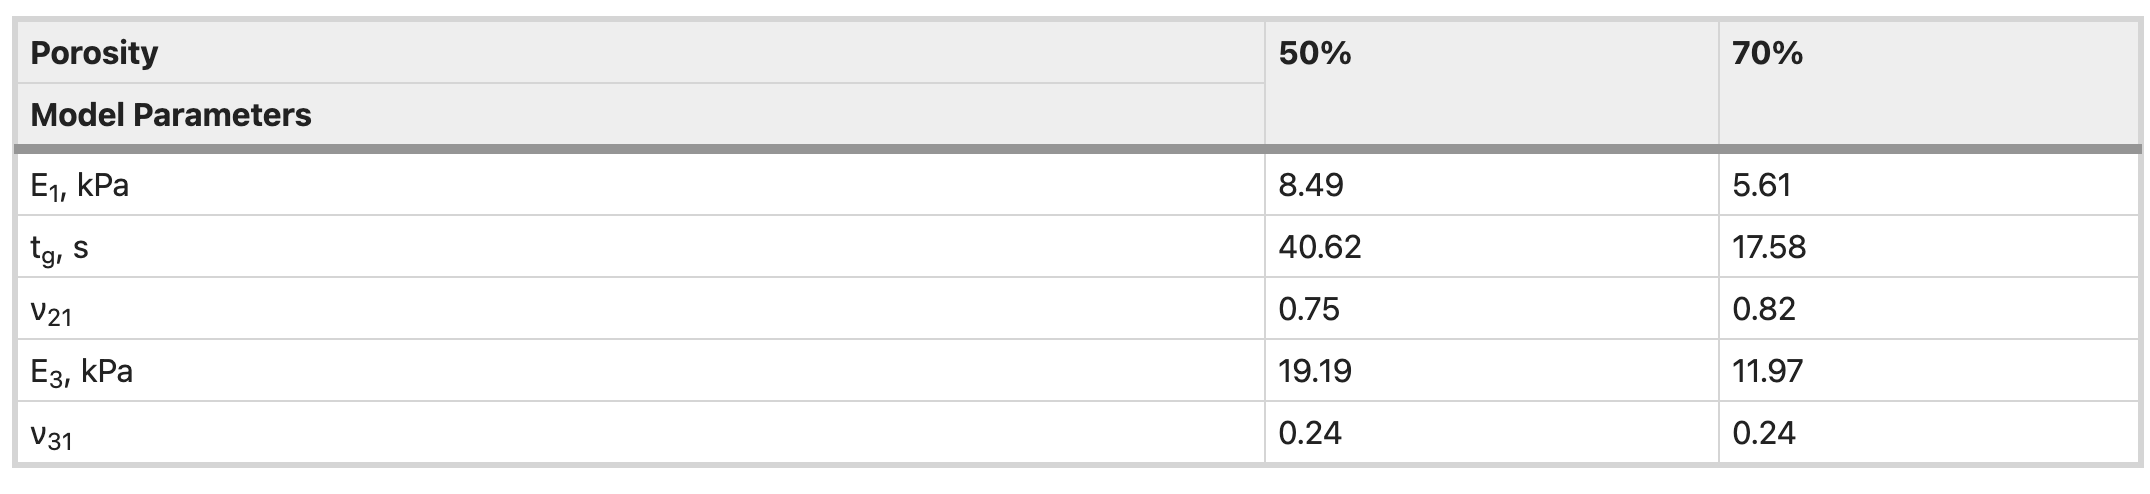

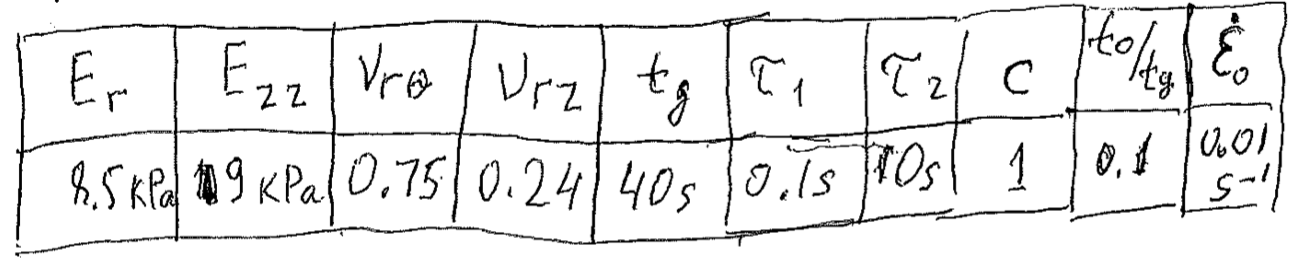

# Simple Laplace Model Inversion
## $$\begin{align} F(s)&=\frac{1}{s-a} \\ f(t)&={\mathrm{e}}^{a t}=\exp{\left(a t\right)} \end{align}$$

<IPython.core.display.Javascript object>

It took 0.0000 sec to evaluate the Laplace space func for 100 input s vals.
It took 0.0042 sec to numerically invert Laplace the func for 999 input times.


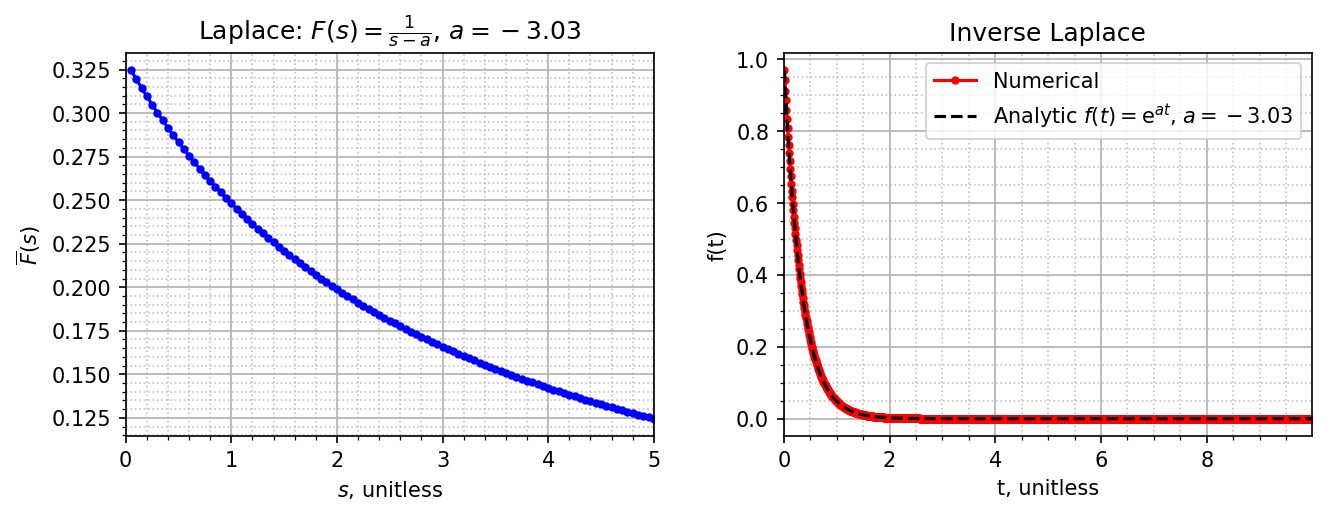

In [ ]:
#@markdown Simple Laplace - Numerical Inversion

importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
times=np.arange(0.1,100,0.1)/10000.0*10
times=np.arange(0.1,100,0.1)/100.0*10

input_times = times
plot_times  = times
input_times_anal = input_times
plot_times_anal = plot_times/1  #tg=1


# \rm gives roman style letters, which is indicative of a constant
#@markdown $$ F(s)=\frac{1}{s-a} $$
#@markdown $$ f(t)={\mathrm{e}}^{a t}=\exp{\left(a t\right)} $$.
a = -3.03 #@param {type:"number"}
funcs = lambda s: 1/(s-a)
inv_funcs_anal = lambda t: np.exp(a*t)
plot_props = {
    "t":        {"y":{"name":r"f(t)"}, "x":{"name":r"t, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}, 
                 "eqn":{"text":r"$F(s)=\frac{1}{s-a}$, $a="+str(a)+r"$"}},
    "t_anal":   {"eqn":{"text":r"$f(t)={\mathrm{e}}^{a t}$, $a="+str(a)+r"$"}},
}
input_s = np.arange(0.05, 5.05, 0.05)


_=plotting.plot_laplace_analysis(funcs=funcs, plot_props=plot_props, input_s=input_s, 
                                 input_times=input_times, plot_times=plot_times, time_const=1, 
                                 input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
                                 plot_mode="simple")


# Cohen Model Inversion

## Cohen Equations

### Cohen Laplace Solution
$$
\begin{align}
\tilde{\varepsilon}_{zz}&=\dot{\varepsilon}_{0} \cdot t_{g} \cdot \frac{1-\exp \left(-s \cdot t_{0} / t_{g}\right)}{s^{2}} \\
\widetilde{F(s)}&=\tilde{\varepsilon}_{z z}(s) \cdot \frac{C_{1} I_{0}[\sqrt{s}]-C_{2} \cdot C_{0} \cdot \frac{I_{1}[\sqrt{s}]}{\sqrt{s}}}{I_{0}[\sqrt{s}]-C_{0} \cdot \frac{I_{1}[\sqrt{s}]}{\sqrt{s}}} \\
&=\underbrace{\dot{\varepsilon}_{0} t_{g} \left( \frac{1-\exp \left(-s \frac{t_{0}}{t_{g}}\right)}{s^{2}} \right) }_{\tilde{\varepsilon}_{z z}(s) \text{ for "ramp-and-hold" strain}} 
\left( \frac{C_{1} I_{0}\left[\sqrt{s}\right]-C_{2} C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}{I_{0}\left[\sqrt{s}\right]-C_{0} \cdot \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}\right)
\end{align}
$$


### Cohen Inversion (Time) Solution

$$
\newcommand{\compA}[1]{ \color{red}{#1} }
\newcommand{\compB}[1]{ \color{green}{#1} }
$$


$$
\large{
f(t) =
\begin{cases}   
\compA{ E_3 \dot{\varepsilon}_0 t } 
&\compB+&
\compB{E_1 \dot{\varepsilon}_0 t_g \Delta_3} 
& 
\compB{\left( { {\LARGE \frac{1}{8} } - {\LARGE \sum\limits_{\alpha_n^2}^{\infty} }} \frac{\exp \left(-\frac{\alpha_n^2 t}{t_{g}}\right)}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)}\right)}, 
& t \lt t_0 
\\ 
\compA{E_3 \dot{\varepsilon}_0 t_0} 
&\compB-&
\compB{E_1 \dot{\varepsilon}_0 t_g \Delta_3}
& 
\compB{\left( {\LARGE \sum\limits_{\alpha_n^2}^{\infty}} \frac{\exp{\left( -\frac{\alpha_n^2 t}{t_g} \right) } - \exp{\left(-\frac{\alpha_n^2\left(t-t_0\right)}{t_{g}} \right)}}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)} \right)}, 
& t \geq t_0\\ 
\end{cases} \\
}\\
\begin{alignat}{2}
    \compA{\textbf{1st Component}} &\text{: forms asymptote and is linear with $t$, except around $t=t_0$}\\ 
    \compB{\textbf{2nd Component}} &\text{: forms height of peak above asymptote}
\end{alignat}
$$




### Constant definitions (i.e. $\Delta_n$)
\begin{align}
\Delta_{1}&=1-v_{21}-2 v_{31}^{2} \frac{E_1}{E_3} \\
\Delta_{2}&=\left(1-v_{31}^{2} \frac{E_1}{E_3}\right) /\left(1+v_{21}\right) \\
\Delta_{3}&=\left(1-2 v_{31}^{2}\right) \frac{\Delta_{2}}{\Delta_{1}} \\
&= \left(1-2 v_{31}^{2}\right) \frac{\left(1-v_{31}^{2} \frac{E_1}{E_3}\right) /\left(1+v_{21}\right)}{1-v_{21}-2 v_{31}^{2} \frac{E_1}{E_3}}
=  \frac{\left(1-2 v_{31}^{2}\right) \left(1-v_{31}^{2} \frac{E_1}{E_3}\right) }{ \left( 1-v_{21}-2 v_{31}^{2} \frac{E_1}{E_3} \right) \left(1+v_{21}\right)}
\\\\
\end{align}
  

\begin{align}
C_{11}-C_{12}&=\frac{E_1}{1+\nu_{21}} \\
C_{11}+C_{12}&=\frac{E_1}{\Delta_1} \\
C_{13} &= \frac{E_1 \nu_{31}}{\Delta_1}  \\
C_{33} &= \frac{\Delta_1 E_3 + 2 \nu_{31}^2 E_1}  {\Delta_1}  \\
C_{11}+C_{12}-4C_{13} &= \frac{E_1 \left(1-4\nu_{31} \right)}{\Delta_1}  \\
\end{align}

---
\begin{align}
C_0 &= \frac{C_{11} - C_{12}}{C_{11}} = \frac{\Delta_1}{1-\nu_{31}^2 \frac{E_1}{E_3}}  \\
C_1 &= \frac{C_{11} +C_{12} -4C_{13} +2C_{33}}{C_{11}-C_{12}}   \\
C_0 &= \frac{C_{11} - C_{12}}{\left( C_{11}-C_{12} \right)^2}   \\
\end{align}

### Expand time solution denominator eqns
$$
\begin{align}
\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}} &= \alpha_n^2 \frac{\left(1-v_{31}^{2} \frac{E_1}{E_3}\right)^2}{ \left(1+v_{21}\right)^2} -\frac{1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}}}{1+v_{21}} \\
&= \frac{1}{1+v_{21}} \left( \alpha_n^2 \frac{\left(1-v_{31}^{2} \frac{E_1}{E_3}\right)^2}{ \left(1+v_{21}\right)^2} -1 +v_{21} +2 v_{31}^{2} \frac{E_1}{E_3} \right) \\
&= \frac{1}{1+v_{21}} \left( \alpha_n^2 \left( \frac{ 1 -2v_{31}^{2}\frac{E_1}{E_3} +v_{31}^{4} \frac{E_1^2}{E_3^2} }{ 1+2v_{21}+v_{21}^2} \right) -1 +v_{21} +2 v_{31}^{2} \frac{E_1}{E_3}  \right)
\end{align}
$$

## Plots of constant dependence

<IPython.core.display.Javascript object>

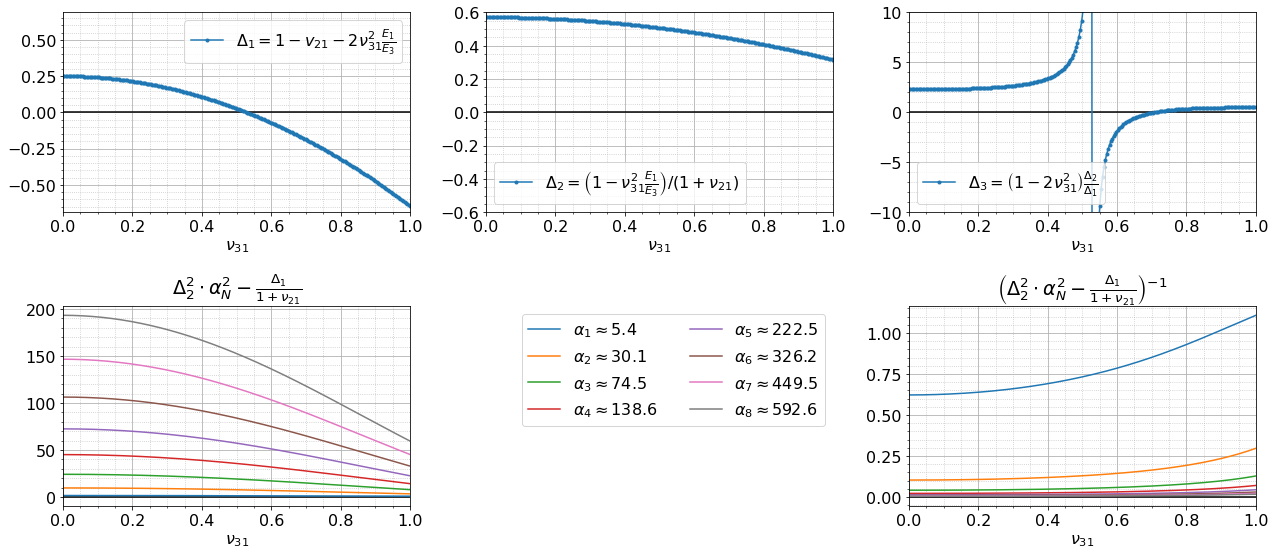

In [104]:
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

vpe = CohenModel()
t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()

v31 = np.linspace(0,1,250, endpoint=True)

v31sq = v31 * v31
delta1 = 1 - v21 - 2*v31sq*E1/E3
delta2 = (1 - v31sq*E1/E3)/(1+v21)
delta3 = (1 - 2*v31sq)*delta2/delta1

vpe.setup_constants(bessel_len=100)
alpha2_vals = vpe.alpha2_vals[0:8]
denom=delta2*delta2*alpha2_vals[...,np.newaxis] - delta1/(1+v21)

nrows=2
ncols=3
fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=(6*ncols,4*nrows))
for ind, ax in enumerate(axes.flat):
    if ind != 4:
        ax.plot(v31,v31*0,"k")
axes.flat[0].plot(v31,delta1,".-", label=r"$\Delta_1=1-v_{21}-2 \nu_{31}^{2} \frac{E_1}{E_3}$")
axes.flat[1].plot(v31,delta2,".-", label=r"$\Delta_2=\left(1-\nu_{31}^{2} \frac{E_1}{E_3}\right) /\left(1+\nu_{21}\right)$")
axes.flat[2].plot(v31,delta3,".-", label=r"$\Delta_3=\left(1-2\nu_{31}^{2}\right) \frac{\Delta_{2}}{\Delta_{1}}$")
lines =axes.flat[3].plot(v31,denom.T)
axes.flat[5].plot(v31,1/denom.T)
"""
lines=[]
for ind, alpha2_val in enumerate(alpha2_vals[0:9]):
    #axes.flat[3].plot(v31,denom[ind,:],label=f"N={ind+1}")
    line,=axes.flat[3].plot(v31,denom[ind,:],label=fr"$\alpha_{ind+1}\approx{alpha2_val:0.1f}$")
    axes.flat[5].plot(v31,1/denom[ind,:])
    lines.append(line)
    """
axes.flat[3].set_title(r"$\Delta_2^2\cdot\alpha^2_N - \frac{\Delta_1}{1+\nu_{21}}$")
axes.flat[5].set_title(r"$\left(\Delta_2^2\cdot\alpha^2_N - \frac{\Delta_1}{1+\nu_{21}}\right)^{-1}$")
axes.flat[4].legend(lines,
                    [fr"$\alpha_{ind+1}\approx{alpha2_val:4.1f}$" for ind, alpha2_val in enumerate(alpha2_vals)],
                    ncol=2
                    )

for ind,ax in enumerate(fig.axes):
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.set_xlim([np.min(v31),np.max(v31)])
    ax.set_xlabel(r"$\nu_{31}$",fontsize=16)

    if ind<3:
        ax.legend(ncol=2)
    if ind==4:
        ax.axis("off")

    # make ylimits symmetric
    ylim = np.max(np.abs(ax.get_ylim()))
    if ind==2:
        ylim=min(ylim,10)
    if ind<3:
        ax.set_ylim([-ylim, ylim])

fig.tight_layout()

In [63]:
(delta2*delta2*alpha2_vals[...,None] - delta1/(1+v21)).shape

<IPython.core.display.Javascript object>

(100, 250)

In [45]:
np.max(np.abs(fig.axes[0].get_ylim()))

<IPython.core.display.Javascript object>

0.6894736842105263

## Numerical Cohen Inversion

<IPython.core.display.Javascript object>

It took 0.0098 sec to evaluate the Laplace space func for 1097 input s vals.
It took 12.1192 sec to numerically invert Laplace the func for 10001 input times.


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:2817: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

t0_tg     tg  ...         C1         C2
CohenModelModified - Line #1  0.246184  40.62  ...  10.207851  31.232221
CohenModelModified - Line #2  0.246184  40.62  ...   7.823529   7.823529
CohenModelModified - Line #3  0.246184  40.62  ...   6.302777  19.796017
CohenModelModified - Line #4  0.246184  40.62  ...   5.464328  14.160942

[4 rows x 17 columns]

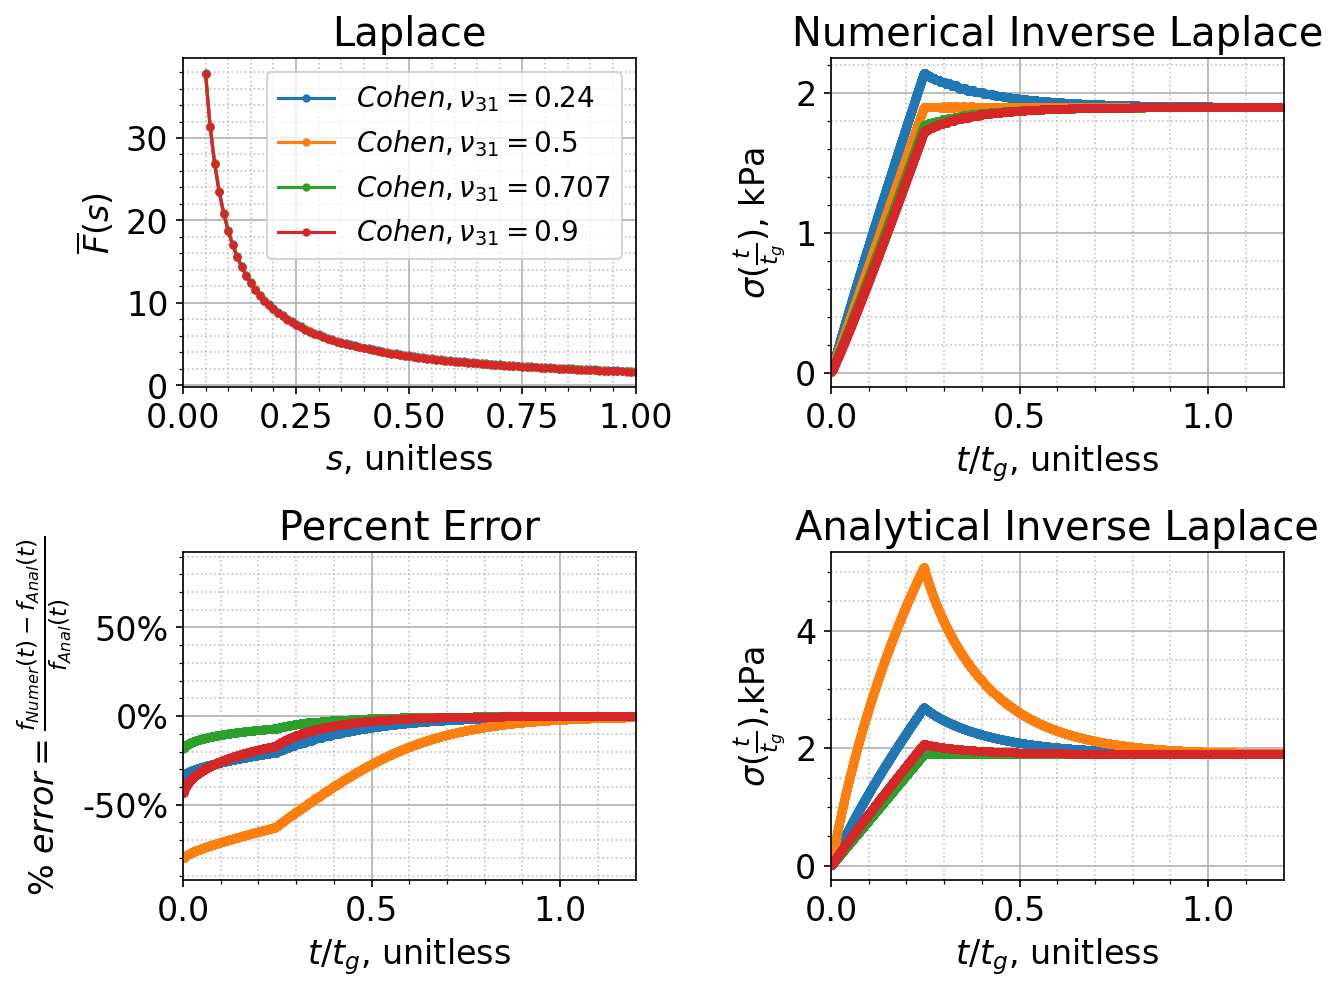

In [36]:
#@title Straightforward Numerical Inversion
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

#E3_vals=[3.5, 8.5]
v31_vals=[0.24, 0.5, 0.707, 0.9]
#v31_vals=[0.01,0.24,0.5]
VPEs = [(getCohenModelModified(v31=v31_val), r"$Cohen, \nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

tg = VPEs[0][0].tg

"""
func = []
import copy
func.append(vpe.laplace_value)
vpeB = copy.deepcopy(vpe)
vpeB.Vrtheta =  0.7
func.append(vpeB.laplace_value)
"""

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 1.2, num=10001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
input_times_anal = input_times
plot_times_anal = plot_times/tg
#func = vpe.laplace_value
func = [vpe.laplace_value for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
plot_props = {
    "t":        {"y":{"name":r"$\sigma(\frac{t}{t_g})$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$\sigma(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False,
    func_labels = func_labels)

for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    itemindex = np.abs(input_times/vpe.tg - vpe.t0_tg).argmin()
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{plot_props['s']['y']['name'].replace('$','')}={laplace_vals[0]*input_s[0]:.3f}"))
    #display(vpe.alpha2_vals)

#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

In [ ]:
def display_key_values(input_times, input_s, plot_props,
                       VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all):
    for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
        #itemindex = np.abs(input_times/vpe.tg - vpe.t0_tg).argmin()
        #itemindex = np.abs(input_times/vpe.tg - 10/40.26).argmin()
        # Closest to original t0_tg (under ramped-flat) without going over
        itemindex = np.abs(input_times/vpe.tg - 10/40.26 + 1e9*(input_times/vpe.tg>10/40.26)).argmin()
        display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
        display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
        display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
        display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{plot_props['s']['y']['name'].replace('$','')}={laplace_vals[0]*input_s[0]:.3f}"))
        


    #df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
    #df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
    #df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
    df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
    display(df_params)
    return df_params


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

It took 0.0064 sec to evaluate the Laplace space func for 1097 input s vals.
It took 1.2720 sec to numerically invert Laplace the func for 1001 input times.


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:2817: ComplexWarning: Casting complex val

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

t0_tg  tg  ...         C1         C2
CohenModelModified - Line #1  0.001   1  ...  12.469818  46.201058
CohenModelModified - Line #2  0.001   1  ...  10.207851  31.232221
CohenModelModified - Line #3  0.001   1  ...   7.823529   7.823529
CohenModelModified - Line #4  0.001   1  ...   6.302777  19.796017
CohenModelModified - Line #5  0.001   1  ...   5.660569  15.208320

[5 rows x 17 columns]

0.100 1.59389 1.56595 1.87023
0.240 1.30476 1.28917 1.95340
0.500 1.00000 0.99797 5.04575
0.707 0.80562 0.81424 0.99968
0.850 0.72353 0.73868 1.23545


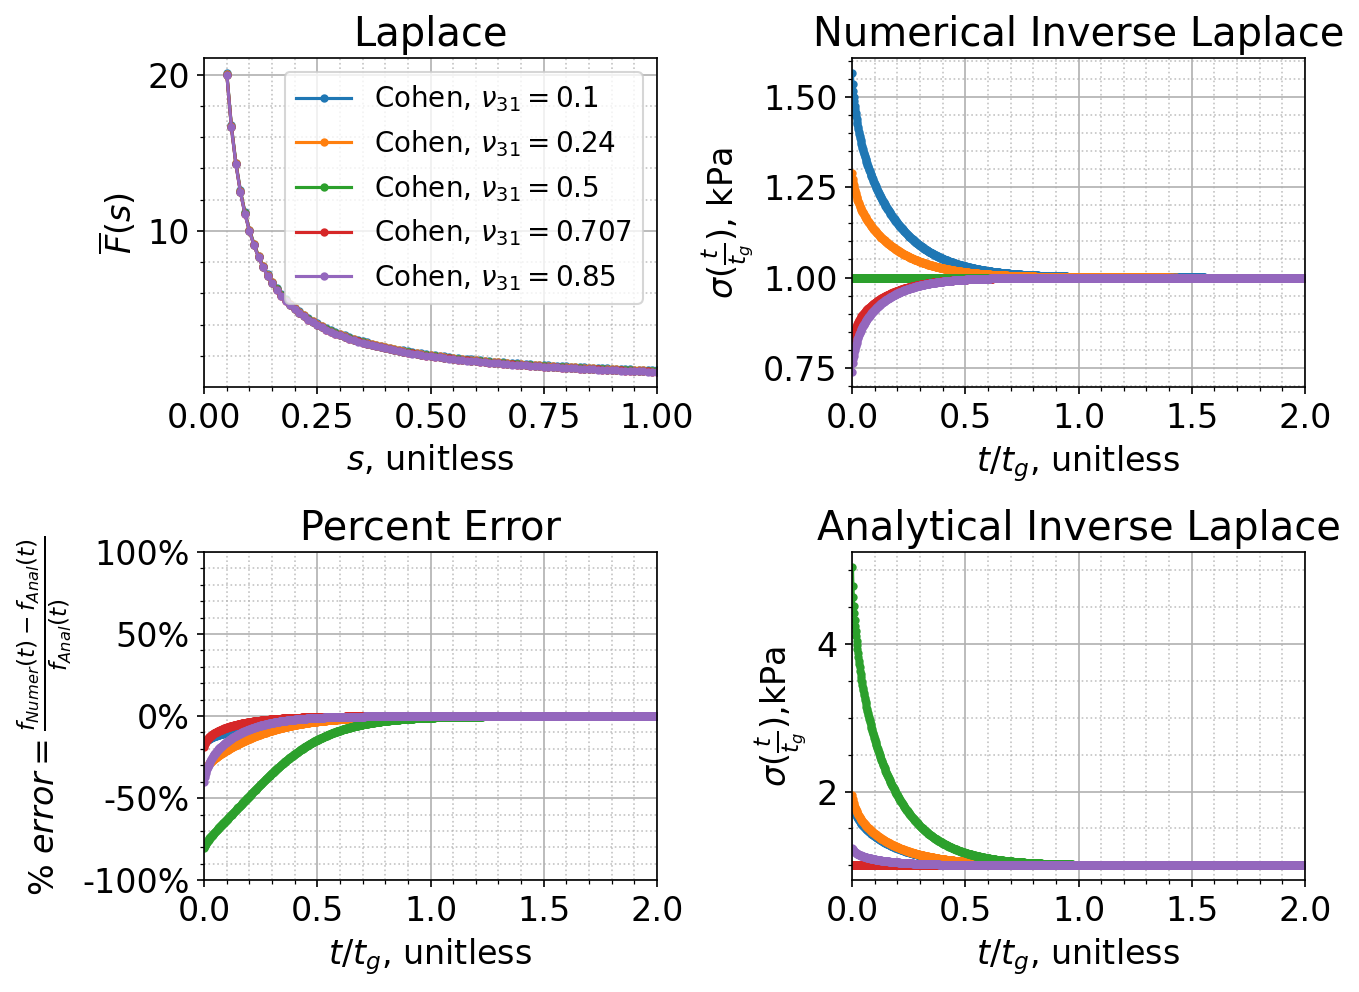

In [35]:
#@title # Compare Cohen inversion if $t_0\to 0^+$ 
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

v31_vals=[0.1, 0.24, 0.5, 0.707, 0.85]
VPEs = [(getCohenModelModified(v31=v31_val, t0_tg=0.001, tg=1), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

tg = VPEs[0][0].tg


# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
input_times = plot_times
input_times_anal = input_times
plot_times_anal = plot_times/tg
func = [vpe.laplace_value for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs]

func_labels = [label for vpe, label in VPEs]
plot_props = {
    "t":        {"y":{"name":r"$\sigma(\frac{t}{t_g})$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$\sigma(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False, scales=[vpe.E3*vpe.strain_rate*vpe.t0_tg*vpe.tg for vpe, name in VPEs],
    func_labels = func_labels)

display_key_values(input_times, input_s, plot_props,
                   VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all);


for ind, (vpe, label) in enumerate(VPEs):
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    print(
        f"{v31:4.3f}",
        f"{1/2 * (2*(1-v21)+(1-4*v31)*E1/E3)/(1-v21-2*v31*v31*E1/E3):4.5f}", 
        f"{inverted_vals_numerical_all[ind,0]/inverted_vals_numerical_all[ind,-1]:4.5f}", 
        f"{inverted_vals_analytical_all[ind,0]/inverted_vals_analytical_all[ind,-1]:4.5f}"
        )

<IPython.core.display.Javascript object>

It took 0.0035 sec to evaluate the Laplace space func for 1097 input s vals.
It took 0.7177 sec to numerically invert Laplace the func for 1001 input times.


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:2817: ComplexWarning: Casting complex val

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

t0_tg  tg  ...         C1         C2
CohenModelModified - Line #1  None   1  ...  12.469818  46.201058
CohenModelModified - Line #2  None   1  ...  10.207851  31.232221
CohenModelModified - Line #3  None   1  ...   7.823529   7.823529
CohenModelModified - Line #4  None   1  ...   6.302777  19.796017
CohenModelModified - Line #5  None   1  ...   5.660569  15.208320

[5 rows x 17 columns]

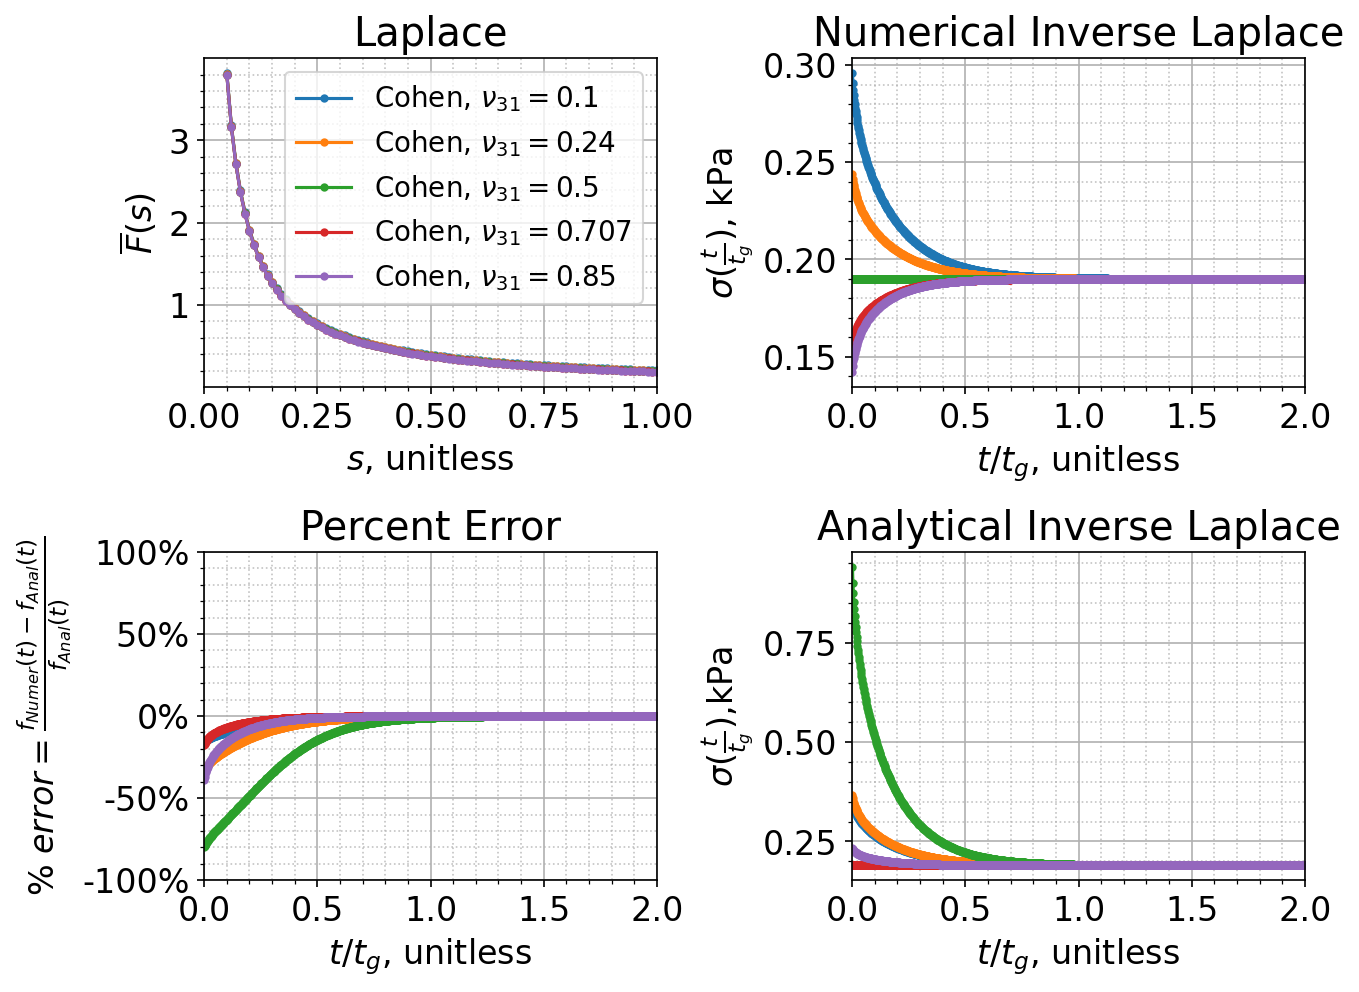

In [ ]:
#@title Stepwise strain
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

v31_vals=[0.1, 0.24, 0.5, 0.707, 0.85]
VPEs = [(getCohenModelModified(v31=v31_val, t0_tg=None, tg=1), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

tg = VPEs[0][0].tg

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
input_times = plot_times
input_times_anal = input_times
plot_times_anal = plot_times/tg
func = [vpe.laplace_value for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs]

func_labels = [label for vpe, label in VPEs]
plot_props = {
    "t":        {"y":{"name":r"$\sigma(\frac{t}{t_g})$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$\sigma(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False, 
    #scales=[vpe.E3*vpe.strain_rate*vpe.t0_tg*vpe.tg for vpe, name in VPEs],
    func_labels = func_labels)

display_key_values(input_times, input_s, plot_props,
                   VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all);



In [31]:
print(VPEs[0][0].t0_tg)

for ind, (vpe, label) in enumerate(VPEs):
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    print(
        f"{v31:4.3f}",
        f"{1/2 * (2*(1-v21)+(1-4*v31)*E1/E3)/(1-v21-2*v31*v31*E1/E3):4.5f}", 
        f"{inverted_vals_numerical_all[ind,0]/inverted_vals_numerical_all[ind,-1]:4.5f}", 
        f"{inverted_vals_analytical_all[ind,0]/inverted_vals_analytical_all[ind,-1]:4.5f}"
        )

<IPython.core.display.Javascript object>

None
1.59389 1.55689 1.85271
1.30476 1.28538 1.93381
1.00000 1.00000 4.95487
0.80562 0.82092 0.99968
0.72353 0.74828 1.22859


In [ ]:
import scipy.integrate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

It took 0.0069 sec to evaluate the Laplace space func for 1097 input s vals.
It took 1.3296 sec to numerically invert Laplace the func for 1001 input times.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplo

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

t0_tg  tg  ...         C1         C2
CohenModelModified - Line #1   1000   1  ...  12.469818  46.201058
CohenModelModified - Line #2   1000   1  ...  10.207851  31.232221
CohenModelModified - Line #3   1000   1  ...   7.823529   7.823529
CohenModelModified - Line #4   1000   1  ...   6.302777  19.796017
CohenModelModified - Line #5   1000   1  ...   5.660569  15.208320

[5 rows x 17 columns]

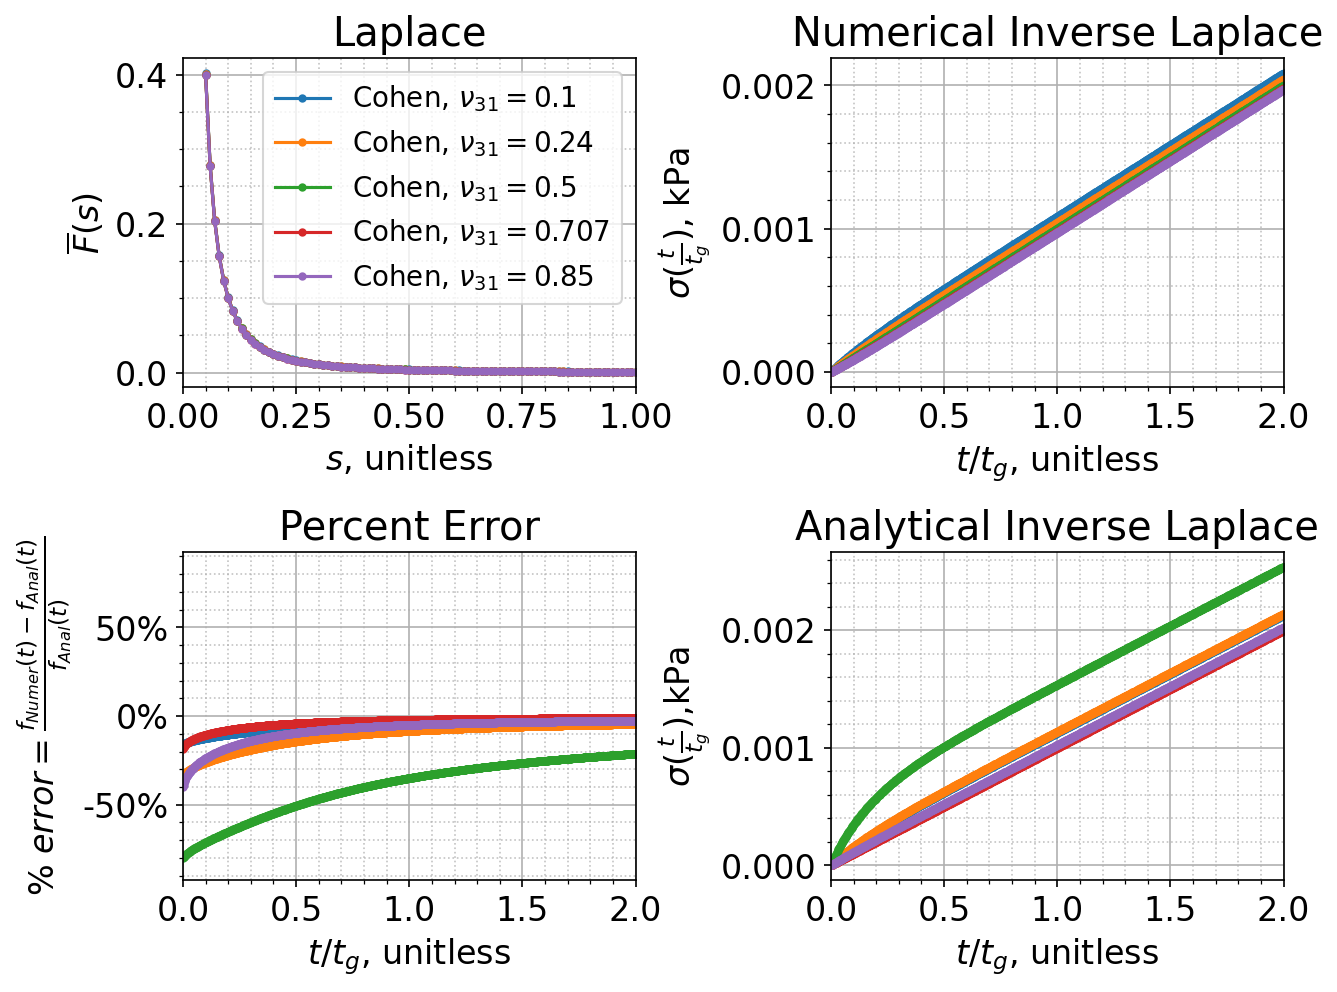

In [ ]:
#@title # Compare Cohen inversion if $t_0\to \infty$ 
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

v31_vals=[0.1, 0.24, 0.5, 0.707, 0.85]
VPEs = [(getCohenModelModified(v31=v31_val, t0_tg=1000, tg=1), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

tg = VPEs[0][0].tg


# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
input_times_anal = input_times
plot_times_anal = plot_times/tg
func = [vpe.laplace_value for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs]

#func = [ (lambda s: s*vpe.laplace_value(s, eps_zz=vpe.strain_rate * tg  / (s*s) ))  for vpe, label in VPEs]
#h = 1e-6
#inv_funcs_anal = [ (lambda t: (vpe.inverted_value(t+h)-vpe.inverted_value(t-h))/(2*h)) for vpe, label in VPEs]
#func = [ (lambda t: get_nth_gradient(vpe.inverted_value(t), t )) for vpe, label in VPEs]
#inv_funcs_anal = [ (lambda t: get_nth_gradient(vpe.inverted_value(t), t )) for vpe, label in VPEs]


func_labels = [label for vpe, label in VPEs]
plot_props = {
    "t":        {"y":{"name":r"$\sigma(\frac{t}{t_g})$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$\sigma(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False, scales=[vpe.E3*vpe.strain_rate*vpe.t0_tg*vpe.tg for vpe, name in VPEs],
    func_labels = func_labels)

display_key_values(input_times, input_s, plot_props,
                   VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all);


In [ ]:
vpe = VPEs[0][0]
times = np.sort(np.array([0, 1e-4, 5e-4, -1, 1, 2.0]) )
input_s = np.sort(np.array([-1e4, -5, -1, 1, 5, 1e4])) + 0j
display(pd.DataFrame([input_s,np.real_if_close(vpe.laplace_value(np.array(input_s))*input_s) ],
                     index=["s","sF(s)"]))
pd.DataFrame([times, vpe.inverted_value(times*vpe.tg), np.real_if_close(inverting.euler_inversion(vpe.laplace_value,times))], 
             index=["t","analy","numer"])

<IPython.core.display.Javascript object>

/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1271: RuntimeWarning: overflow encountered in exp
  eps_zz = strain_rate * tg * (1 - exp(-t0_tg * s)) / (s*s)
/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1271: RuntimeWarning: invalid value encountered in multiply
  eps_zz = strain_rate * tg * (1 - exp(-t0_tg * s)) / (s*s)
/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1271: RuntimeWarning: invalid value encountered in true_divide
  eps_zz = strain_rate * tg * (1 - exp(-t0_tg * s)) / (s*s)


0  ...                       5
s     -10000.000000+0.000000j  ...  10000.000000+0.000000j
sF(s)                     NaN  ...      0.000025+0.000000j

[2 rows x 6 columns]

/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:154: RuntimeWarning: divide by zero encountered in true_divide
  F_s_val, is_inf = F_s(beta_mesh / t_mesh, return_error_inds=True)
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:154: RuntimeWarning: invalid value encountered in true_divide
  F_s_val, is_inf = F_s(beta_mesh / t_mesh, return_error_inds=True)
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:163: RuntimeWarning: divide by zero encountered in true_divide
  ilt = 10 ** (Marg/3) / times * sum (eta_mesh * real(F_s(beta_mesh / t_mesh)), axis=

0             1         2         3         4         5
t     -1.000000e+00  0.000000e+00  0.000100  0.000500  1.000000  2.000000
analy  0.000000e+00  2.802071e-07  0.000038  0.000187  0.047102  0.046777
numer -7.229465e+07           NaN       NaN  0.000123  0.046875  0.046775

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/

Plot 0, line #0, start: 0.1968, final: 0.1968
Plot 0, line #1, start: 0.1900, final: 0.1900
Plot 0, line #2, start: 0.1861, final: 0.1861
Plot 1, line #0, start: 0.1900, final: 0.1900
Plot 1, line #1, start: 0.1900, final: 0.1900
Plot 1, line #2, start: 0.1900, final: 0.1900
Plot 2, line #0, start: 0.1965, final: 0.1965
Plot 2, line #1, start: 0.1890, final: 0.1890
Plot 2, line #2, start: 0.1859, final: 0.1859
Plot 3, line #0, start: 0.1900, final: 0.1900
Plot 3, line #1, start: 0.1900, final: 0.1900
Plot 3, line #2, start: 0.1900, final: 0.1900


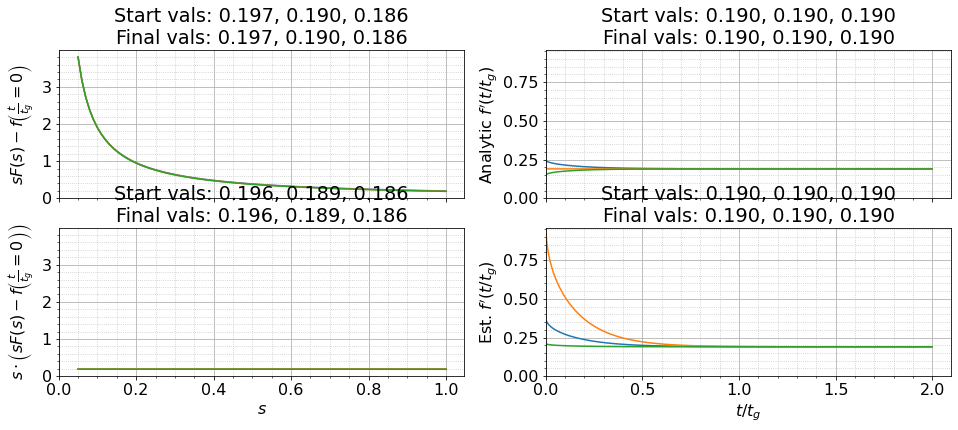

In [ ]:
#@title # Compare $d/dt$ of Cohen inversion if $t_0\to \infty$ 

#laplace_vals_all = [laplace_vals_all_it[0:len(plot_s)] for laplace_vals_all_it in laplace_vals_all]
fig = plt.figure(figsize=(16,6))
axes = fig.subplots(nrows=2, ncols=2, sharex="col", sharey="col")
for ax in axes.flat:
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

    
for ind, (vpe, label) in enumerate(VPEs):
    #axes.flat[0].plot(input_s, laplace_vals_all[ind]*input_s)
    y_val = laplace_vals_all[ind][0:len(plot_s)] * plot_s[0:len(plot_s)]
    axes.flat[0].plot(plot_s, np.real_if_close(y_val) )
    axes.flat[0].set_ylabel(r"$sF(s)-f\left(\frac{t}{t_g}=0\right)$")
    axes.flat[2].plot(plot_s, np.real_if_close(y_val * plot_s[0:len(plot_s)] - inverted_vals_analytical_all[ind, 0]) )
    axes.flat[2].set_ylabel(r"$s\cdot\left(sF(s)-f\left(\frac{t}{t_g}=0\right)\right)$")

    axes.flat[1].plot(input_times,      get_nth_gradient(np.real_if_close(inverted_vals_numerical_all[ind, :]),  input_times),"-")
    axes.flat[1].set_ylabel(r"Analytic $f'(t/t_g)$")
    axes.flat[3].plot(input_times_anal, get_nth_gradient(np.real_if_close(inverted_vals_analytical_all[ind, :]), input_times_anal),"-")
    axes.flat[3].set_ylabel(r"Est. $f'(t/t_g)$")
    
    axes.flat[3].set_xlabel(r"$t/t_g$")
    axes.flat[2].set_xlabel(r"$s$")

for ind, ax in enumerate( axes.flat ):
    #ax.set_xlim([input_times[0], input_times[-1]])
    ax.set_xlim([0, None])
    ax.set_ylim([0, None])
    finals = [[None] * len(ax.lines)]*2
    for ind2, line in enumerate(ax.lines):
        finals[0][ind2] = np.real_if_close(line.get_ydata()[0])
        finals[-1][ind2] = np.real_if_close(line.get_ydata()[-1])
        print( f"Plot {ind}, line #{ind2}, start: {finals[0][ind2]:0.4f}, final: {finals[-1][ind2]:0.4f}" )
    ax.set_title("Start vals: "+ ", ".join([f"{start_val:0.3f}" for start_val in finals[0]]) + "\n"
                 "Final vals: "+ ", ".join([f"{final_val:0.3f}" for final_val in finals[-1]]) 
                 )

### Cohen inversion varying $\nu_{31}$

In [ ]:
#itertools.repeat(inverted_vals_analytical_all)

inverted_vals_numerical

<IPython.core.display.Javascript object>

1.2918228399196006e-06

<IPython.core.display.Javascript object>

It took 0.0013 sec to evaluate the Laplace space func for 1097 input s vals.
It took 0.2295 sec to numerically invert Laplace the func for 1001 input times.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:2817: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

t0_tg  tg  ...         C1         C2
CohenModelModified - Line #1   1000   1  ...  10.207851  31.232221
CohenModelModified - Line #2   1000   1  ...   7.823529   7.823529
CohenModelModified - Line #3   1000   1  ...   6.110283  18.138071

[3 rows x 17 columns]

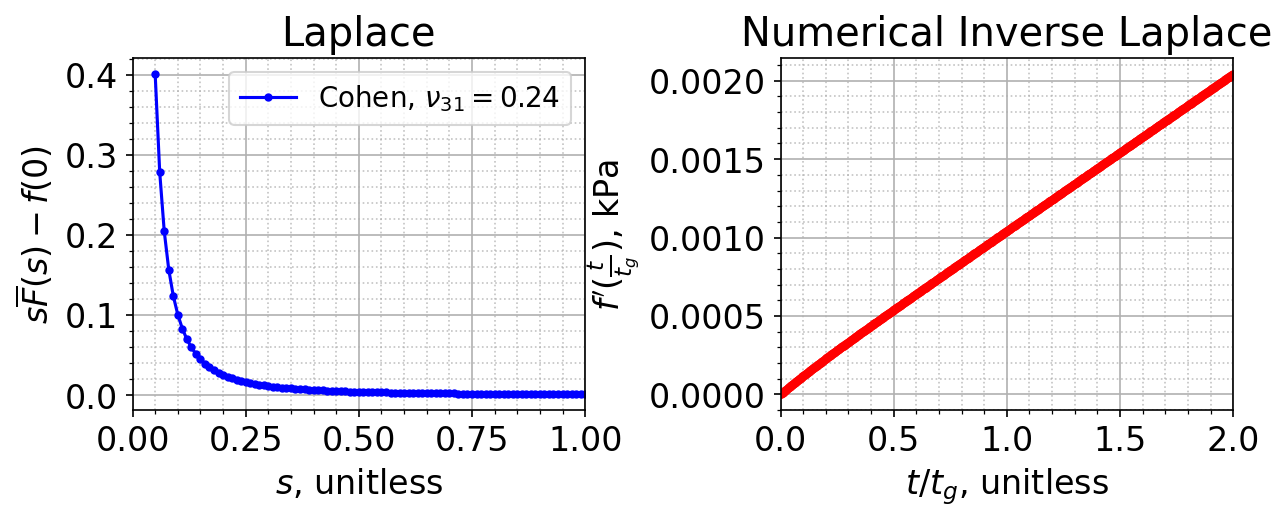

In [ ]:
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

v31_vals=[0.24, 0.5, 0.747]
VPEs = [(getCohenModelModified(v31=v31_val, t0_tg=1000, tg=1), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]
vpe = VPEs[0][0]
tg = VPEs[0][0].tg


# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
func = [vpe.laplace_value ]
#func = [ (lambda s: s*vpe.laplace_value(s, eps_zz=vpe.strain_rate * tg  / (s*s) - vpe.inverted_value(0) ))  for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
plot_props = {
    "t":        {"y":{"name":r"$f'(\frac{t}{t_g})$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$s\overline{F}(s)-f(0)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$f'(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False, scales=[vpe.E3*vpe.strain_rate*vpe.t0_tg*vpe.tg for vpe, name in VPEs],
    func_labels = func_labels)

for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, itertools.repeat(inverted_vals_analytical_all))):
    itemindex = np.abs(input_times/vpe.tg - vpe.t0_tg).argmin()
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{plot_props['s']['y']['name'].replace('$','')}={laplace_vals[0]*input_s[0]:.3f}"))


#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

## Confirm $\nu_{31}$ has an effect on $F(s)$ on the imaginary axis, even though its effect on the real axis is minimal
It is weird that it has a minimal effect on the real axis even though all the intermediate steps ($\Delta_1$, $\Delta_2$, $\Delta_3$, $C_0$, $C_1$, $C_2$) are affected.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


v31=0.24, Re  v31=0.24, Im  ...  v31=0.74, Re  v31=0.74, Im
0.00+0.10j       -0.153326    -19.000529  ...     -0.277855    -18.996881
0.00+11.20j      -0.137962     -0.039242  ...     -0.107273     -0.011882
0.00+22.30j      -0.006476      0.013171  ...     -0.003344      0.009765
0.00+33.40j      -0.011245     -0.008563  ...     -0.008277     -0.004995
0.00+44.50j      -0.005264      0.004634  ...     -0.003226      0.003441
0.00+55.60j      -0.001659     -0.002885  ...     -0.001266     -0.001815
0.00+66.70j      -0.003882      0.001289  ...     -0.002482      0.001053
0.00+77.80j      -0.000058     -0.000483  ...     -0.000061     -0.000312
0.00+88.90j      -0.002457     -0.000206  ...     -0.001605     -0.000020
0.00+100.00j     -0.000140      0.000477  ...     -0.000070      0.000315

[10 rows x 6 columns]

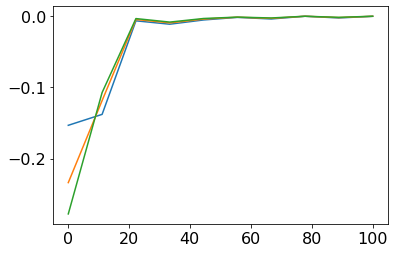

In [ ]:
t0_tg = 10 / 40.62
tg = 40.62  # sec
strain_rate = 0.01  # per sec
E1 = 8.5  # kPa
E3 = 19   # kPa
v21 = 0.75  # like Vrtheta
#v31 = 0.24  # like Vrz

s = np.linspace(0.1,100,10, endpoint=True)*1j
eps_zz = strain_rate * tg * (1 - np.exp(-t0_tg * s)) / (s*s)

Fs = {}
fig = plt.figure()
axs = fig.axes
for v31 in [0.24, 0.5, 0.74]:
    v31sq = v31 * v31

    delta1 = 1 - v21 - 2*v31sq*E1/E3
    delta2 = (1 - v31sq*E1/E3)/(1+v21)
    delta3 = (1 - 2*v31sq)*delta2/delta1

    C11 = E1*(1 - v31*v31 * E1/E3) / ((1+v21) * delta1)
    C12 = E1*(v21+v31*v31 * E1/E3) / ((1+v21) * delta1)
    C13 = E1*v31 / delta1
    C33 = E3 * (1 + 2*v31*v31 * E1/E3 / delta1)   # C44==C31

    C0 = (C11-C12)/C11
    C1 = (2*C33 + C11 + C12 - 4*C13) / (C11-C12)
    C2 = 2 * (C33*(C11-C12) + C11*(C11+C12-4*C13)
                + 2*C13*C13) / (C11-C12)**2




    I1rts_s = I1(np.sqrt(s)) / np.sqrt(s)
    I0rts = I0(np.sqrt(s))

    # F is the load intensity
    F = (C1*I0rts - C2*C0*I1rts_s) / (I0rts - C0*I1rts_s) * eps_zz
    F = F * (C11-C12)/2
    #Fs.append(np.array([F.real, F.imag]))
    Fs[f"v31={v31:0.2f}, Re"]=F.real
    Fs[f"v31={v31:0.2f}, Im"]=F.imag
    plt.plot(np.abs(s),F)

#pd.DataFrame(np.array(Fs).T)
#pd.DataFrame(Fs).T
pd.DataFrame(Fs, index=[f"{s_val:.2f}" for s_val in s])
#, index=s 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[-890.17+0.j    0.  +0.j]
[-684.5+0.j    0. +0.j]
[-537.33-0.j    0.  +0.j]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-30.0, 50.0)

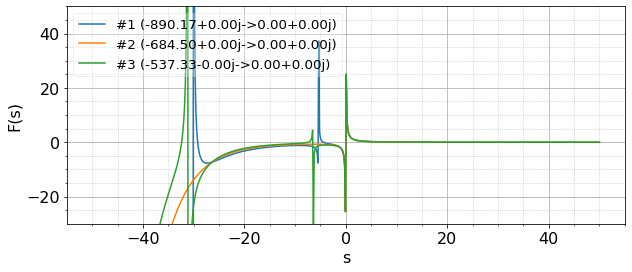

In [ ]:
#@title ## Plot Cohen over imaginary axis

importlib.reload(inverting)

plot_s = np.linspace(0.05, 2, num=1000, endpoint=True)
#plot_s = np.concatenate( [-plot_s, plot_s])
plot_s = np.linspace(-50+0j, 50+0j, num=666, endpoint=True)

t_new_anal = np.linspace(0.05, 100, num=1001, endpoint=True) 

F_s_recalcs = [
               #*[inverting.forward_laplace_transform(inverting.euler_inversion(VPEs[ind][0].laplace_value, t_new_anal), plot_s, times=t_new_anal ) for ind, _ in enumerate(VPEs) ],
               #*[inverting.forward_laplace_transform(inverted_vals_analytical_all[ind], plot_s, times=input_times_anal ) for ind, _ in enumerate(VPEs) ],
               *[VPEs[ind][0].laplace_value(plot_s) for ind, _ in enumerate(VPEs) ],

               #*[inverting.forward_laplace_transform(VPEs[ind][0].inverted_value, plot_s, times=np.linspace(0, 100, num=100001, endpoint=True) ) for ind, _ in enumerate(VPEs)],
               #*[laplace_vals_all[ind][0:len(plot_s)] for ind, _ in enumerate(VPEs) ],
               #*[inverting.forward_laplace_transform(inverted_vals_numerical_all[ind], plot_s, times=plot_times ) for ind, _ in enumerate(VPEs) ]
 
 ]

fig = plt.figure()
fig.set_figwidth(7.5)
fig.set_figwidth(10)
for ind, F_s_recalc in enumerate(F_s_recalcs):
    bounds = F_s_recalc[np.array([0,-1])]
    plt.plot(plot_s, F_s_recalc, label=f"#{ind+1} ({bounds[0]:5.2f}->{bounds[1]:5.2f})")
    print(bounds.round(2))

ax = fig.get_axes()[0]
plt.xlabel("s")
plt.ylabel("F(s)")
plt.legend(framealpha=0.3, fontsize='small', loc="upper left")
ax.grid(which="major")  # set major grid lines
ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#ax.set_xlim([-0.5,None])
ax.set_ylim([-30, 50])




#F_s_recalcs
# (10.207851041127167*I0rts - 6.362394053190878*I1rts_s) / (I0rts - 0.2037125075633159*I1rts_s)
# (10.21*I0rts - 6.36*I1rts_s) / (I0rts - 0.204*I1rts_s)


In [ ]:
#VPEs = [(viscoporoelastic_model.CohenModel1998(), fr"$Cohen$") ]
for VPE, name in VPEs:
    print()
    print(name)
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    delta1, delta2, delta3, C11, C12, C13, C33, C0, C1, C2 = vpe.get_calculable_constants()
    vpe.setup_constants(bessel_len=100)
    alpha2_vals = vpe.alpha2_vals

    print(f"strain_rate*t0*(2*C1-C2*C0)/(2-C0)=\t{strain_rate*t0*(2*C1-C2*C0)/(2-C0)}")
    print(f"strain_rate*t0*2*(1+v21)*E3/E1=\t{strain_rate*t0*2*(1+v21)*E3/E1}")
    print(f"strain_rate*t0*E3=\t{strain_rate*t0*E3}")
    print(f"2*(1+v21)*E3/E1=\t{strain_rate*t0*2*(1+v21)*E3/E1}")
    print(f"(2*C1-C2*C0)/(2-C0)=\t{(2*C1-C2*C0)/(2-C0)}")
    print(f"E3=\t{E3}")


<IPython.core.display.Javascript object>


$Cohen$
strain_rate*t0*(2*C1-C2*C0)/(2-C0)=	1.8999999999999986
strain_rate*t0*2*(1+v21)*E3/E1=	1.9000000000000001
strain_rate*t0*E3=	1.9000000000000001
2*(1+v21)*E3/E1=	1.9000000000000001
(2*C1-C2*C0)/(2-C0)=	18.999999999999986
E3=	19

$Cohen, E_1=3.5$
strain_rate*t0*(2*C1-C2*C0)/(2-C0)=	1.8999999999999986
strain_rate*t0*2*(1+v21)*E3/E1=	1.9000000000000001
strain_rate*t0*E3=	1.9000000000000001
2*(1+v21)*E3/E1=	1.9000000000000001
(2*C1-C2*C0)/(2-C0)=	18.999999999999986
E3=	19


In [ ]:
"""
(2*C33*(C11+C12)-4*C13*C13)/(C11*(C11-C12)), 2*C1-C2*C0
(C11+C12)/C11, 2-C0

E3+2*v31*v31*E1/delta1, C33
E1/(1+v21), C11-C12
E1/delta1, C11+C12
strain_rate*t0*2*E3/E1*(1+v21)
"""

VPEs = [(CohenModel(), fr"$Cohen$"), (getCohenModelModified(), fr"$Cohen$2") ]
[VPE.laplace_value for VPE, name in VPEs]
print(CohenModel.E3)

<IPython.core.display.Javascript object>

19


## 1998 Cohen reproduction
### Reproduce simple 1998 Cohen model, same parameters as paper


<IPython.core.display.Javascript object>

[3.15377282e-08 4.46053371e-03 1.67565916e+00 1.67670166e+00
 1.67328351e+00 1.00000000e+00]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1205: RuntimeWarning: overflow encountered in exp
  for alpha2_N in alpha2_vals
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


t0_tg  tg  strain_rate  ...   C0        C1        C2
CohenModel1998 - Line #1      1   1         0.01  ...  0.7  2.377143  5.826122

[1 rows x 17 columns]

0.0052000000000000015

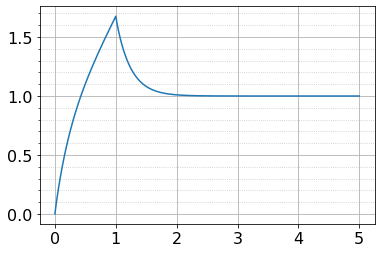

In [ ]:
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)

VPEs = [(viscoporoelastic_model.CohenModel1998(), 
         fr"$Cohen$") ]

t0_tg, tg, strain_rate, E1, E3, v21, v31 = VPEs[0][0].get_predefined_constants()
t0=t0_tg*tg
delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = VPEs[0][0].get_calculable_constants()
#VPEs[0][0].inverted_value(t=0)
VPEs[0][0].setup_constants(bessel_len=100)
alpha2_vals = VPEs[0][0].alpha2_vals

#sum(1/(alpha2_vals*(delta2*delta2*alpha2_vals - delta1/(1+v21)))) => 0.9785392135865333 for len=10,000
"""
print(E3)
print(sum(np.exp(-alpha2_vals * t0_tg)/(alpha2_vals*(delta2*delta2*alpha2_vals - delta1/(1+v21)))))
#alpha2_vals
print((1 - 2*v31*v31*E1/E3) / (1 - v21 - 2*v31*v31*E1/E3))
print((1 - v31*v31*E1/E3) / (1 - v21 - 2*v31*v31*E1/E3))
"""

input_times = np.linspace(0.00, 5, num=1001, endpoint=True) * tg
#output = VPEs[0][0].inverted_value(t=input_times)
t=input_times
output1 = E3*strain_rate*np.minimum(t, t0)
exp = np.exp
output2 = E1*strain_rate*tg*delta3*(1/8*(t<t0) - sum( (exp(-alpha2_N * t/tg) - exp(-alpha2_N * (t-t0)/tg )*(t>=t0) ) / (alpha2_N*(delta2*delta2*alpha2_N - delta1/(1+v21)))
                for alpha2_N in alpha2_vals
    ))
output = output1 + output2 #+ 4*E3*strain_rate*t0*(t<t0)
output = VPEs[0][0].inverted_value(t)
print(VPEs[0][0].inverted_value(t=np.array([0,0.001,t0*0.999,t0,t0*1.001,10]))/(E3*strain_rate*t0))

plt.figure()
plt.plot(input_times/(t0),output/(E3*strain_rate*t0) )
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)



t0_tg = 1.  
tg = 1  # sec.  
strain_rate = 0.01  # per sec.  
E1 = 5  # kPa.   
E3 = 1  # kPa.  
v21 = 0.3  # like Vrtheta.  
v31 = 0  # like Vrz.   

In [ ]:
Cohen1998_params = {"t0_tg":1, "tg":1, "strain_rate":0.01, "E1":5, "E3":1, "v21":0.3, "v31":0}
dict(Cohen1998_params, v31=0.5)
vpe.E3,vpe.strain_rate,vpe.tg

def modif_func(func, val):
    return func(val)*-1

func1 = [(lambda s: vpe.laplace_value(s)) for vpe, label in VPEs]
#func1 = [(lambda s: modif_func(vpe.laplace_value, s)) for vpe, label in VPEs]
#func1 = [(lambda s, myvpe: myvpe.laplace_value(s)) for vpe, label in VPEs]
func2 = [vpe.laplace_value for vpe, label in VPEs]
#print(f"{func1[0](0.5):0.3f}, {func2[0](0.5):0.3f}")
func1[0](0.5), func2[0](0.5)


<IPython.core.display.Javascript object>

(0.03956601784522982, 0.020031966210045223)

In [ ]:
obj = func1[0] #.__code__
keys = dir(obj)
for key in keys:
    output = getattr(obj, key)
    #display("key: " + key)
    
    #print( "\t" + "\n\t".join(str(getattr(obj, key)).split("\n")) )
    #print(key, " "*max(0,15-len(key)) , " -> ", "\t" + "\n\t\t".join(str(output).split("\n")) )
    if len(key)<4 or key[2:-2] not in ["dir","doc","delattr","eq","format","ge","get","getattribute","gt","hash","init_subclass","le","lt","ne","new","reduce","reduce_ex","repr","sizeof","subclasshook"]:
        if len(str(output))<250:
            display(IPython.display.Markdown(f"**`{key}`**   ->   `{output}`"))
        else:
            display(IPython.display.Markdown(f"**`{key}`** "))
            #display(IPython.display.Markdown(f"`{output}`"))
            #print(output)
        


<IPython.core.display.Javascript object>

**`__annotations__`**   ->   `{}`

**`__call__`**   ->   `<method-wrapper '__call__' of function object at 0x7f3eee725320>`

**`__class__`**   ->   `<class 'function'>`

**`__closure__`**   ->   `(<cell at 0x7f3eee6fbc50: CohenModelModified object at 0x7f3ee9d71b50>,)`

**`__code__`**   ->   `<code object <lambda> at 0x7f3eee725ae0, file "<ipython-input-92-cc43cd48a8fe>", line 8>`

**`__defaults__`**   ->   `None`

**`__dict__`**   ->   `{}`

**`__globals__`** 

**`__init__`**   ->   `<method-wrapper '__init__' of function object at 0x7f3eee725320>`

**`__kwdefaults__`**   ->   `None`

**`__module__`**   ->   `__main__`

**`__name__`**   ->   `<lambda>`

**`__qualname__`**   ->   `<listcomp>.<lambda>`

**`__setattr__`**   ->   `<method-wrapper '__setattr__' of function object at 0x7f3eee725320>`

**`__str__`**   ->   `<method-wrapper '__str__' of function object at 0x7f3eee725320>`

<IPython.core.display.Javascript object>

It took 0.0033 sec to evaluate the Laplace space func for 1097 input s vals.
It took 0.6528 sec to numerically invert Laplace the func for 1001 input times.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplo

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

t0_tg  tg  ...         C1          C2
CohenModelModified - Line #1      1   1  ...   1.400000    2.400000
CohenModelModified - Line #2      1   1  ...   2.377143    5.826122
CohenModelModified - Line #3      1   1  ...   3.600000   12.600000
CohenModelModified - Line #4      1   1  ...   6.346667   38.457778
CohenModelModified - Line #5      1   1  ...  19.760000  380.760000

[5 rows x 17 columns]

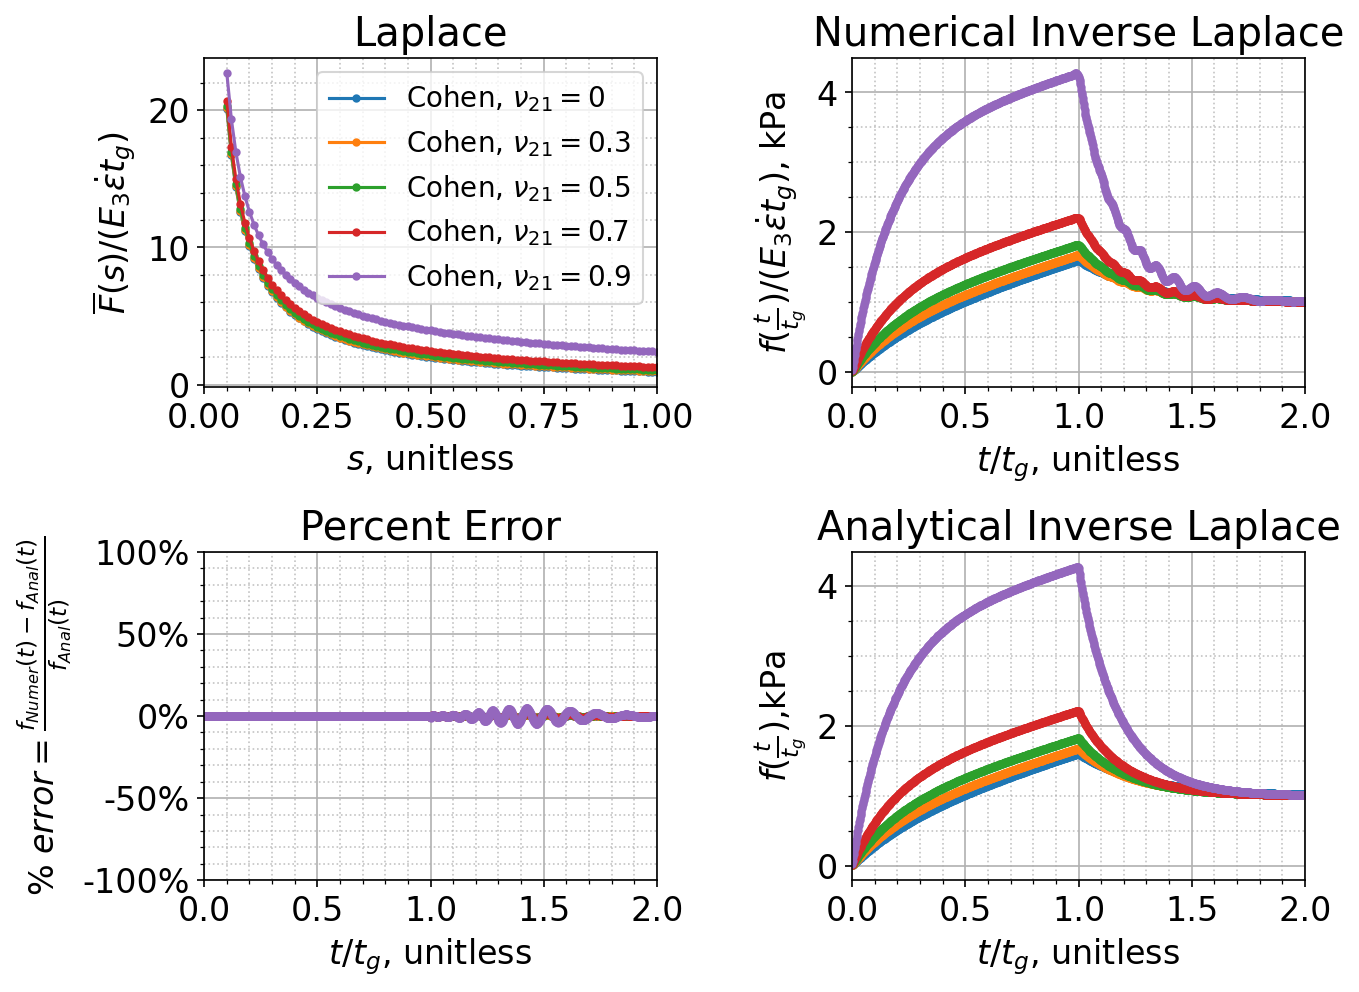

In [ ]:
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)

VPEs = [(viscoporoelastic_model.CohenModel1998(), fr"Cohen 1998") ]

Cohen1998_params = {"t0_tg":1, "tg":1, "strain_rate":0.01, "E1":5, "E3":1, "v21":0.3, "v31":0}
v21_vals = [0, 0.3, 0.5, 0.7, 0.9]   # values plotted in Cohen paper figure 4b
v31_vals = [0.24, 0.5, 0.747]
#VPEs = [(getCohenModelModified(v31=v31_val, tg=1), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]
VPEs = [(getCohenModelModified(**dict(Cohen1998_params, v21=v21_val)), r"Cohen, $\nu_{21}"+f"={v21_val}$") for v21_val in v21_vals ]
#VPEs = [(getCohenModelModified(**dict(Cohen1998_params, v31=v31_val)), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

tg = VPEs[0][0].tg
y_const = 1  #0.01  # vpe.E3,vpe.strain_rate,vpe.tg

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
input_times_anal = input_times
plot_times_anal = plot_times/tg
func = [vpe.laplace_value for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs]
#func = [(lambda s: vpe.laplace_value(s)) for vpe, label in VPEs]
#inv_funcs_anal = [(lambda t: vpe.inverted_value(t)) for vpe, label in VPEs]
#func = [(lambda s: vpe.laplace_value(s)/y_const ) for vpe, label in VPEs]
#inv_funcs_anal = [(lambda t: vpe.inverted_value(t)/y_const) for vpe, label in VPEs]
scales = [vpe.E3*vpe.strain_rate*vpe.tg for vpe, label in VPEs]

func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
plot_props = {
    "t":        {"y":{"name":r"$f(\frac{t}{t_g})/(E_3\dot{\varepsilon}t_g)$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)/(E_3\dot{\varepsilon}t_g)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$f(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False,
    func_labels = func_labels,
    scales=scales,
    )

for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    itemindex = np.abs(input_times/vpe.tg - vpe.t0_tg).argmin()
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{plot_props['s']['y']['name'].replace('$','')}={laplace_vals[0]*input_s[0]:.3f}"))
    #display(vpe.alpha2_vals)

#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

## Splitting up Cohen into parts A and B

### Cohen eqns split up

$$
\large{
f(t) =
\begin{cases}   
\compA{ E_3 \dot{\varepsilon}_0 t } 
&\compB+&
\compB{E_1 \dot{\varepsilon}_0 t_g \Delta_3} 
& 
\compB{\left( { {\LARGE \frac{1}{8}} - \sum\limits_{\alpha_n^2}^{\infty} } \frac{\exp \left(-\frac{\alpha_n^2 t}{t_{g}}\right)}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)}\right)}, 
& t \lt t_0 
\\ 
\compA{E_3 \dot{\varepsilon}_0 t_0} 
&\compB-&
\compB{E_1 \dot{\varepsilon}_0 t_g \Delta_3}
& 
\compB{\left( \sum\limits_{\alpha_n^2}^{\infty} \frac{\exp{\left( -\frac{\alpha_n^2 t}{t_g} \right) } - \exp{\left(-\frac{\alpha_n^2\left(t-t_0\right)}{t_{g}} \right)}}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)} \right)}, 
& t \geq t_0\\ 
\end{cases} \\
}\\
\\
\begin{alignat}{2}
    \compA{\textbf{1st Component}} &\text{: Determines the $t\to\infty$ asymptote and is linear with $t$ (except around $t=t_0)$}\\ 
    \compB{\textbf{2nd Component}} &\text{: Determines height of the peak above asymptote and is nonlinear with $t$. }\text{Approaches $0$ as $t\to\infty$ }
\end{alignat}
$$

$$
\begin{align}
\widetilde{F(s)}&=
\underbrace{\dot{\varepsilon}_{0} t_{g} \left( \frac{1-\exp \left(-s \frac{t_{0}}{t_{g}}\right)}{s^{2}} \right) }_{\tilde{\varepsilon}_{z z}(s) \text{ for "ramp-and-hold" strain}} 
\left( \frac{C_{1} I_{0}\left[\sqrt{s}\right]-C_{2} C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}{I_{0}\left[\sqrt{s}\right]-C_{0} \cdot \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}\right)
\end{align}
$$


$\textbf{Using the notation} \\ $
$$
\begin{multline*}
\text{Numerical estimate of } f(t) = \widehat{f}(t) = \ilaplaceest{F(s)} \\
\text{where } \ilaplaceest{} = \text{Numerical approx. of inverse laplace transform} \\
\end{multline*}
\\
$$
$\textbf{If we define} \\ $
$$
A(t) = E_3 \dot{\varepsilon}_0 \begin{cases}t, & t<t_0 \\ t_0, & t \geq t_0\end{cases} \\
$$
$ \textbf{Then we describe the time solutions as } \\ $
$$
f(t) = A(t) + B_{\text{anl}}(t) \\
\widehat{f}(t) = A(t) + B_{\text{num}}(t)  \\
\begin{aligned}[t]
\text{Satisfying }
B_{\text{anl}}(t) \Big|_{t=0} &= 0 = \displaystyle{\lim_{t \to \infty} B_{\text{anl}}(t)} \\
B_{\text{num}}(t) \Big|_{t=0} &= 0 = \displaystyle{\lim_{t \to \infty} B_{\text{num}}(t)}
\end{aligned}
\\ 
$$
$\textbf{To evaluate $B(t)$, use: } \\ $
$$
\begin{align}
B_{\text{anal}}(t) &=
\begin{cases}   
    +
    E_1 \dot{\varepsilon}_0 t_g \Delta_3
    \left( { {\large \frac{1}{8}} - \sum\limits_{\alpha_n^2}^{\infty} } \frac{\exp \left(-\frac{\alpha_n^2 t}{t_{g}}\right)}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)}\right), 
    & t \lt t_0 
    \\ 
    -
    E_1 \dot{\varepsilon}_0 t_g \Delta_3
    \left( \sum\limits_{\alpha_n^2}^{\infty} \frac{\exp{\left( -\frac{\alpha_n^2 t}{t_g} \right) } - \exp{\left(-\frac{\alpha_n^2\left(t-t_0\right)}{t_{g}} \right)}}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)} \right), 
    & t \geq t_0\\ 
\end{cases} \\
B_{\text{num}}(t) &= \widehat{f}(t) - A(t) = \widehat{f}(t) - E_3 \dot{\varepsilon}_0 \begin{cases}t, & t<t_0 \\ t_0, & t \geq t_0\end{cases}   \\ \\
\end{align}
$$
$\textbf{Finally, then it can be noted empirically that:} \\ $
$$
\begin{aligned}[c]
B_{\text{anal}}(t) &\propto B_{\text{num}}(t)  \\
B_{\text{anal}}(t) &\approx K \cdot B_{\text{num}}(t)  \\
&   \\
f(t) - A(t) &\propto \widehat{f}(t) - A(t) \\
f(t) &\approx A(t) + K \left( \widehat{f}(t) - A(t) \right) \\
\end{aligned}
\text{where }
K=\frac{1-2\nu_{31}^2}{(1-2\nu_{31})^2}
\\
$$

\text{where } B(t) \in \big\{ B_{\text{anl}}(t), B_{\text{num}}(t) \big\} \text{ should satisfy} \\ 




$$
\text{Separating out the constants so $A$, $B$, $X$, and $Y$ do not depend on $t$ } \\
\begin{align}
A &= E_3 \dot{\varepsilon}_0 t_g , &
B &= E_1 \dot{\varepsilon}_0 t_g \\ 
X &= \Delta_2^2 , &
Y &= \frac{\Delta_1}{1+\nu_{21}} \\
\end{align}
$$


$$
\begin{align}
f(t) &= 
\begin{cases}   
A\frac{t}{t_g}   &+ B \left( \frac{1}{8} - \sum_{\alpha_n^2} \frac{\exp \left(-\alpha_n^2 \frac{t}{t_g}\right)}{\alpha_{n}^{2}\left(X \alpha_n^2 - Y \right)}\right), & t \lt t_0 \\ 
A\frac{t_0}{t_g} &- B \left( \sum_{\alpha_n^2} \frac{\exp{\left( -\alpha_n^2 \frac{t}{t_g} \right) } - \exp{\left(-\alpha_n^2 \frac{t-t_0}{t_g} \right)}}{\alpha_{n}^{2}\left(X \alpha_n^2 - Y\right)} \right), & t \geq t_0
\end{cases} \\
\\
\text{if we assume dimensionless variables, i.e. }\\ 
\text{$t\leftarrow t/t_g$ and $t_0 \leftarrow  t_0/t_g$, thus } \\
f(t) &= 
\begin{cases}   
At   &+ B \left( \frac{1}{8} - \sum_{\alpha_n^2} \frac{\exp \left(-\alpha_n^2 t \right)}{\alpha_{n}^{2}\left(X \alpha_n^2 - Y \right)}\right), & t \lt t_0 \\ 
At_0 &- B \left( \sum_{\alpha_n^2} \frac{\exp{\left( -\alpha_n^2 t \right) } - \exp{\left( -\alpha_n^2 \left(t-t_0 \right) \right)}}{\alpha_n^2 \left(X \alpha_n^2 - Y\right)} \right), & t \geq t_0 \\
\end{cases} \\
\\
\\
\frac{\mathrm{d} f(t)} {\mathrm{d}t} &= 
\begin{cases}   
A   &- B \left( \sum_{\alpha_n^2} \frac{\exp \left(-\alpha_n^2 t \right)}{\alpha_n^2\left(X \alpha_n^2 - Y \right)}\right) \cdot -\alpha_n^2, & t \lt t_0 \\ 
0   &- B \left( \sum_{\alpha_n^2} \frac{\exp{\left( -\alpha_n^2 t \right) } - \exp{\left( -\alpha_n^2 \left(t-t_0 \right) \right)}}{\alpha_n^2 \left(X \alpha_n^2 - Y\right)} \right) \cdot -\alpha_n^2, & t \geq t_0
\end{cases} \\
&= 
\begin{cases}   
A   &+ B  \sum_{\alpha_n^2} \frac{\exp \left(-\alpha_n^2 t \right)}{X \alpha_n^2 - Y } , & t \lt t_0 \\ 
    &+ B  \sum_{\alpha_n^2} \frac{\exp{\left( -\alpha_n^2 t \right) } - \exp{\left( -\alpha_n^2 \left(t-t_0 \right) \right)}}{ X\alpha_n^2 - Y} , & t \geq t_0
\end{cases} \\
\\
\frac{\mathrm{d}^2 f(t)} {\mathrm{d}t^2} &= 
B \begin{cases}   
    \sum_{\alpha_n^2} -\alpha_n^2 \frac{\exp \left(-\alpha_n^2 t \right)}{X \alpha_n^2 - Y } , & t \lt t_0 \\ 
    \sum_{\alpha_n^2} -\alpha_n^2 \frac{\exp{\left( -\alpha_n^2 t \right) } - \exp{\left( -\alpha_n^2 \left(t-t_0 \right) \right)}}{ X\alpha_n^2 - Y} , & t \geq t_0
\end{cases} \\
\\
\text{for positive integers $m$ i.e. $m \in \{1,2,3 \dots\}$} \\
\frac{\mathrm{d}^{(m+1)} f(t)} {\mathrm{d}t^{(m+1)}} &= 
B \begin{cases}   
     \sum_{\alpha_n^2} \left(-\alpha_n^2 \right)^{m} \frac{\exp \left(-\alpha_n^2 t \right)}{X \alpha_n^2 - Y } , & t \lt t_0 \\ 
     \sum_{\alpha_n^2} \left(-\alpha_n^2 \right)^{m} \frac{\exp{\left( -\alpha_n^2 t \right) } - \exp{\left( -\alpha_n^2 \left(t-t_0 \right) \right)}}{ X\alpha_n^2 - Y} , & t \geq t_0
\end{cases} \\
\end{align}
$$

$f'(t)$ represents the derivative of $f(t)$
$$
\begin{align}
\L{f'(t)}&=sF(s)-f(0^-) \\
\L{f''(t)}&=s^2F(s)-sf(0^-)-f'(0^-) \\ 
\L{f'''(t)}&=s^3F(s)-s^2f(0^-)-sf'(0^-)-f''(0^-) \\ 
\L{f^{(m)}(t)}&=s^mF(s)-\sum_{n=m-1}^{0} s^nf^{(m-n-1)}(0^-) \\ 
\end{align}
$$

### Plot summation part only

In order to better explain this, pls generate the following curve for t<t_0 and  v_31=0.5 , keeping  the same your latest values of other parameters

1/8 - Sum{exp[-(alpha_n)^2 t/t_g]/[ (alpha_n)^2[(delta_2)^2 (alpha_n)^2  - delta_1/(1+v_21)]} 

${ \frac{1}{8}}-\sum_{\alpha_n^2}^{\infty}\frac{\exp \left(-\frac{\alpha_n^2 t}{t_{g}}\right)}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)}$

In [ ]:
v31_vals = np.array([0.5, np.sqrt(0.5), 0.25])
v31_vals.sort()

VPEs = [(getCohenModelModified(v31=v31_val), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

tg = VPEs[0][0].tg

bessel_len_max = 100
plot_times_tg, t_step = np.linspace(0.001, 0.5, num=1001, endpoint=True, retstep=True)
plot_times = plot_times_tg*tg

part=np.full( (bessel_len_max, len(plot_times), len(VPEs)), np.nan )

for ind, (vpe, name) in enumerate(VPEs):
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    delta1, delta2, delta3, C11, C12, C13, C33, C0, C1, C2 = vpe.get_calculable_constants()

    vpe.setup_constants(bessel_len=bessel_len_max)
    alpha2_vals = vpe.alpha2_vals
    t = plot_times

    part[:,:,ind]=(1/8 - np.cumsum(
            [(np.exp(-alpha2_N * t/tg)
            / (alpha2_N*(delta2*delta2*alpha2_N - delta1/(1+v21))))
            for alpha2_N in alpha2_vals], axis=0
            )
        )
    



<IPython.core.display.Javascript object>

In [ ]:
matplotlib.__version__

<IPython.core.display.Javascript object>

'3.5.1'

<IPython.core.display.Javascript object>

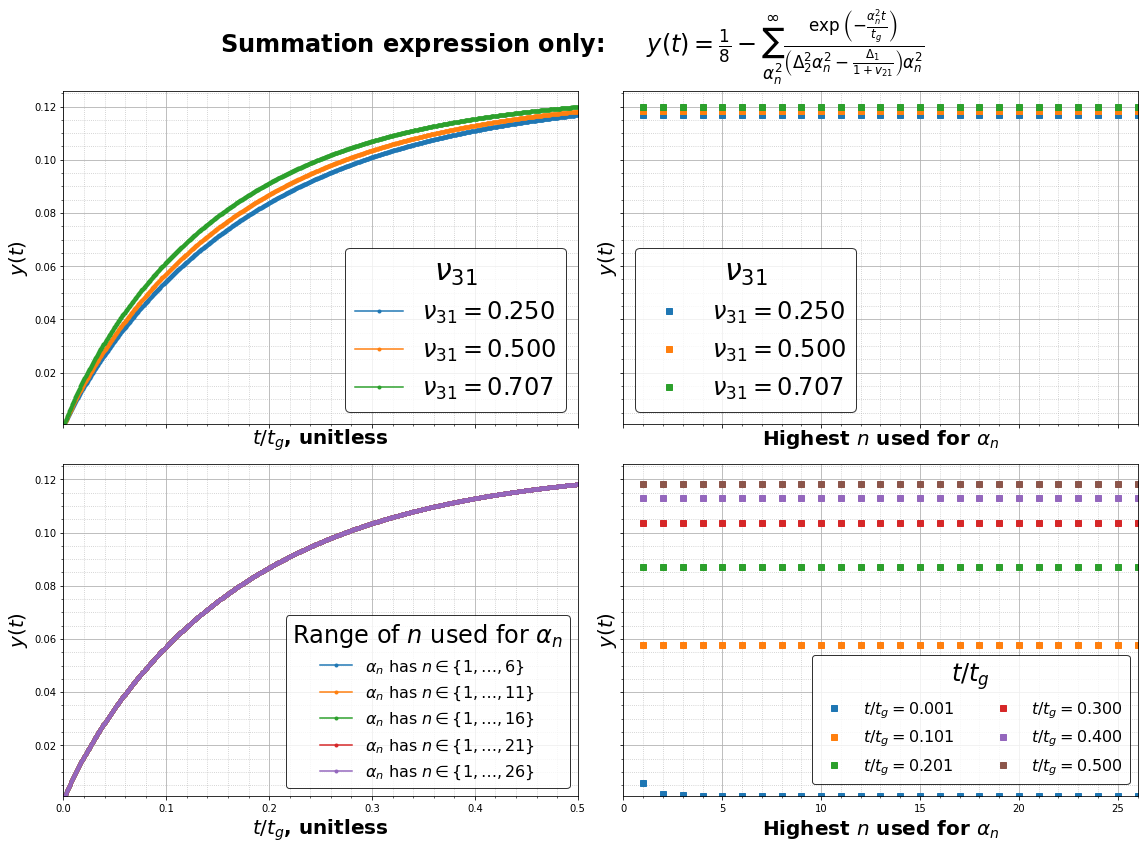

In [ ]:
bessel_inds = np.arange(bessel_len_max)[5:(30):5]
plot_times_tg_inds = np.arange(0,len(plot_times_tg),200) 
vpe_ind_key = 1

fig = plt.figure(figsize=(16,12))
axes = fig.subplots(nrows=2, ncols=2, sharey=True, sharex="col")

axes[0,0].plot(plot_times_tg, part[-1,:,:],".-")
axes[0,0].legend([r"$\nu_{31}="+f"{v31_val:0.3f}$" for v31_val in v31_vals], 
                 title=r"$\nu_{31}$",  edgecolor="k", prop={"size":24}, title_fontsize=30)

axes[0,1].plot(np.arange(bessel_len_max)+1, part[:,-1,:],"s")
axes[0,1].legend([r"$\nu_{31}="+f"{v31_val:0.3f}$" for v31_val in v31_vals], 
                 title=r"$\nu_{31}$", edgecolor="k", prop={"size":24}, title_fontsize=30)

axes[1,0].plot(plot_times_tg, part[ bessel_inds,:,1].T,".-")
axes[1,0].legend([r"$\alpha_n$ has $n \in \{1,\ldots,"+f"{bessel_len_max_this+1}"+r"\}$" for bessel_len_max_this in bessel_inds], 
                 title=r"Range of $n$ used for $\alpha_n$", edgecolor="k", prop={"size":16}, title_fontsize=24)

axes[1,1].plot(np.arange(bessel_len_max)+1, part[:,plot_times_tg_inds,vpe_ind_key],"s")
axes[1,1].legend([f"$t/t_g={plot_times_tg[plot_times_tg_inds_this]:0.3f}$" for plot_times_tg_inds_this in plot_times_tg_inds], 
                 title=r"$t/t_g$", bbox_to_anchor=(1.0, 0.45), edgecolor="k", prop={"size":16}, title_fontsize=24, ncol=2)



for ind,ax in enumerate(axes.flat):
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")

    min_val = np.min(np.array(part))
    ax.set_ylim([min_val, None])
        
    #ax.set_ylabel(r"$\frac{1}{8}-sum(.)$",fontsize=16,fontweight="bold")
    #ax.set_ylabel(r"""${\LARGE \frac{1}{8} } - {\LARGE \sum\limits_{\alpha_n^2}^{\infty} }} \frac{\exp \left(-\frac{\alpha_n^2 t}{t_{g}}\right)}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)}$""",fontsize=16,fontweight="bold")
    #ax.set_ylabel(r"${ \frac{1}{8}}-\sum_{\alpha_n^2}^{\infty}\frac{\exp \left(-\frac{\alpha_n^2 t}{t_{g}}\right)}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)}$",fontsize=24,fontweight="bold")
    ax.set_ylabel("$y(t)$",fontsize=20,fontweight="bold")
fig.suptitle(r"Summation expression only:     $y(t)={ \frac{1}{8}}-\sum_{\alpha_n^2}^{\infty}\frac{\exp \left(-\frac{\alpha_n^2 t}{t_{g}}\right)}{\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)\alpha_{n}^{2}}$",fontsize=24,fontweight="bold")


for row_ind,ax in enumerate(axes[:,0]):
    ax.set_xlim([0,np.max(plot_times_tg)])
    ax.set_xlabel("$t/t_g$, unitless",fontsize=20,fontweight="bold")

for row_ind,ax in enumerate(axes[:,1]):
    #ax.set_xlim([0,bessel_len_max])
    ax.set_xlim([0,np.max(bessel_inds+1)])
    ax.set_xlabel(r"Highest $n$ used for $\alpha_n$",fontsize=20,fontweight="bold")

plt.tight_layout()
plt.savefig(get_path_to_save(save_filename=f"Summation_expression_only"), bbox_inches='tight')  # Include the bbox_inches='tight' is critical to ensure the saved images aren't cutoff while the colab images are normal

### Values of $A$ and $B$

In [ ]:
A = E3 * strain_rate * tg
#B = E1 * strain_rate * tg
X = delta2**2
Y = delta1/(1+v21)
#print(f"A={A}, B={B}, X={X}, Y={Y}")
#print(f"A={A:0.3f}, B={B:0.3f}, X={X:0.3f}, Y={Y:0.3f}")
display(IPython.display.Math("\\\\".join([f"A={A:0.3f}", f"B={B:0.3f}", f"X={X:0.3f}", f"Y={Y:0.3f}"]) ))


<IPython.core.display.Javascript object>

A=7.7177999999999995, B=3.4527, X=0.3099190757284188, Y=0.11340751879699248


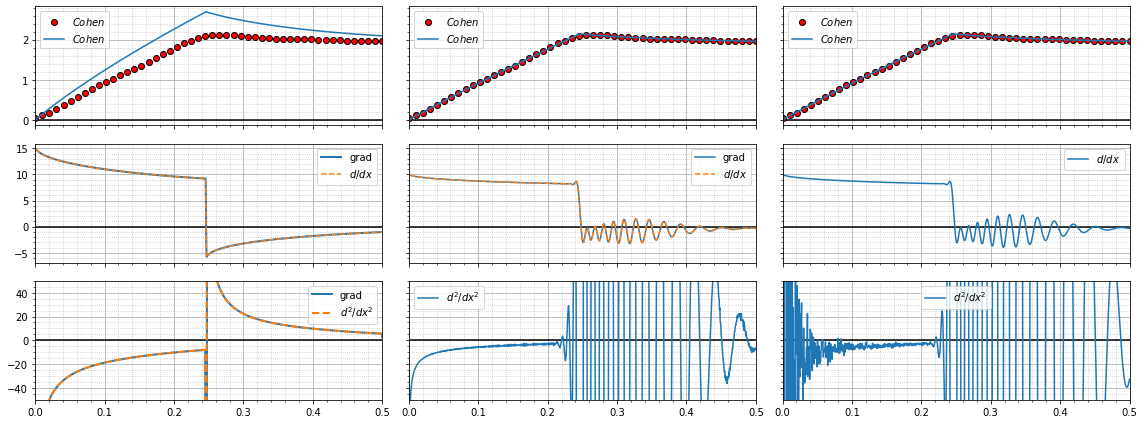

In [ ]:
#@title Derivative plot 1
importlib.reload(viscoporoelastic_model)

VPEs = [(viscoporoelastic_model.CohenModel(), fr"$Cohen$") ]

t0_tg, tg, strain_rate, E1, E3, v21, v31 = VPEs[0][0].get_predefined_constants()
t0=t0_tg*tg
delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = VPEs[0][0].get_calculable_constants()



plot_times_tg, t_step = np.linspace(0.001, 0.5, num=1001, endpoint=True, retstep=True)
plot_times = plot_times_tg*tg

        

(s, ds)=np.linspace(start=1-50j, stop=1+50j, num=10000, endpoint=True, retstep=True)
#t1 = np.array([0.1, 0.2, 0.25, 0.3, 0.4, 0.5])
#t1 = np.concatenate( [np.array([0.246184]), np.linspace(start=0, stop=0.5, num=12)] )
t1 = np.linspace(start=0, stop=0.5, num=50)



fig = plt.figure(figsize=(16,6))
axes = fig.subplots(nrows=3, ncols=3, sharey="row", sharex=True)

for ax in axes.flat:
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")

inverted_values_analy = []
inverted_values_numer = []
inverted_values_intnum = []
inverted_laplace_ddx = []
inverted_laplace_ddx2 = []
for ind, (vpe, name) in enumerate(VPEs):
    inverted_values_analy.append(  vpe.inverted_value(plot_times) )
    inverted_values_numer.append(  inverting.euler_inversion(vpe.laplace_value, plot_times_tg) )
    # The [...,None] index allows t1 to be either a single value (returns single value) or a matrix (returns matrix)
    laplace_val = vpe.laplace_value(s, dimensional=True) 
    expon_2pii = np.exp(s[...,None]*t1)/(2j*np.pi)
    inverted_values_intnum.append( np.real_if_close((np.sum(laplace_val * expon_2pii.T, axis=-1)*ds).T) )
    inverted_laplace_ddx.append(inverting.euler_inversion(
                       (lambda x: vpe.laplace_value(x)*x-0), plot_times_tg))
    inverted_laplace_ddx2.append(inverting.euler_inversion(
                       (lambda x: vpe.laplace_value(x)*x*x-x*np.diff(inverted_values_numer[ind][0:2])/t_step-0 ), plot_times_tg))

for ind, (vpe, name) in enumerate(VPEs):
    for ind2 in range(3):
        axes[0,ind2].plot(t1, inverted_values_intnum[ind], "ro", mec="k", mew=1, label=name )
    
    axes[0,0].plot(plot_times_tg, inverted_values_analy[ind], label=name )
    axes[1,0].plot(plot_times_tg, np.gradient(inverted_values_analy[ind], plot_times_tg), label="grad", lw=2 )
    axes[1,0].plot(get_midpoint(plot_times_tg), 
                   np.diff(inverted_values_analy[ind])/t_step, "--", label="$d/dx$" )
    axes[2,0].plot(plot_times_tg, 
                   np.gradient(np.gradient(inverted_values_analy[ind], plot_times_tg), plot_times_tg), 
                   label="grad", lw=2 )
    axes[2,0].plot(plot_times_tg[1:-1], 
                   get_diff2(inverted_values_analy[ind],t_step), "--", label="$d^2/dx^2$", lw=2 )
    """axes[2,0].plot( plot_times_tg[1:-1], 
                   np.diff(inverted_values_analy[ind],2)/np.diff(plot_times_tg,2), "-", label="$d/dx$" )
    axes[2,0].set_ylim([-5,5])"""

    axes[0,1].plot(plot_times_tg, inverted_values_numer[ind], label=name )
    axes[1,1].plot(plot_times_tg, np.gradient(inverted_values_numer[ind], plot_times_tg) , label="grad" )
    axes[1,1].plot(get_midpoint(plot_times_tg), 
                   np.diff(inverted_values_numer[ind])/np.diff(plot_times_tg), "--", label="$d/dx$" )
    axes[2,1].plot(plot_times_tg[1:-1], 
                   get_diff2(inverted_values_numer[ind],t_step), "-", label="$d^2/dx^2$" )
    """axes[0,0].plot(plot_times_tg, np.gradient(inverted_values_analy, plot_times_tg), label=name )"""

    axes[0,2].plot(plot_times_tg, inverted_values_numer[ind], label=name )
    axes[1,2].plot(plot_times_tg, inverted_laplace_ddx[ind], "-", label="$d/dx$" )
    axes[2,2].plot(plot_times_tg, inverted_laplace_ddx2[ind], "-", label="$d^2/dx^2$" )
    

for ax in axes.flat:
    ax.legend()

#axes[0,0].set_ylim([None,15])
axes[0,0].set_xlim([0,np.max(plot_times_tg)])
axes[2,0].set_ylim([-50,50])
plt.tight_layout()

<IPython.core.display.Javascript object>

A=7.7177999999999995, B=3.4527, X=0.3099190757284188, Y=0.11340751879699248


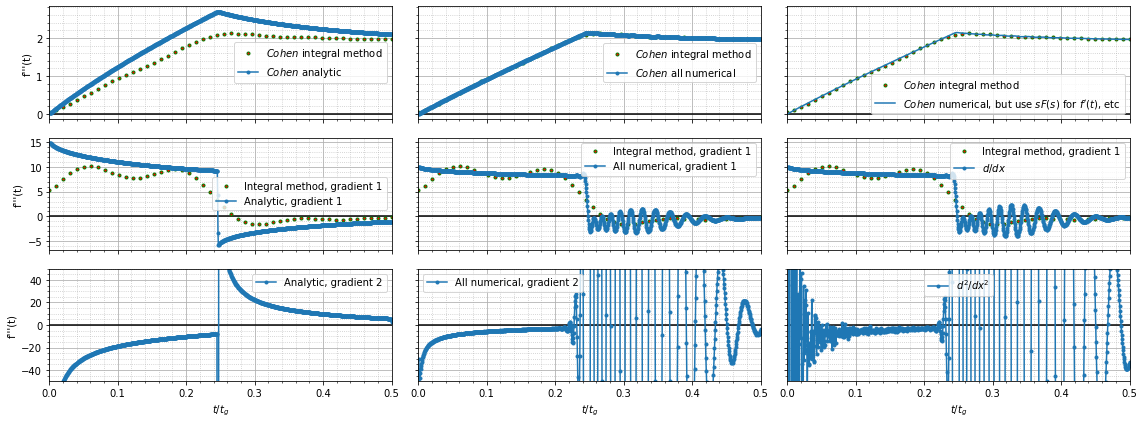

In [ ]:
#@title Derivative plot 2

importlib.reload(viscoporoelastic_model)

VPEs = [(viscoporoelastic_model.CohenModel(), fr"$Cohen$") ]

t0_tg, tg, strain_rate, E1, E3, v21, v31 = VPEs[0][0].get_predefined_constants()
t0=t0_tg*tg
delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = VPEs[0][0].get_calculable_constants()

A = E3 * strain_rate * tg
B = E1 * strain_rate * tg
X = delta2**2
Y = delta1/(1+v21)
print(f"A={A}, B={B}, X={X}, Y={Y}")

plot_times_tg, t_step = np.linspace(0.001, 0.5, num=1001, endpoint=True, retstep=True)
plot_times = plot_times_tg*tg
        

(s, ds)=np.linspace(start=1-50j, stop=1+50j, num=10000, endpoint=True, retstep=True)
#t1 = np.array([0.1, 0.2, 0.25, 0.3, 0.4, 0.5])
#t1 = np.concatenate( [np.array([0.246184]), np.linspace(start=0, stop=0.5, num=12)] )
t1 = np.linspace(start=0, stop=0.5, num=50)


fig_r_ct=3
fig_c_ct=3
fig = plt.figure(figsize=(16,6))
axes = fig.subplots(nrows=fig_r_ct, ncols=fig_c_ct, sharey="row", sharex=True)

for ax in axes.flat:
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")

inverted_values_analy = []
inverted_values_numer = []
inverted_values_intnum = []
inverted_laplace_ddx = []
inverted_laplace_ddx2 = []
for ind, (vpe, name) in enumerate(VPEs):
    inverted_values_analy.append(  vpe.inverted_value(plot_times) )
    inverted_values_numer.append(  inverting.euler_inversion(vpe.laplace_value, plot_times_tg) )
    # The [...,None] index allows t1 to be either a single value (returns single value) or a matrix (returns matrix)
    laplace_val = vpe.laplace_value(s, dimensional=True) 
    expon_2pii = np.exp(s[...,None]*t1)/(2j*np.pi)
    inverted_values_intnum.append( np.real_if_close((np.sum(laplace_val * expon_2pii.T, axis=-1)*ds).T) )
    inverted_laplace_ddx.append(inverting.euler_inversion(
                       (lambda x: vpe.laplace_value(x)*x-0), plot_times_tg))
    inverted_laplace_ddx2.append(inverting.euler_inversion(
                       (lambda x: vpe.laplace_value(x)*x*x-x*np.diff(inverted_values_numer[ind][0:2])/t_step-0 ), plot_times_tg))

for ind, (vpe, name) in enumerate(VPEs):
    for ind3 in range(fig_c_ct):
        axes[0,ind3].plot(t1, inverted_values_intnum[ind], "r.", mec="g", mew=1, label=name + " integral method" )
        ind2=0
        axes[ind2+1,ind3].plot(t1, get_nth_gradient(inverted_values_intnum[ind], t1, ind2+1), "r.", mec="g", mew=1, label=f"Integral method, gradient {ind2+1}" )

    axes[0,0].plot(plot_times_tg, inverted_values_analy[ind], ".-" ,label=name + " analytic" )
    for ind2 in range(fig_r_ct-1):
        axes[ind2+1,0].plot(plot_times_tg, 
                            get_nth_gradient(inverted_values_analy[ind], plot_times_tg, ind2+1),  ".-",
                            label=f"Analytic, gradient {ind2+1}" )


    axes[0,1].plot(plot_times_tg, inverted_values_numer[ind], ".-", label=name + " all numerical" )
    for ind2 in range(fig_r_ct-1):
        axes[ind2+1,1].plot(plot_times_tg, get_nth_gradient(inverted_values_numer[ind], plot_times_tg, ind2+1), ".-" , label=f"All numerical, gradient {ind2+1}" )

    axes[0,2].plot(plot_times_tg, inverted_values_numer[ind], label=name + " numerical, but use $sF(s)$ for $f'(t)$, etc" )
    axes[1,2].plot(plot_times_tg, inverted_laplace_ddx[ind], ".-", label="$d/dx$" )
    axes[2,2].plot(plot_times_tg, inverted_laplace_ddx2[ind], ".-", label="$d^2/dx^2$" )

    

for ax in axes.flat:
    ax.legend()

axes[0,0].set_xlim([0,np.max(plot_times_tg)])
axes[2,0].set_ylim([-50,50])
for ind2 in range(fig_r_ct):
    axes[ind2,0].set_ylabel("f"+("'"*fig_r_ct)+"(t)")
for ind2 in range(fig_c_ct):
    axes[-1,ind2].set_xlabel("$t/t_g$")
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

[-99.2 -96.5 -69.9 -57.  -49.1 -43.5 -39.4 -36.1 -33.4 -31.2]
[-30.4 -29.5 -21.4 -17.4 -15.  -13.3 -12.  -11.  -10.2  -9.5]
[3.3 3.3 3.3 3.3 3.3 3.3 3.3 3.3 3.3 3.3]
[3.272 3.272 3.272 3.272 3.272 3.249 3.21  3.123 3.163 3.292]


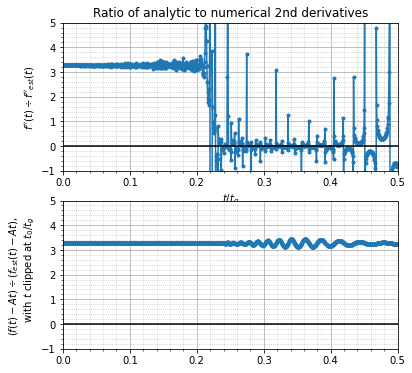

In [ ]:
#@title Simple derivative ratio plot vs time

display(IPython.display.Math("\\\\".join([f"A={A:0.3f}", f"B={B:0.3f}", f"X={X:0.3f}", f"Y={Y:0.3f}"]) ))

with np.printoptions(precision=1, suppress=True):
    analy2 = get_nth_gradient (inverted_values_analy[0], plot_times_tg, 2)
    numer2 = get_nth_gradient (inverted_values_numer[0], plot_times_tg, 2)
    print( analy2[0:100:10] )
    print( numer2[0:100:10] )
    print( (analy2/numer2)[0:100:10] )
with np.printoptions(precision=3, suppress=True):
    #print( ( (inverted_values_analy[0]-A*plot_times_tg)/(inverted_values_numer[0]-A*plot_times_tg))[0:-1:100] )
    #print( ( (inverted_values_analy[0]-A*t0_tg)/(inverted_values_numer[0]-A*t0_tg))[0:-1:100] )
    ratio_of_subtracted = (inverted_values_analy[0]-A*np.clip(plot_times_tg,0,t0_tg))/(inverted_values_numer[0]-A*np.clip(plot_times_tg,0,t0_tg))
    print( ratio_of_subtracted[0:-1:100] )



fig=plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(plot_times_tg, analy2/numer2,".-")
plt.xlabel("$t/t_g$")
plt.ylabel(r"$f''(t) \div f''_{est}(t)$")
plt.title("Ratio of analytic to numerical 2nd derivatives")

plt.subplot(2,1,2)
plt.plot(plot_times_tg, ratio_of_subtracted,".-")
plt.ylabel(
    r"""$(f(t)-At) \div (f_{est}(t)-At)$, 
    with $t$ clipped at $t_0/t_g$""")


for ax in fig.axes:
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")
    ax.set_xlim([0,np.max(plot_times_tg)])
    ax.set_ylim([-1,5])

## Equation Manipulation Experimenting

### Bessel Derivative Manipulation


\begin{align}
\frac{\d I_v (x)}{\d x} &= I_{v-1}(x) - \frac{v}{x} I_v(x) \\
&= \frac{v}{x} I_v(x) + I_{v+1}(x) \\
\\
\frac{\d I_0(x)}{\d x} &= I_1(x) \\
\frac{\d I_1(x)}{\d x} &= I_0(x) - \frac{1}{x} I_1(x) \\
\frac{\d}{\d x} \left( \frac{I_1(x)}{x} \right) &= \frac{ x \left( I_0(x) - \frac{1}{x} I_1(x) \right) - \frac{I_1(x)}{x} }{x^2} \\
&= \frac{ I_0(x) -  I_1(x) - \frac{I_1(x)}{x} }{x^2} \\
\\
\end{align} 

---

\begin{align}
\frac{\d I_0(\sqrt{s})}{\d s} &= \frac{ I_1(\sqrt{s})}{2\sqrt{s}} = \frac{\sqrt{s} I_1(\sqrt{s})}{2s} \\
\frac{\d I_1(\sqrt{s})}{\d s} &= \frac{I_0(\sqrt{s}) - \frac{1}{\sqrt{s}} I_1(\sqrt{s})}{2\sqrt{s}} \\
&= \frac{ \sqrt{s} I_0(\sqrt{s}) -  I_1(\sqrt{s})}{2s} \\
\frac{\d}{\d s} \left( \frac{\Ii{\sqrt{s}}}{\sqrt{s}} \right) &= \frac{ \Io{\sqrt{s}} -  \Ii{\sqrt{s}} - \frac{\Ii{\sqrt{s}}}{\sqrt{s}} }{s \cdot 2 \sqrt{s}} \\
\\
\end{align}

---





\begin{align}
\frac{ I_1(\sqrt{s})}{\sqrt{s}} &= 2\frac{\d \Io{\sqrt{s}}}{\d s}\\
I_0\!\left[\sqrt{s}\right] - \frac{I_1\!\left[\sqrt{s}\right]}{\sqrt{s}} &= 2\sqrt{s} \frac{\d I_1\!\left[\sqrt{s}\right]}{\d s} \\
\\
\end{align} 

---

\begin{align}
\frac{\d}{\d s}\left(\frac{1}{s^2}\right) &= -2s^{-3} \\
\frac{\d}{\d s}\left( \exp\left(s\frac{t_0}{t_g}\right) s^{-2} \right) &= -2s^{-3} \exp\left(s\frac{t_0}{t_g}\right) + \frac{t_0}{t_g}\exp\left(s\frac{t_0}{t_g}\right) s^{-2} \\
\frac{\d}{\d s}\left(\frac{1-\exp\left(s\frac{t_0}{t_g}\right)}{s^2}\right) &= -2s^{-3} \left(1-\exp\left(s\frac{t_0}{t_g}\right)\right) + \frac{t_0}{t_g} \exp\left(s\frac{t_0}{t_g}\right) s^{-2}  \\
&= \frac{-2 \left(1-\exp\left(s\frac{t_0}{t_g}\right)\right) + s\frac{t_0}{t_g} \exp\left(s\frac{t_0}{t_g}\right)}{s^3}\\
&= \frac{-2+ \left(2+s\frac{t_0}{t_g}\right) \exp\left(s\frac{t_0}{t_g}\right)}{s^3}\\
\end{align}


\begin{align}
\widetilde{F(s)}&=
\underbrace{\dot{\varepsilon}_{0} t_{g} \left( \frac{1-\exp \left(-s \frac{t_{0}}{t_{g}}\right)}{s^{2}} \right) }_{\tilde{\varepsilon}_{z z}(s) \text{ for "ramp-and-hold" strain}} 
\left( \frac{C_{1} I_{0}\left[\sqrt{s}\right]-C_{2} C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}{I_{0}\left[\sqrt{s}\right]-C_{0} \cdot \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}\right)
\end{align}



\begin{align}
\frac{\widetilde{F(s)}}{\tilde{\varepsilon}_{zz}(s)}&=
\frac{C_{1} I_{0}\left[\sqrt{s}\right]-C_{2} C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}{I_{0}\left[\sqrt{s}\right]-C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}  \\
&= \frac{C_{1} I_{0}\left[\sqrt{s}\right]-C_{2} C_{0} \cdot 2 I_0'\left[\sqrt{s}\right] }{I_{0}\left[\sqrt{s}\right]-C_{0} \cdot 2 I_0'\left[\sqrt{s}\right]} \\
\end{align}


---
### Background constants, $C_{11}$, $C_{12}$...

\begin{align}
C_{11}
&=\frac{E_1 \cdot \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right)}{ \left(1+\nu_{21}\right) \cdot \Delta_1} \\
&=\frac{E_1 \cdot \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right)}{ \left(1+\nu_{21}\right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) } \\
C_{12}
&=\frac{E_1 \cdot \left( \nu_{21}+\nu_{31}^2 \frac{E_1}{E_3} \right)}{ \left(1+\nu_{21}\right) \cdot \Delta_1} \\
&=\frac{E_1 \cdot \left( \nu_{21}+\nu_{31}^2 \frac{E_1}{E_3} \right)}{ \left(1+\nu_{21}\right)  \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) } \\
C_{13}
&=\frac{E_1 \nu_{31}}{ \Delta_1} \\
&=\frac{E_1 \nu_{31}}{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} } \\
C_{33}
&=E_3 \cdot \left( 1 + \frac{  2\nu_{31}^2 \frac{E_1}{E_3}}{\Delta_1} \right)
= \frac{ \Delta_1 E_3 + 2\nu_{31}^2 E_1}{\Delta_1} \\
&=E_3 \cdot \left( 1 + \frac{  2\nu_{31}^2 \frac{E_1}{E_3}}{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} } \right) \\
&= \frac{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) E_3 + 2 \nu_{31}^2 E_1}{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} }  \\
&= \frac{ E_3 \cdot \left( 1-\nu_{21} \right) }{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} }  \\
\end{align}

---
\begin{align}
C_{11}-C_{12}
&=\frac{E_1}{1+\nu_{21}} \\
\\
C_{11}+C_{12}
&=\frac{E_1}{\Delta_1} \\
&=\frac{E_1}{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} } \\
\\
C_{13} 
&= \frac{E_1 \nu_{31}}{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} }  \\
\\
C_{33} 
&= \frac{ E_3 \cdot \left( 1-\nu_{21} \right) }{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} }  \\
\\
C_{11}+C_{12}-4C_{13} 
&= \frac{E_1 \left(1-4\nu_{31} \right)}{\Delta_1}  \\
&= \frac{E_1 \cdot \left(1-4\nu_{31} \right)}{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} }  \\
\\
C_{11}+C_{12}-4C_{13}+2C_{33} 
&= \frac{E_1 \left(1-4\nu_{31} \right) + 2 E_3 \left( 1-\nu_{21} \right) }{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} }  \\
&= \frac{E_1+2E_3 -4 E_1 \nu_{31} - 2E_3 \nu_{21} }{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} }  \\
\end{align}

---
### Background constants, $C_{1}$, $C_2$, $C_3$, ...


\begin{align}
C_0 
&= \frac{C_{11} - C_{12}}{C_{11}} = \frac{\Delta_1}{1-\nu_{31}^2 \frac{E_1}{E_3}} = \frac{1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}}{1-\nu_{31}^2 \frac{E_1}{E_3}} \\
\\
C_1 
&= \frac{C_{11} +C_{12} -4C_{13} +2C_{33}}{C_{11}-C_{12}}   \\
&= \frac{\left( 1+\nu_{21} \right) \left( 1-4\nu_{31} + 2 \frac{E_3}{E_1} \left( 1-\nu_{21} \right) \right) }{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) }  \\
\\
C_2 
&= 2 \frac{C_{33} \left( C_{11} - C_{12} \right) + C_{11} \left( C_{11}+C_{12}-4C_{13} \right) + 2C_{13}^2 }{\left( C_{11}-C_{12} \right)^2}   \\
&= 2 \frac{ \left( \frac{ E_3 \cdot \left( 1-\nu_{21} \right) }{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} } \right) \left( \frac{E_1}{1+\nu_{21}} \right) + \left( \frac{E_1 \cdot \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right)}{ \left(1+\nu_{21}\right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) } \right)  \left( \frac{E_1 \cdot \left(1-4\nu_{31} \right)}{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} } \right) + 2 \left( \frac{E_1 \nu_{31}}{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} } \right)^2 }{\left( \frac{E_1}{1+\nu_{21}} \right)^2}   \\
&= 2 \frac{ E_3 E_1 \left( 1-\nu_{21} \right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) + E_1^2 \cdot \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \left(1-4\nu_{31} \right)+ 2 E_1^2 \nu_{31}^2 \left( 1+\nu_{21} \right) }{\left( \frac{E_1}{1+\nu_{21}} \right)^2 \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right)^2 \left( 1+\nu_{21} \right) }   \\
&= 2 \frac{ \frac{E_3}{E_1} \left( 1-\nu_{21} \right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) + \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \left(1-4\nu_{31} \right)+ 2\nu_{31}^2 \left( 1+\nu_{21} \right) }{ \frac{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right)^2 }{1+\nu_{21}} }   \\
&= 2 \frac{ \frac{E_3}{E_1} \left( 1-\nu_{21}^2 \right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) + \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \left(1-4\nu_{31} \right) \left(1+\nu_{21}\right) + 2\nu_{31}^2 \left( 1+\nu_{21} \right)^2 }{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right)^2 }   \\
&= 2 \left( 1+\nu_{21} \right) \frac{ \frac{E_3}{E_1} \left( 1-\nu_{21} \right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) + \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \left(1-4\nu_{31} \right)+ 2\nu_{31}^2 \left( 1+\nu_{21} \right) }{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right)^2 }   \\
\end{align}


---

#### Setup system to numerically verify constant equations

In [ ]:
v31_val = np.sqrt(0.3)
v31_vals = np.array([v31_val])
#v31_vals = np.array([0.5, np.sqrt(0.5), v31_val])
#v31_vals = np.linspace(0,1,11,endpoint=True)
v31_vals.sort()
VPEs = [(getCohenModelModified(v31=v31_val), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

for vpe, label in VPEs:
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    v31sq = v31*v31
    delta1, delta2, delta3, C11, C12, C13, C33, C0, C1, C2 = vpe.get_calculable_constants()

<IPython.core.display.Javascript object>

t0_tg     tg  ...        C1         C2
CohenModelModified - Line #1  0.246184  40.62  ...  6.958101  89.173775

[1 rows x 17 columns]

#### Numerically test constant equations

In [ ]:
C11-C12,                E1/(1+v21)
C11+C12,                E1/(1-v21-2*v31sq*E1/E3)
C13,                    E1*v31/(1-v21-2*v31sq*E1/E3)
C33,                    E3*(1-v21)/(1-v21-2*v31sq*E1/E3)
C11+C12-4*C13,          E1*(1-4*v31)/(1-v21-2*v31sq*E1/E3)
C11+C12-4*C13+2*C33,    (E1+2*E3-4*E1*v31-2*E3*v21)/(1-v21-2*v31sq*E1/E3)
C11+C12-4*C13+2*C33,    (E1*(1-4*v31)+2*E3*(1-v21))/(1-v21-2*v31sq*E1/E3)

#C1, (C11+C12-4*C13+2*C33)/(C11-C12) ,(1-4*v31+(1-v21)*E3/E1)/((1+v21)*(1-v21-2*v31sq*E1/E3))

<IPython.core.display.Javascript object>

(27.494191835380022, 27.494191835380022)

In [ ]:
print(C0, delta1/(1-v31sq*E1/E3))
print(C0, (1-v21-2*v31sq*E1/E3)/(1-v31sq*E1/E3))

print(C1, (C11+C12-4*C13+2*C33)/(C11-C12),    (E1*(1-4*v31)+2*E3*(1-v21))/(1-v21-2*v31sq*E1/E3)/(C11-C12) )
print(C1, (E1*(1-4*v31)+2*E3*(1-v21))/(1-v21-2*v31sq*E1/E3)/(E1/(1+v21)) )
print(C1, (C11+C12-4*C13+2*C33)/(C11-C12), (E1*(1-4*v31)+2*E3*(1-v21))/((1-v21-2*v31*v31*E1/E3)*(E1/(1+v21))), (1+v21)*(1-4*v31+2*(1-v21)*E3/E1)/(1-v21-2*v31*v31*E1/E3) ) 


print(C2, 2*( E3*(1-v21)/delta1*(E1/(1+v21)) + E1*(1-v31sq*E1/E3)/((1+v21)*delta1)*(E1*(1-4*v31)/delta1) + 2*(E1*v31/delta1)**2 )/(E1/(1+v21))**2 )
print(C2, 2*( E3*(1-v21)*delta1*(E1) + E1*(1-v31sq*E1/E3)*(E1*(1-4*v31)) + 2*(E1*v31)**2*(1+v21) ) / ((E1/(1+v21))**2 *delta1**2 *(1+v21)) )
print(C2, 2*( E3*E1*(1-v21)*delta1 + E1*E1*(1-v31sq*E1/E3)*(1-4*v31) + 2*(E1*v31)**2*(1+v21) ) / (E1*E1/(1+v21) *delta1**2 ) )
print(C2, 2*( E3*E1*(1-v21)*delta1*(1+v21) + E1*E1*(1-v31sq*E1/E3)*(1-4*v31)*(1+v21) + 2*E1*E1*v31*v31*(1+v21)**2 ) / (E1*E1 *delta1**2 ) )
print(C2, 2* (E3/E1*(1-v21*v21)*(1-v21-2*v31*v31*E1/E3) + (1-v31*v31*E1/E3)*(1-4*v31)*(1+v21) + 2*v31*v31*(1+v21)**2 ) / (  (1-v21-2*v31*v31*E1/E3)**2 ) )
print(C2, 2*(1+v21)*(E3/E1*(1-v21)*(1-v21-2*v31*v31*E1/E3) + (1-v31*v31*E1/E3)*(1-4*v31) + 2*v31*v31*(1+v21) ) / (  (1-v21-2*v31*v31*E1/E3)**2 ) )


<IPython.core.display.Javascript object>

-0.02127659574468068 -0.021276595744680788
-0.02127659574468068 -0.021276595744680788
6.958101263727898 6.958101263727874 6.9581012637278645
6.958101263727898 6.95810126372783
6.958101263727898 6.958101263727874 6.95810126372783 6.958101263727832
89.173775327233 89.17377532723212
89.173775327233 89.17377532723216
89.173775327233 89.17377532723216
89.173775327233 89.17377532723157
89.173775327233 89.1737753272294
89.173775327233 89.1737753272307


In [ ]:
plt.rcParams['lines.markersize']

<IPython.core.display.Javascript object>

6.0

#### Plot $v_{31}$ effect on $C_n$

In [ ]:
def get_C0(v31=v31, v21=v21, E1=E1, E3=E3, minv31bound=0, maxv31bound=1):
    return (1-v21-2*v31*v31*E1/E3)/(1-v31*v31*E1/E3) *np.where((minv31bound<=v31)&(v31<=maxv31bound),1,np.nan)
def get_C1(v31=v31, v21=v21, E1=E1, E3=E3, minv31bound=0, maxv31bound=1):
    return (1+v21)*(1-4*v31+2*(1-v21)*E3/E1)/(1-v21-2*v31*E1/E3) *np.where((minv31bound<=v31)&(v31<=maxv31bound),1,np.nan)
def get_C2(v31=v31, v21=v21, E1=E1, E3=E3, minv31bound=0, maxv31bound=1):
    return (1+v21)*(1-4*v31+2*(1-v21)*E3/E1)/(1-v21-2*v31*v31*E1/E3) - 2* (E3/E1*(1-v21*v21)*(1-v21-2*v31*v31*E1/E3) + (1-v31sq*E1/E3)*(1-4*v31)*(1+v21) + 2*v31sq*(1+v21)**2 ) / (  (1-v21-2*v31sq*E1/E3)**2 ) *np.where((minv31bound<=v31)&(v31<=maxv31bound),1,np.nan)
def get_C2C0(v31=v31, v21=v21, E1=E1, E3=E3, minv31bound=0, maxv31bound=1):
    return get_C2(v31)*get_C0(v31) *np.where((minv31bound<=v31)&(v31<=maxv31bound),1,np.nan)
def get_C1_C2C0(v31=v31, v21=v21, E1=E1, E3=E3, minv31bound=0, maxv31bound=1):
    return get_C1(v31)-get_C2(v31)*get_C0(v31) *np.where((minv31bound<=v31)&(v31<=maxv31bound),1,np.nan)
def get_C1_C2(v31=v31, v21=v21, E1=E1, E3=E3, minv31bound=0, maxv31bound=1):
    return get_C1(v31)-get_C2(v31) *np.where((minv31bound<=v31)&(v31<=maxv31bound),1,np.nan)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0 0.5285285285285285 7.092121642772712e-05
1 0.5295295295295295 0.003683611046676771
2 0.5495495495495496 -6.60170456648643
3 0.5285285285285285 -0.05543855231824675
4 0.5285285285285285 0.027700458321561587
5 0.5495495495495496 7.184920098898513


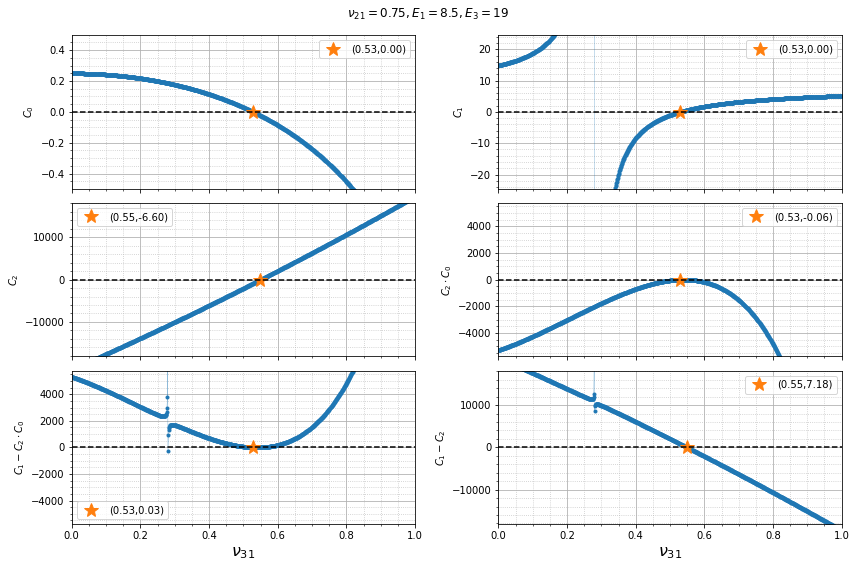

In [ ]:
import scipy.optimize

v31_vals = np.linspace(0,1,num=1000,endpoint=True)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8), sharex=True)
outputs = [(get_C0,"C_0"), (get_C1,"C_1"), (get_C2,"C_2"),
           (get_C2C0,r"C_2\cdot C_0"),
           (get_C1_C2C0,r"C_1-C_2\cdot C_0"), (get_C1_C2,"C_1-C_2")
           ]
for ind in range(len(outputs)):
    axes.flat[ind].plot(v31_vals, outputs[ind][0](v31_vals),".-",lw=0.25,label=None);
    #zero_input = scipy.optimize.fsolve(outputs[ind][0],0.6)[0]
    zero_input = v31_vals[np.argmin( np.abs(outputs[ind][0](v31_vals)) )]
    zero_val = outputs[ind][0](zero_input)
    axes.flat[ind].plot(zero_input,zero_val,"*",label=f"({zero_input:.2f},{zero_val:.2f})",ms=15)
    print(ind,zero_input,zero_val)


for ind,ax in enumerate(axes.flat):
    #ax.set_yscale("symlog",linthresh=200)
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.set_xlim([np.min(v31_vals),np.max(v31_vals)])
    ax.legend(ncol=2) #framealpha=0.5,
    if ind<len(outputs):
        #ax.set_ylim( np.percentile( outputs[ind][0](v31_vals), [1,99] ) )
        ax.set_ylim( np.percentile( np.abs(outputs[ind][0](v31_vals)), 80 ) * np.array([-1.1,1.1]) )
        ax.set_ylabel(f"${outputs[ind][1]}$")
    ax.plot(v31_vals, np.zeros_like(v31_vals), "k--")
    


for lower_ax in axes[-1,:]:
    lower_ax.set_xlabel(r"$\nu_{31}$",fontsize=16,fontweight="bold")
plt.suptitle(r"$\nu_{21}"+f"={v21}, E_1={E1}, E_3={E3}$")
# rect=[left, bottom, right, top] in normalized [0, 1] figure coordinates,
# default rect via fig.tight_layout() is (0, 0, 1, 1)
fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.95])


### Convenient values of $C_1$, etc
It seems that finding convenient-to-analyze values of $C_0$, $C_1$, $C_2$ was not that helpful

#### $C_0\!=\!1 \iff \nu_{21\!}\!=\!0\!=\!\nu_{31}$

##### **Proof:**  
Find value where $C_0=1$
$ \text{Iff } C_0 = \frac{C_{11}-C_{12}}{C_{11}}=1 \text{, then } C_{12}=0  \\
\text{Set } C_{12} = \frac{E_1 \left(\nu_{21}+\nu_{31}^2\frac{E_1}{E_3}\right)}{\left(1+\nu_{21} = 0\right)\Delta_1}   \\
\text{Thus, } E_1=0 \text{  or  } \nu_{21}+\nu_{31}^2\frac{E_1}{E_3}=0 \\
\text{Since } E_1 => C_{11}=C_{12}=0, \text{which make} C_0, C_1, C_2 \text{ undefined, so this is not possible.} \\
\text{If we assume all parameters are non-negative i.e. } x \geq 0 \text{ for } x \in \left\{\nu_{21}, \nu_{31}, E_1, E_3 \right\} , \\  \text{then this is only possible if } \nu_{21}=0=\nu_{31}.
$





##### **Implications**  
Let $\nu_{21}=\nu_{31}=0$ so that $C_0=1$,  
Then
\begin{align}
\Delta_1 &= 1  \\
\Delta_2 &= 1  \\
\Delta_3 &= 3 \\
C_{11} &= E_1 \\
C_{12} &= 0  \\
C_{13} &= 0 \\
C_{33} &= E_3  \\
C_0 &= 1  \\
C_1 &= \frac{E_1+2E_3}{E_1}  \\
&= \frac{E_1^2+2E_1 E_3}{E_1^2}\\
C_2 &= 2\frac{E_3 E_1 + E_1 E_1 + 2 E_3^2}{E_1^2} \\
&= 2\frac{ E_1^2 + E_1 E_3 + 2 E_3^2}{E_1^2} \\
\end{align}

\begin{align}
\frac{\widetilde{F(s)}}{\tilde{\varepsilon}_{zz}(s)}&=
\frac{C_{1} I_{0}\left[\sqrt{s}\right]-C_{2} C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}{I_{0}\left[\sqrt{s}\right]-C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}  \\
&=
\frac{C_{1} I_{0}\left[\sqrt{s}\right]-C_{2} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}{I_{0}\left[\sqrt{s}\right]-\frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}  \\
\end{align}

#### Any solutions that have $E_1=0$ are not possible/meaningful

##### **Proof:**  
If $E_1=0$, then:
\begin{align}
\Delta_1&=1-\nu_{21}   \\
\Delta_2&=\frac{1}{1+\nu_{21}}  \\
\Delta_3&=\frac{1-2\nu_{31}^2}{\left(1-\nu_{21}\right)\left(1+\nu_{21}\right)}  \\
\\
C_{11}=C_{12}=C_{13}&=0  \\
C_{33}&=E_3  \\
C_0, C_1, C_2 &\text{ are undefined (0/0 error)}
\end{align}

$\text{Thus, any solutions that have $E_1=0$} \\ \text{are not possible/meaningful}$

#### $C_1\!=\!C_2 \iff \nu_{31}\!=\!\frac{1}{2}$


##### **Proof:**  
Set $C_1$ = $C_2$:
\begin{align}
\overbrace{\frac{C_{11} +C_{12} -4C_{13} +2C_{33}}{C_{11}-C_{12}}}^{C_1}
 &= \overbrace{ 2 \frac{C_{33} \left( C_{11} - C_{12} \right) + C_{11} \left( C_{11}+C_{12}-4C_{13} \right) + 2C_{13}^2 }{\left( C_{11}-C_{12} \right)^2} }^{C_2}  \\
\left( C_{11}-C_{12} \right) \left( C_{11} +C_{12} -4C_{13} +2C_{33} \right) &= 2 C_{33} \left( C_{11} - C_{12} \right) + 2 C_{11} \left( C_{11}+C_{12}-4C_{13} \right) + 4 C_{13}^2   \\
\left( C_{11}-C_{12} \right) \left( C_{11} +C_{12} -4C_{13} \right) &=  2 C_{11} \left( C_{11}+C_{12}-4C_{13} \right) + 4 C_{13}^2  \\
-\left( C_{11}+C_{12} \right) \left( C_{11} +C_{12} -4C_{13} \right) &=  4 C_{13}^2  \\
- \frac{E_1}{\Delta_1} \cdot \frac{E_1 \left(1-4\nu_{31} \right)}{\Delta_1} &= 4 \left( \frac{E_1 \nu_{31}}{\Delta_1} \right)^2 \\
\left( \frac{E_1}{\Delta_1} \right)^2 \left(4\nu_{31}-1 \right) &= 4 \nu_{31}^2 \left( \frac{E_1}{\Delta_1} \right)^2 \\
\left( 4 \nu_{31}^2 -4 \nu_{31} +1 \right) \left( \frac{E_1}{\Delta_1} \right)^2 &= 0 \\
\left( 2 \nu_{31} -1 \right)^2 \left( \frac{E_1}{\Delta_1} \right)^2 &= 0 \\
\end{align}

$\text{Knowing } E_1=0 \text{ is impossible } \text{as then } C_{11}=C_{12}=0$  
$\text{Thus, only one pair of solutions remains: } \\ $  
\begin{align}
2 \nu_{31} -1 &= 0 
\end{align}
$$\boxed{
\begin{align}
\nu_{31} &= \frac{1}{2}  \iff C_1=C_2
\end{align} }$$

##### **Alternative proof:**  (still need conditions)

Knowing:
\begin{align}
C_0 &= \frac{1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}}{1-\nu_{31}^2 \frac{E_1}{E_3}} \\
\\
C_1 &= \frac{\left( 1+\nu_{21} \right) \left( 1-4\nu_{31} + 2 \frac{E_3}{E_1} \left( 1-\nu_{21} \right) \right) }{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} }  \\
\\
C_2 
&= 2 \frac{ \frac{E_3}{E_1} \left( 1-\nu_{21}^2 \right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) + \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \left(1-4\nu_{31} \right) \left(1+\nu_{21}\right) + 2\nu_{31}^2 \left( 1+\nu_{21} \right)^2 }{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right)^2 }   \\
\end{align}

Solve for $C_1$=$C_2$


\begin{align}
\overbrace{\frac{\left( 1+\nu_{21} \right) \left( 1-4\nu_{31} + 2 \frac{E_3}{E_1} \left( 1-\nu_{21} \right) \right) }{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} } }^{C_1}
&= 
\overbrace{
2 \frac{
    \scriptstyle{
\frac{E_3}{E_1} \left( 1-\nu_{21}^2 \right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) + \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \left(1-4\nu_{31} \right) \left(1+\nu_{21}\right) + 2\nu_{31}^2 \left( 1+\nu_{21} \right)^2}
}{
\left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right)^2 
} }^{C_2}  \tag{A}  \\
\end{align}

\begin{align} 
\small{ \text{Multiply both sides by }}& \scriptstyle{\left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right)^2} \\
{
\left( 1+\nu_{21} \right) \left( 1-4\nu_{31} + 2 \frac{E_3}{E_1} \left( 1-\nu_{21} \right) \right)  \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) }
&= { 2 \frac{E_3}{E_1} \left( 1-\nu_{21}^2 \right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) + 2 \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \left(1-4\nu_{31} \right) \left(1+\nu_{21}\right) + 4\nu_{31}^2 \left( 1+\nu_{21} \right)^2  } \\
\small{\text{Divide both sides by }}&\scriptscriptstyle{1+\nu_{21}}
\\ {
\left( 1-4\nu_{31} + 2 \frac{E_3}{E_1} \left( 1-\nu_{21} \right) \right)  \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) }
&= {
\underbrace{2 \frac{E_3}{E_1} \left( 1-\nu_{21} \right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right)}_{\text{Move to lefthand side}} + 2\left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \left(1-4\nu_{31} \right) + 4\nu_{31}^2 \left( 1+\nu_{21} \right) }
\tag{B} \\
\left( 1-4\nu_{31} \right)  \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right)
&=
\underbrace{2\left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \left(1-4\nu_{31} \right)}_{\text{Move to lefthand side}} + 4\nu_{31}^2 \left( 1+\nu_{21} \right) 
\tag{C} \\
\left( 1-4\nu_{31} \right)  \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} -2\left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \right)
&=
4\nu_{31}^2 \left( 1+\nu_{21} \right) 
\tag{D} \\
\left( 1-4\nu_{31} \right)  \left( -1- \nu_{21}\right) &= 4\nu_{31}^2 \left( 1+\nu_{21} \right) 
\tag{E} \\
-\left( 1-4\nu_{31} \right) \left(1+\nu_{21}\right)  &= 4\nu_{31}^2 \left( 1+\nu_{21} \right)  
\tag{F} \\
-\left( 1-4\nu_{31} +4\nu_{31}^2 \right) \left(1+\nu_{21}\right)  &= 0 
\tag{G}  \\
-\left( 4\nu_{31}^2-4\nu_{31}+1 \right) \left(1+\nu_{21}\right)  &= 0 
\tag{H} \\
-\left( 2\nu_{31}-1 \right)^2 \left(1+\nu_{21}\right)  &= 0   
\tag{I} \\
-\left( 2\nu_{31}-1 \right)^2 \left(1+\nu_{21}\right)  &= \left( C_1-C_2 \right) \overbrace{ \times \frac{\left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right)^2}{ 1+\nu_{21} } }^{\text{Multiplications/divisions}\\ \text{done to get to this step}} \\
-\frac{ \left( 2\nu_{31}-1 \right)^2 \left(1+\nu_{21}\right)^2 }{\left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right)^2} &= C_1-C_2   
\\
\end{align}


$$
\begin{gather}
\boxed{
C_2-C_1 = \left( \frac{ \left( 2\nu_{31}-1 \right) \left(1+\nu_{21}\right) }{1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  } \right)^2    }
\tag{J} \\
\end{gather}
$$

$
\text{Since } \nu_{21}\!=\!-1 \implies C_{11} \text{ and } C_{12} \text{ are undefined, } \text{we know $C_{11}=C_{12}$ has only one solution remaining: }
$
$$ 
\boxed{
C_1=C_2 \iff \nu_{31}=0.5 \\
\text{assuming } 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \neq 0
} 
$$



---
  

Find conditions???
Unfinished

###### Numerical verification

In [ ]:
print(C1, (1+v21)*(1-4*v31+2*(1-v21)*E3/E1)/(1-v21-2*v31*v31*E1/E3) ) 
print(C2, 2* (E3/E1*(1-v21**2)*(1-v21-2*v31**2*E1/E3) + (1-v31**2*E1/E3)*(1-4*v31)*(1+v21) + 2*v31**2*(1+v21)**2 ) / (  (1-v21-2*v31**2*E1/E3)**2 ) )

#*(1+v21)/delta1**2

print({
    "":C1-C2,
    #"2":((1+v21)*(1-4*v31+2*(1-v21)*E3/E1)/delta1 - 2* (E3/E1*(1-v21**2)*(1-v21-2*v31**2*E1/E3) + (1-v31**2*E1/E3)*(1-4*v31)*(1+v21) + 2*v31**2*(1+v21)**2 )/delta1**2 ) ,
    #"B":((1-4*v31+2*(1-v21)*E3/E1)*delta1 - 2* (E3/E1*(1-v21)*(1-v21-2*v31**2*E1/E3) + (1-v31**2*E1/E3)*(1-4*v31) + 2*v31**2*(1+v21)))    *(1+v21)/delta1**2 ,
    #"C":((1-4*v31           )*(1-v21-2*v31**2*E1/E3) - 2*(1-v31**2*E1/E3)*(1-4*v31) - 4*v31**2*(1+v21))   *(1+v21)/delta1**2,
    #"D":((1-4*v31           )*(1-v21-2*v31**2*E1/E3 - 2*(1-v31**2*E1/E3))  - 4*v31**2*(1+v21))   *(1+v21)/delta1**2,
    #"E":((1-4*v31           )*(-1-v21)  - 4*v31**2*(1+v21))   *(1+v21)/delta1**2,
    "G":-(1-4*v31 +4*v31**2)*(1+v21)   *(1+v21)/delta1**2,
    "H":(4*v31**2+4*v31-1)*(1+v21)   *(1+v21)/delta1**2,
    "H2":(4*v31*v31+4*v31-1)*(1+v21)   *(1+v21)/delta1**2,
    "H3":(4*v31*v31+4*v31-1)*(1+v21)**2/delta1**2,
    "J":((2*v31-1)*(1+v21)/(1-v21-2*v31**2*E1/E3))**2,
})

#"":((1+v21)*(1-4*v31+2*E3/E1*(1-v21))*delta1  -2*E3/E1*(1-v21)*delta1 - (1-v31**2*E1/E3)*(1-4*v31) - 2*v31**2*(1+v21))  *(1+v21)/delta1**2,
#"a":(4*v31**3*E1/E3-v31**2*(E1/E3+2*v21+2)-4*v31*v21 + v21)   *(1+v21)/delta1**2,


<IPython.core.display.Javascript object>

6.958101263727898 6.958101263727832
89.173775327233 89.1737753272294
dict_items([('', -82.2156740635051), ('G', -82.21567406350279), ('H', 21577.78432593662), ('H2', 21577.78432593662), ('H3', 21577.78432593662), ('J', 82.21567406350366)])


##### Implications of $C_1=C_2$

###### $F(s)$, $f(t)$:

$\text{If $C_1=C_2$ (because $\nu_{31}=\frac{1}{2}$), then:}$
\begin{align}
\frac{\widetilde{F(s)}}{\tilde{\varepsilon}_{zz}(s)}
&=\frac{C_{1} I_{0}\left[\sqrt{s}\right]-C_{2} C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}{I_{0}\left[\sqrt{s}\right]-C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}  \\
&= C_{1} \frac{I_{0}\left[\sqrt{s}\right]-C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}{I_{0}\left[\sqrt{s}\right]-C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}  \\
&= C_1 \\
&\quad \textbf{ if } \underbrace{s\neq0}_{\text{Already known} \\ \text{invalid point}} \textbf{ and }
\underbrace{I_{0}\left[\sqrt{s}\right] \neq C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}_{\text{Tricky condition,}\\ \text{will return to it}}
\end{align}

$\text{If those conditions are satisfied, then:}$

\begin{align}
f(t) &= \ilaplace{C_1 \tilde{\varepsilon}_{zz}(s)} \\
&= C_1 \ilaplace{\dot{\varepsilon}_{0} t_{g} \left( \frac{1-\exp \left(-s \frac{t_{0}}{t_{g}}\right)}{s^{2}} \right)} \\
&= C_1 \varepsilon_{zz}(t)
\end{align}

###### $\text{Rearranging the 2nd condition: }$

\begin{align}
I_{0}\left[\sqrt{s}\right] &\neq C_{0} \cdot 2 I_0'\left[\sqrt{s}\right]  \\
\frac{1}{2 C_{0}} &\neq \frac{I_0'\left[\sqrt{s}\right]}{I_{0}\left[\sqrt{s}\right]}  \\
\frac{1}{2 C_{0}} &\neq \frac{\d}{\d s} \Big( \ln{I_0'\left[\sqrt{s}\right] } \Big) \\
\frac{\d}{\d s} \Big( \ln{I_0'\left[\sqrt{s}\right] } \Big) &\neq \frac{1-\nu_{31}^2 \frac{E_1}{E_3}}{2 \Delta_1} \\
\frac{\d}{\d s} \Big( \ln{I_0'\left[\sqrt{s}\right] } \Big) &\neq \frac{1-\nu_{31}^2 \frac{E_1}{E_3}}{2 \left( 1-v_{21}-2 v_{31}^{2} \frac{E_1}{E_3} \right)} \\
\frac{\d}{\d s} \Big( \ln{I_0'\left[\sqrt{s}\right] } \Big) &\neq \frac{1-\frac{1}{2} \frac{E_1}{E_3}}{2 \left( 1-v_{21}-\frac{E_1}{E_3} \right)} \\
\frac{\d}{\d s} \Big( \ln{I_0'\left[\sqrt{s}\right] } \Big) &\neq \frac{2- \frac{E_1}{E_3}}{4 \left( 1-v_{21}-\frac{E_1}{E_3} \right)} \\
\end{align}

###### Playing with Bessel definition + chain rule

Perhaps we can simplify the 2nd condition above somehow? Let's try...  

The definition of the modified bessel functions are that they (and their linear combinations) are the solutions $y(x)$ to the modified Bessel differential equation.

$$\textbf{Modified Bessel Function Definition}$$
\begin{align}
&& x^2 \frac{\d[2] y}{\d x^2} + x \frac{\d y}{\d x} - \left(x^2+v^2 \right) y &= 0   \tag{B} \\
&& x^2 \frac{\d[2] \I[v]{x}}{\d x^2} + x \frac{\d \I[v]{x}}{\d x} - \left(x^2+v^2 \right) \I[v]{x} &= 0   \\
v&=0 \rightarrow& \quad x^2 \frac{\d[2] \Io{x}}{\d x^2} + x \frac{\d \Io{x}}{\d x} - x^2 \Io{x} &= 0   \\
v&=1 \rightarrow& \quad x^2 \frac{\d[2] \Ii{x}}{\d x^2} + x \frac{\d \Ii{x}}{\d x} - \left(x^2+1 \right) \Ii{x} &= 0   \\
\end{align}
  
$$\textbf{Bessel Root Chain Rule (derived in other cell)}$$
$$x=\sqrt{s}$$
\begin{align}
\frac{\d \I[v]{x}}{\d x} =\frac{\d \I[v]{\sqrt{s}}}{\d \sqrt{s}} 
&= \quad 2 \sqrt{s} \frac{\d \I[v]{\sqrt{s}}}{\d s}  \\
\dd[2]{\I[v]{x}}{x} = \frac{\d[2] \I[v]{\sqrt{s}}}{\left(\d \sqrt{s}\right)^{2}} 
&= \quad 4s \frac{\d[2] \I[v]{\sqrt{s}}}{\d s^{\,2}}  + 2 \frac{\d \I[v]{\sqrt{s}}}{\d s}  \\
\end{align}


$\text{Plugging it in}$
\begin{align}
&& x^2 \frac{\d[2] \I[v]{x}}{\d x^2} + x \frac{\d \I[v]{x}}{\d x} - \left(x^2+v^2 \right) \I[v]{x} &= 0   \\
&& x^2 \left( 4s \frac{\d[2] \I[v]{\sqrt{s}}}{\d s^{\,2}}  + 2 \frac{\d \I[v]{\sqrt{s}}}{\d s} \right) + x \cdot 2 \sqrt{s} \frac{\d \I[v]{\sqrt{s}}}{\d s} - \left(x^2+v^2 \right) \I[v]{\sqrt{s}} &= 0  \\
&& 4s^2 \frac{\d[2] \I[v]{\sqrt{s}}}{\d s^{\,2}}  + 2s \frac{\d \I[v]{\sqrt{s}}}{\d s} + 2s \frac{\d \I[v]{\sqrt{s}}}{\d s} - \left(s+v^2 \right) \I[v]{\sqrt{s}} &= 0   \\
&& 4s^2 \frac{\d[2] \I[v]{\sqrt{s}}}{\d s^{\,2}}  + 4s \frac{\d \I[v]{\sqrt{s}}}{\d s} - \left(s+v^2 \right) \I[v]{\sqrt{s}} &= 0   \\
v&=0 \rightarrow& \quad  4s^2 \frac{\d[2] \Io{\sqrt{s}}}{\d s^{\,2}}  + 4s \frac{\d \Io{\sqrt{s}}}{\d s} - s \Io{\sqrt{s}} &= 0  \\
v&=1 \rightarrow& \quad  4s^2 \frac{\d[2] \Ii{\sqrt{s}}}{\d s^{\,2}}  + 4s \frac{\d \Ii{\sqrt{s}}}{\d s} -  \left(s+1 \right) \Ii{\sqrt{s}} &= 0 \\
\end{align}

(unfinished -> couldn't figure out how to use this to simplify the condition further or to help any other step)




$\textbf{Deriving the 2nd order chain rule}$
\begin{align}
\frac{\d y}{\d x} &= \frac{\d y}{\d s} \cdot \frac{\d s}{\d x} \\
\frac{\d[2] y}{\d x^2} &= \frac{\d \! \left[ \frac{\d y}{\d x} \right]}{\d x}  \\
&= \frac{\d \! \left[ \frac{\d y}{\d x} \right]}{\d s}  \cdot \frac{\d s}{\d x} \\
&= \frac{\d \! \left[ \frac{\d y}{\d s} \cdot \frac{\d s}{\d x} \right]}{\d s} \cdot \frac{\d s}{\d x} \\
&=  \! \left( \frac{\d \! \left[ \frac{\d y}{\d s} \right] }{\d s} \cdot \left( \frac{\d s}{\d x} \right) + \left( \frac{\d y}{\d s} \right) \frac{\d \! \left[ \frac{\d s}{\d x} \right] }{\d s} \right) \cdot \frac{\d s}{\d x} \\
&=  \! \left( \frac{\d \! \left[ \frac{\d y}{\d s} \right] }{\d s} \cdot \left( \frac{\d s}{\d x} \right) + \left( \frac{\d y}{\d s} \right) \left( \frac{\d \! \left[ \frac{\d s}{\d x} \right] }{\d x} \cdot \frac{\d x}{\d s} \right) \right) \cdot \frac{\d s}{\d x} \\
&=  \! \left( \frac{\d[2] y}{\d s^{\,2}} \cdot \frac{\d s}{\d x} +  \frac{\d y}{\d s} \cdot \frac{\d[2] s}{\d x^{\,2}} \cdot \frac{\d x}{\d s} \right) \cdot \frac{\d s}{\d x} \\
&=  \!  \frac{\d[2] y}{\d s^{\,2}} \cdot \left( \frac{\d s}{\d x} \right)^2 +  \frac{\d y}{\d s} \cdot \frac{\d[2] s}{\d x^{\,2}}  \\
\\
\end{align}

\begin{align}
\boxed{
\frac{\d y}{\d x} = \frac{\d y}{\d s} \cdot \frac{\d s}{\d x} \\ 
\dd[2]{y}{x} =  \!  \frac{\d[2] y}{\d s^{\,2}} \cdot \left( \frac{\d s}{\d x} \right)^2 +  \frac{\d y}{\d s} \cdot \frac{\d[2] s}{\d x^{\,2}} \text{ (my derivation) }  }  \\
\\
\end{align}




---
**Faa di Bruno's formula** copied from online (Wikipedia 2021_12_26) and verified against Johnson 2002.
* <https://en.wikipedia.org/wiki/Chain_rule#Higher_derivatives>
* <https://en.wikipedia.org/wiki/Fa%C3%A0_di_Bruno%27s_formula>
* Johnson, Warren P. (March 2002), "The Curious History of Faà di Bruno's Formula" (PDF), American Mathematical Monthly, 109 (3): 217–234, doi:[10.2307/2695352](https://doi.org/10.2307/2695352) available at <https://www.maa.org/sites/default/files/pdf/upload_library/22/Ford/Johnson217-234.pdf>
\begin{align}
\frac{dy}{dx} & = \frac{dy}{du} \frac{du}{dx} \quad \text{ assuming } y = f(u) \text{ and } u = g(x) \\[4pt]
\frac{d^2 y }{d x^2} & = \frac{d^2 y}{d u^2} \left(\frac{du}{dx}\right)^2
    + \frac{dy}{du} \frac{d^2 u}{dx^2} \\[4pt]
\frac{d^3 y }{d x^3} & = \frac{d^3 y}{d u^3} \left(\frac{du}{dx}\right)^3
    + 3 \, \frac{d^2 y}{d u^2} \frac{du}{dx} \frac{d^2 u}{d x^2}
    + \frac{dy}{du} \frac{d^3 u}{d x^3} \\[4pt]
\frac{d^4 y}{d x^4} & =\frac{d^4 y}{du^4} \left(\frac{du}{dx}\right)^4
    + 6 \, \frac{d^3 y}{d u^3} \left(\frac{du}{dx}\right)^2 \frac{d^2 u}{d x^2}
    + \frac{d^2 y}{d u^2} \left( 4 \, \frac{du}{dx} \frac{d^3 u}{dx^3}
    + 3 \, \left(\frac{d^2 u}{dx^2}\right)^2\right)
    + \frac{dy}{du} \frac{d^4 u}{dx^4} \\
{d^n \over dx^n} f(g(x))
&=\sum \frac{n!}{m_1!\,m_2!\,\cdots\,m_n!}\cdot
f^{(m_1+\cdots+m_n)}(g(x))\cdot
\prod_{j=1}^n\left(\frac{g^{(j)}(x)}{j!}\right)^{m_j}
\end{align}

---
**Getting 2nd order derivative in terms of bessel functions**  
$\text{Let } x=\sqrt{s} \text{, then we can get our the bessel function in terms of } s$
\begin{align}
 s&=x^2,  &  \d s&= 2 x \; \d x, \\
\frac{\d s}{\d x}=2x&=2\sqrt{s},  &
\frac{\d[2] s}{\d x^{\,2}}&= 2,  \\
\frac{\d x}{\d s}&=\frac{1}{2\sqrt{s}},  &
\frac{\d[2] x}{\d s^{\,2}}&= \frac{s^{-3/2}}{4}  \\
\end{align}

\begin{align}
\substack{ \text{1st order}\\ \text{chain rule} } { \Bigg\{ } \frac{\d \I[v]{x}}{\d x} &= \frac{\d \I[v]{x}}{\d s} \cdot \dd{s}{x} 
= 2 \sqrt{s} \frac{\d \I[v]{\sqrt{s}}}{\d s}  \\
\substack{ \text{2nd order}\\ \text{chain rule} } { \Bigg\{ } \frac{\d[2] \I[v]{x}}{\d x^{\,2}} 
&=  \frac{\d[2] \I[v]{x}}{\d s^{\,2}} \cdot (\overbrace{2\sqrt{s}}^{\left.\mathrm{d}s\middle/\mathrm{d}x\right.})^2 + \frac{\d \I[v]{x}}{\d s} \cdot \overbrace{2}^{^{\dd[2]{s}{x}}}  \\
 &=  4s \frac{\d[2] \I[v]{\sqrt{s}}}{\d s^{\,2}}  + 2 \frac{\d \I[v]{\sqrt{s}}}{\d s}  \\
\end{align}

\begin{gather}
\boxed{
    \frac{\d \I[v]{x}}{\d x} = \frac{\d \I[v]{\sqrt{s}}}{\d \sqrt{s}} = \quad 2 \sqrt{s} \frac{\d \I[v]{\sqrt{s}}}{\d s}  \\
    \dd[2]{\I[v]{x}}{x} = \frac{\d[2] \I[v]{\sqrt{s}}}{\left(\d \sqrt{s}\right)^{2}}  = \quad 4s \frac{\d[2] \I[v]{\sqrt{s}}}{\d s^{\,2}}  + 2 \frac{\d \I[v]{\sqrt{s}}}{\d s}  \\
}
\end{gather}


###### C1, C2, etc (Unfinished)

$\text{If $\nu_{31}=+\sqrt{1/2}$, then:}$ 

##### Plotting with $C_1=C_2$

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

It took 0.0127 sec to evaluate the Laplace space func for 1097 input s vals.
It took 2.6289 sec to numerically invert Laplace the func for 1001 input times.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

t0_tg     tg  ...         C1         C2
CohenModelModified - Line #1   0.246184  40.62  ...  14.823529  63.823529
CohenModelModified - Line #2   0.246184  40.62  ...  12.469818  46.201058
CohenModelModified - Line #3   0.246184  40.62  ...  10.764561  34.791419
CohenModelModified - Line #4   0.246184  40.62  ...   9.475703  26.536195
CohenModelModified - Line #5   0.246184  40.62  ...   8.478702  19.209974
CohenModelModified - Line #6   0.246184  40.62  ...   7.823529   7.823529
CohenModelModified - Line #7   0.246184  40.62  ...   6.852726  30.414184
CohenModelModified - Line #8   0.246184  40.62  ...   6.337496  20.139344
CohenModelModified - Line #9   0.246184  40.62  ...   5.870838  16.462518
CohenModelModified - Line #10  0.246184  40.62  ...   5.464328  14.160942
CohenModelModified - Line #11  0.246184  40.62  ...   5.109244  12.476591

[11 rows x 17 columns]

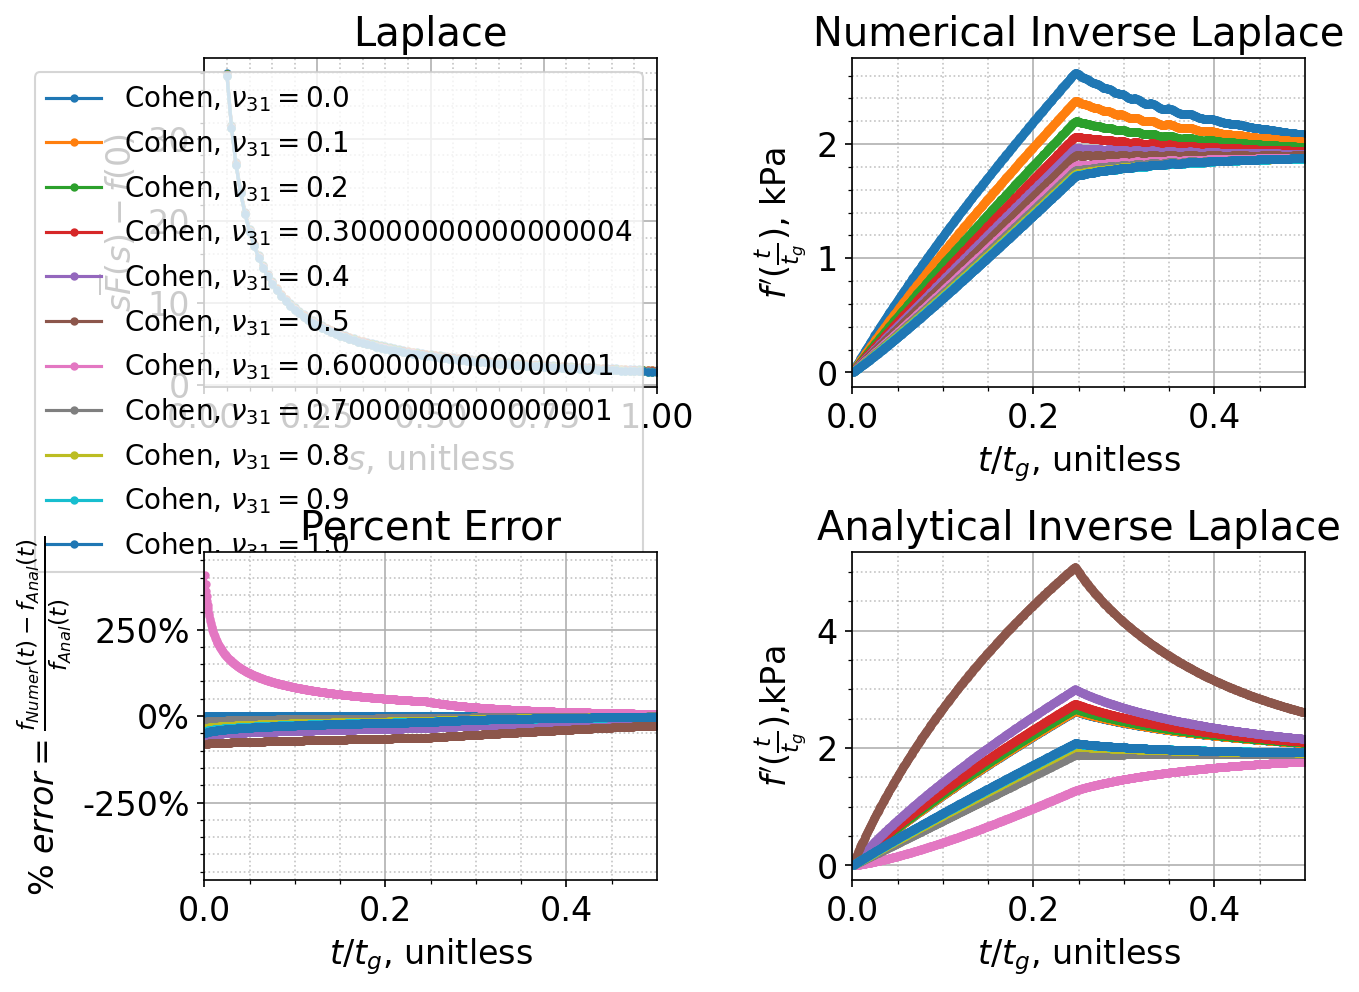

In [ ]:
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

v31_val = 0.293  #@param {type:"number"}
v31_vals = np.array([0.5, 0.707, v31_val])
v31_vals = np.linspace(0,1,11,endpoint=True)
#v31_vals=[0.707]
#v31_vals=[0.25, 0.707]
v31_vals.sort()
VPEs = [(getCohenModelModified(v31=v31_val), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

tg = VPEs[0][0].tg


# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 0.5, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
input_times_anal = input_times
plot_times_anal = plot_times/tg
func = [vpe.laplace_value for vpe, label in VPEs]
#func = [ (lambda s: s*vpe.laplace_value(s, eps_zz=vpe.strain_rate * tg  / (s*s) - vpe.inverted_value(0) ))           for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs] 
func_labels = [label for vpe, label in VPEs]
plot_props = {
    "t":        {"y":{"name":r"$f'(\frac{t}{t_g})$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$s\overline{F}(s)-f(0)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$f'(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False, #plot_mode="simple",
    func_labels = func_labels)

for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    itemindex = np.abs(input_times/vpe.tg - vpe.t0_tg).argmin()
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{plot_props['s']['y']['name'].replace('$','')}={laplace_vals[0]*input_s[0]:.3f}"))


df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

<IPython.core.display.Javascript object>

It took 0.0043 sec to evaluate the Laplace space func for 1097 input s vals.
It took 0.8416 sec to numerically invert Laplace the func for 1001 input times.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:2817: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


t0_tg     tg  ...        C1         C2
CohenModelModified - Line #1  0.246184  40.62  ...  9.555425  27.055604
CohenModelModified - Line #2  0.246184  40.62  ...  7.823529   7.823529
CohenModelModified - Line #3  0.246184  40.62  ...  6.302250  19.790928

[3 rows x 17 columns]

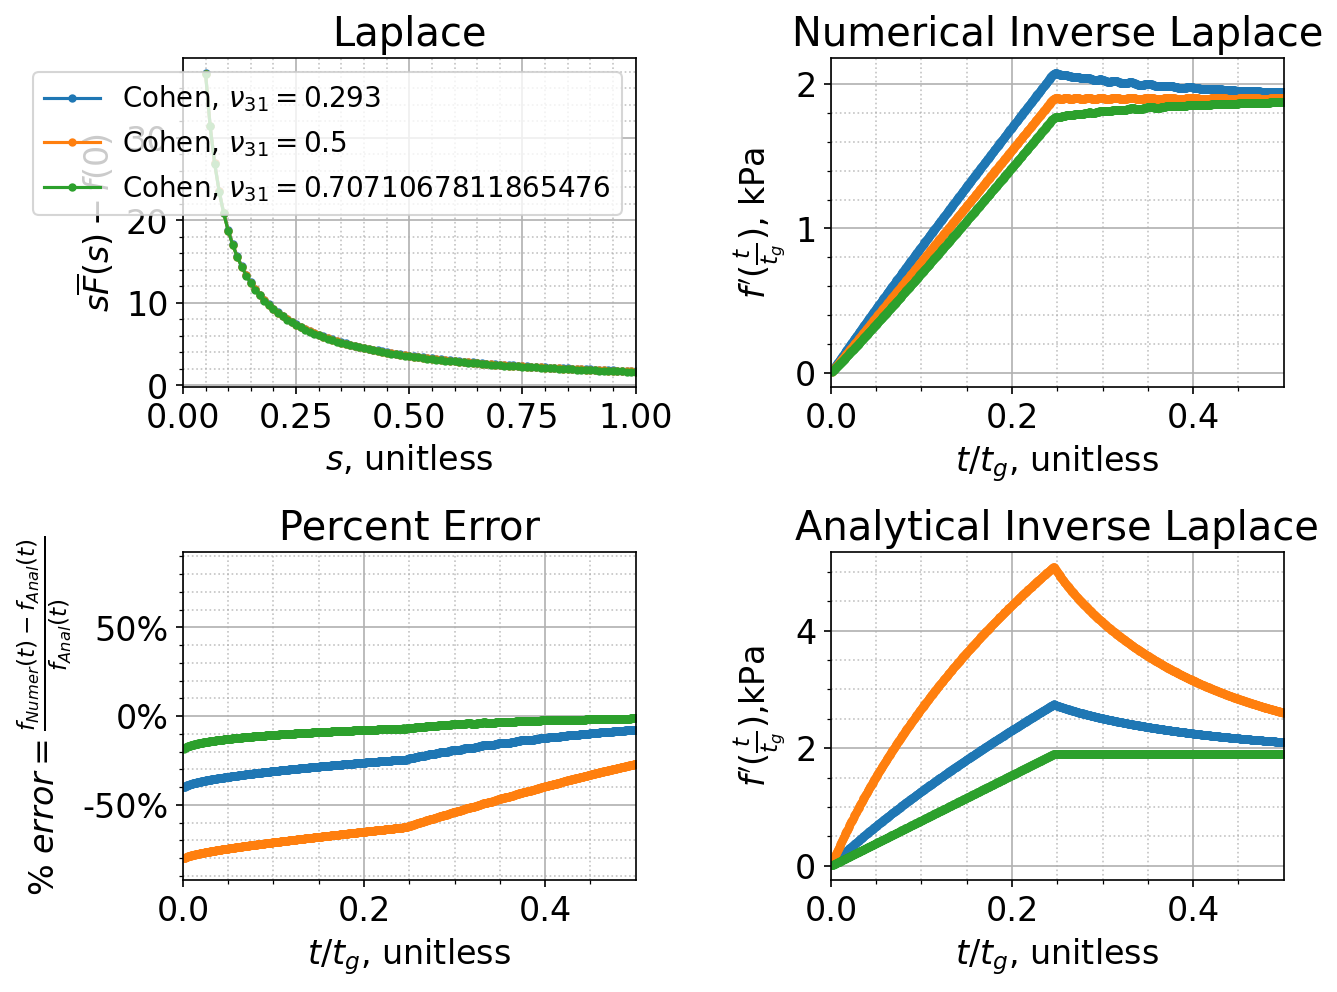

In [ ]:
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

v31_val = 0.293  #@param {type:"number"}
v31_vals = np.array([0.5, np.sqrt(0.5), v31_val])
#v31_vals = np.linspace(0,1,11,endpoint=True)
v31_vals.sort()
VPEs = [(getCohenModelModified(v31=v31_val), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

tg = VPEs[0][0].tg


# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 0.5, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
input_times_anal = input_times
plot_times_anal = plot_times/tg
func = [vpe.laplace_value for vpe, label in VPEs]
#func = [ (lambda s: s*vpe.laplace_value(s, eps_zz=vpe.strain_rate * tg  / (s*s) - vpe.inverted_value(0) ))           for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs] 
func_labels = [label for vpe, label in VPEs]
plot_props = {
    "t":        {"y":{"name":r"$f'(\frac{t}{t_g})$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$s\overline{F}(s)-f(0)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$f'(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False, #plot_mode="simple",
    func_labels = func_labels)

df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

#### Constraints: $\left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \neq 0 $


------
\begin{align}
1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} &= 0  \\
2\nu_{31}^2\frac{E_1}{E_3} &= \nu_{21} -1  \\
\nu_{31}^2 &= \left(\frac{\nu_{21}-1}{2}\right) \cdot \frac{E_1}{E_3}  \\
\nu_{31} &= \pm \sqrt { \frac{\nu_{21}-1}{2}  \cdot  \frac{E_1}{E_3} } \\
\end{align}
This would make $\Delta_1=0$, and thus $C_{11}$ and $C_{12}$ would be undefined

------
\begin{align}
1-\nu_{31}^2 \frac{E_1}{E_3} &= 0  \\
\nu_{31}^2 \frac{E_1}{E_3} &= 1  \\
\nu_{31}&= \pm \sqrt{\frac{E_3}{E_1}}  \\
\end{align}

#### $C_1\!-\!C_2C_0$ in terms of $\nu$, $E$, etc
##### Proof

\begin{align}
&C_1-C_2 C_0 = 
\\
&\qquad \overbrace{\left( 1+\nu_{21} \right)  \frac{ \color{green}{ \left( 1-4\nu_{31} + \color{teal}{2\frac{E_3}{E_1}\left(1-\nu_{21}\right)} \right) } }{ 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} }}^{C_1} 
- \overbrace{ 2 \left( 1+\nu_{21} \right) \frac{ \scriptstyle
\frac{E_3}{E_1} \left( 1-\nu_{21} \right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) 
\quad + \color{red}{ \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \left(1-4\nu_{31} \right) }
\quad +2\nu_{31}^2 \left( 1+\nu_{21} \right) 
}{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) }  }^{C_2 \times C_0}  
\tag{A}  
\\
=& \left( 1+\nu_{21} \right) \frac{ \textstyle
\color{green}{ \left( 1-4\nu_{31} + \color{teal}{2\frac{E_3}{E_1}\left(1-\nu_{21}\right)} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) }
\quad- 2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) 
\quad\color{red}{- 2 \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \left(1-4\nu_{31} \right) }
\quad-4\nu_{31}^2 \left( 1+\nu_{21} \right) }
{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) } 
\tag{B}  
\\
=& \left( 1+\nu_{21} \right) \frac{
\color{green}{ \left( 1-4\nu_{31} + \color{teal}{2\frac{E_3}{E_1}\left(1-\nu_{21}\right)} \color{red}{-2 \left(1-4\nu_{31} \right) } \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) } 
\quad-2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) 
\quad-4\nu_{31}^2 \left( 1+\nu_{21} \right) }
{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) } 
\tag{C}  
\\
=& \left( 1+\nu_{21} \right) \frac{
\color{green}{ \left( 1-4\nu_{31} + \color{teal}{2\frac{E_3}{E_1}\left(1-\nu_{21}\right)} \color{red}{ -2 + 8\nu_{31}  } \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) }
\quad-2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) 
\quad-4\nu_{31}^2 \left( 1+\nu_{21} \right) }
{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) } 
\tag{D}  
\\
=& \left( 1+\nu_{21} \right) \frac{
\left( -1+4\nu_{31} + \color{teal}{2\frac{E_3}{E_1}\left(1-\nu_{21}\right)} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad- 2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) 
\quad- 4\nu_{31}^2 \left( 1+\nu_{21} \right) }
{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) } 
\tag{E1}  
\\
=& \left( 1+\nu_{21} \right) \frac{
\left( -1+4\nu_{31} + \color{teal}{2\frac{E_3}{E_1} \left( 1-\nu_{21} \right) } \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad- 2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) 
\quad- 4\nu_{31}^2 \left( 1+\nu_{21} \right) }
{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) } 
\tag{E2}  
\\
=& \left( 1+\nu_{21} \right) \frac{ 
-\left( 1-4\nu_{31} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad + \color{teal}{2 \frac{E_3}{E_1} \left( 1-\nu_{21} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right)}
\quad -2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3}  \right) 
\quad -4\nu_{31}^2 \left( 1+\nu_{21} \right) }
{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) } 
\tag{F}  
\\
=& \left( 1+\nu_{21} \right) \frac{ 
-\left( 1-4\nu_{31} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad -2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \color{teal}{-\left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right)} \right) 
\quad -4\nu_{31}^2 \left( 1+\nu_{21} \right) }
{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) } 
\tag{G}  
\\
=& \left( 1+\nu_{21} \right) \frac{ 
-\left( 1-4\nu_{31} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad -2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \left( -\nu_{21}- \nu_{31}^2\frac{E_1}{E_3} \right) 
\quad -4\nu_{31}^2 \left( 1+\nu_{21} \right) }
{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) } 
\tag{H}  
\\
=& \left( 1+\nu_{21} \right) \frac{ 
\phantom{+}\left(4\nu_{31}-1\right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad +2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \left( \nu_{21}+\nu_{31}^2\frac{E_1}{E_3} \right) 
\quad -4\nu_{31}^2 \left( 1+\nu_{21} \right) }
{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) } 
\tag{I}  
\\
=& \frac{ 1+\nu_{21} }{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) } 
\underbrace{\left[
\left(4\nu_{31}-1\right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad +2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \left( \nu_{21}+\nu_{31}^2\frac{E_1}{E_3} \right) 
\quad -4\nu_{31}^2 \left( 1+\nu_{21} \right) \right]}_{\text{Cubic equation with respect to $\nu_{31}$; linear with respect to $\nu_{21}$}}
\tag{J}  
\end{align}


Fill in rearranged cubic form (rearrangement done and numerically confirmed in different cell.  
\begin{align}
C_2 C_0 - C_1 =& \frac{ 1+\nu_{21} }{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) } 
\underbrace{\left(
4\frac{E_1}{E_3}  \nu_{31}^3
\quad +\left(6\nu_{21} - \frac{E_1}{E_3} +2 \right) \nu_{31}^2 
\quad -4\nu_{31}
\quad -2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{21} +1 
\right)}_{\text{Cubic equation with respect to $\nu_{31}$; linear with respect to $\nu_{21}$}}
\tag{J}  
\end{align}

###### Rearranging cubic in terms of $\nu_{31}$

$$\phantom{ \begin{align}
\frac{C_1-C_2 C_0}{ \left. \left( 1+\nu_{21} \right) \middle/ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) \right. } \\ 
\end{align} }$$

$(C_1-C_2 C_0) \frac{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) }{ 1+\nu_{21} }  \\ $

\begin{align}
&=
\quad\left(4\nu_{31}-1\right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad +2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \left( \nu_{21}+\nu_{31}^2\frac{E_1}{E_3} \right) 
\quad -4\nu_{31}^2 \left( 1+\nu_{21} \right) \tag{N} \\
&=
\quad\left(4\nu_{31}-1\right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad +2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{21}
\, +2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{31}^2\frac{E_1}{E_3} 
\quad -4\nu_{31}^2 \left( 1+\nu_{21} \right) \tag{O} \\
&=
\quad\left(4\nu_{31}-1\right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad +2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{21}
\, +2 \nu_{31}^2  \left( 1-\nu_{21}\right) 
\quad -4\nu_{31}^2 \left( 1+\nu_{21} \right) \tag{P} \\
&=
\quad\left(4\nu_{31}-1\right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad +2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{21}
\quad +2 \nu_{31}^2  \left( \left( 1-\nu_{21}\right) -2\left( 1+\nu_{21} \right) \right) \tag{Q} \\
&=
\quad\left(4\nu_{31}-1\right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad +2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{21}
\quad +2 \nu_{31}^2  \left( 1-\nu_{21} -2-2\nu_{21} \right) \tag{R} \\
&=
\quad\left(4\nu_{31}-1\right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad +2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{21}
\quad -2 \nu_{31}^2 \left( 1+3\nu_{21} \right) \tag{S} \\
&=
\quad 4\nu_{31}\left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad -\left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) 
\quad +2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{21}
\quad -2 \nu_{31}^2 \left( 1+3\nu_{21} \right) \tag{T} \\
&=
\quad 4\nu_{31} 
\; -4\nu_{31}^3 \frac{E_1}{E_3} 
\quad -1 
\; +\nu_{31}^2 \frac{E_1}{E_3}
\quad +2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{21}
\quad -2 \nu_{31}^2 \left( 1+3\nu_{21} \right) \tag{U} \\
&=
-4\nu_{31}^3 \frac{E_1}{E_3} 
-2 \nu_{31}^2 \left( 1+3\nu_{21} \right)  +\nu_{31}^2 \frac{E_1}{E_3}
+4\nu_{31}
+2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{21} -1 \tag{V} \\
&=
-4\nu_{31}^3 \frac{E_1}{E_3} 
-\nu_{31}^2 \left(2 +6\nu_{21} - \frac{E_1}{E_3} \right)
+4\nu_{31}
+2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{21} -1 \tag{W} \\
&=
\quad -4\frac{E_1}{E_3}  \nu_{31}^3
\quad -\left(6\nu_{21} - \frac{E_1}{E_3} +2 \right) \nu_{31}^2 
\quad +4\nu_{31}
\quad +2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{21} -1 \tag{X} \\
\end{align}


$(C_2 C_0-C_1) \frac{ \left( 1-\nu_{21}-2\nu_{31}^2\frac{E_1}{E_3} \right) \left( 1-\nu_{31}^2 \frac{E_1}{E_3} \right) }{ 1+\nu_{21} } 
\quad
=
\quad 4\frac{E_1}{E_3}  \nu_{31}^3
\quad +\left(6\nu_{21} - \frac{E_1}{E_3} +2 \right) \nu_{31}^2 
\quad -4\nu_{31}
\quad -2\frac{E_3}{E_1} \left( 1-\nu_{21}\right) \nu_{21} +1  \\ $



###### Numerical verification

In [ ]:

print(*{
    " ": C1-C2*C0,
    "A": (1+v21)*(1-4*v31+2*(1-v21)*E3/E1)/(1-v21-2*v31*v31*E1/E3)-2*(1+v21)*(E3/E1*(1-v21)*(1-v21-2*v31*v31*E1/E3) + (1-v31*v31*E1/E3)*(1-4*v31) + 2*v31*v31*(1+v21) ) / ( (1-v21-2*v31*v31*E1/E3)**2 )*(1-v21-2*v31*v31*E1/E3)/(1-v31*v31*E1/E3),
    "A2":(1+v21)*(1-4*v31+2*(1-v21)*E3/E1)/(1-v21-2*v31*v31*E1/E3)-2*(1+v21)*(E3/E1*(1-v21)*(1-v21-2*v31*v31*E1/E3) + (1-v31*v31*E1/E3)*(1-4*v31) + 2*v31*v31*(1+v21) ) / ( (1-v21-2*v31*v31*E1/E3)*(1-v31*v31*E1/E3) ),
    "B": (1+v21)*((1-4*v31+2*(1-v21)*E3/E1)*(1-v31*v31*E1/E3)-2*(E3/E1*(1-v21)*(1-v21-2*v31*v31*E1/E3) + (1-v31*v31*E1/E3)*(1-4*v31) + 2*v31*v31*(1+v21) )) / ( (1-v21-2*v31*v31*E1/E3)*(1-v31*v31*E1/E3) ),
    "B2": (1+v21)*( (1-4*v31+2*(1-v21)*E3/E1)*(1-v31*v31*E1/E3) -2*E3/E1*(1-v21)*(1-v21-2*v31*v31*E1/E3) -2*(1-v31*v31*E1/E3)*(1-4*v31) -4*v31*v31*(1+v21) ) / ( (1-v21-2*v31*v31*E1/E3)*(1-v31*v31*E1/E3) ),
    "C": (1+v21)*( (1-4*v31+2*(1-v21)*E3/E1 -2*(1-4*v31))*(1-v31*v31*E1/E3) -2*E3/E1*(1-v21)*(1-v21-2*v31*v31*E1/E3) -4*v31*v31*(1+v21) ) / ( (1-v21-2*v31*v31*E1/E3)*(1-v31*v31*E1/E3) ),
    "D": (1+v21)*( (1-4*v31+2*(1-v21)*E3/E1 -2+8*v31)*(1-v31*v31*E1/E3) -2*E3/E1*(1-v21)*(1-v21-2*v31*v31*E1/E3) -4*v31*v31*(1+v21) ) / ( (1-v21-2*v31*v31*E1/E3)*(1-v31*v31*E1/E3) ),
    "E": (1+v21)*( (-1+4*v31+2*(1-v21)*E3/E1)*(1-v31*v31*E1/E3) -2*E3/E1*(1-v21)*(1-v21-2*v31*v31*E1/E3) -4*v31*v31*(1+v21) ) / ( (1-v21-2*v31*v31*E1/E3)*(1-v31*v31*E1/E3) ),
    "F": (1+v21)*( -(1-4*v31)*(1-v31*v31*E1/E3) +2*(1-v21)*E3/E1*(1-v31*v31*E1/E3) -2*E3/E1*(1-v21)*(1-v21-2*v31*v31*E1/E3) -4*v31*v31*(1+v21) ) / ( (1-v21-2*v31*v31*E1/E3)*(1-v31*v31*E1/E3) ),
    "G": (1+v21)*( -(1-4*v31)*(1-v31*v31*E1/E3) -2*E3/E1*(1-v21)*(1-v21-2*v31*v31*E1/E3-(1-v31*v31*E1/E3)) -4*v31*v31*(1+v21) ) / ( (1-v21-2*v31*v31*E1/E3)*(1-v31*v31*E1/E3) ),
    "H": (1+v21)*( -(1-4*v31)*(1-v31*v31*E1/E3) -2*E3/E1*(1-v21)*(-v21-v31*v31*E1/E3) -4*v31*v31*(1+v21) ) / ( (1-v21-2*v31*v31*E1/E3)*(1-v31*v31*E1/E3) ),
    "I": (1+v21)*( (4*v31-1)*(1-v31*v31*E1/E3) +2*E3/E1*(1-v21)*(v21+v31*v31*E1/E3)  -4*v31*v31*(1+v21) ) / ( (1-v21-2*v31*v31*E1/E3)*(1-v31*v31*E1/E3) ),
}.items(), sep="\n" )




<IPython.core.display.Javascript object>

(' ', 8.855415632392415)
('A', 8.85541563239231)
('A2', 8.855415632392308)
('B', 8.85541563239231)
('B2', 8.855415632392308)
('C', 8.855415632392308)
('D', 8.855415632392308)
('E', 8.855415632392308)
('F', 8.855415632392308)
('G', 8.855415632392308)
('H', 8.855415632392308)
('I', 8.855415632392308)
('I2', 8.855415632392308)


In [ ]:
print(*{
    " ": (C1-C2*C0) * ( (1-v21-2*v31*v31*E1/E3)*(1-v31*v31*E1/E3) )/(1+v21),
    "N": (4*v31-1)*(1-v31*v31*E1/E3) -2*E3/E1*(1-v21)*(-v21-v31*v31*E1/E3) -4*v31*v31*(1+v21) ,
    "S": (4*v31-1)*(1-v31**2*E1/E3) + 2*E3/E1*(1-v21)*v21 -2*v31*v31*(1+3*v21),
    "X": -4*v31**3*E1/E3   -v31**2*(6*v21-E1/E3+2)   +4*v31    +2*E3/E1*(1-v21)*v21-1,
    "X+": 4*v31**3*E1/E3   +v31**2*(6*v21-E1/E3+2)   -4*v31    -2*E3/E1*(1-v21)*v21+1,
}.items(), sep="\n" )


<IPython.core.display.Javascript object>

(' ', -0.08070448041709408)
('N', -0.0807044804170931)
('S', -0.08070448041709288)
('X', -0.08070448041709322)
('X+', 0.08070448041709322)


###### Plot cubic

In [ ]:
v31_val = np.sqrt(0.3)
v31_vals = np.array([v31_val])
#v31_vals = np.array([0.5, np.sqrt(0.5), v31_val])
#v31_vals = np.linspace(0,1,11,endpoint=True)
v31_vals.sort()
VPEs = [(getCohenModelModified(v31=v31_val), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

for vpe, label in VPEs:
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    v31sq = v31*v31
    delta1, delta2, delta3, C11, C12, C13, C33, C0, C1, C2 = vpe.get_calculable_constants()


  

<IPython.core.display.Javascript object>

t0_tg     tg  ...        C1         C2
CohenModelModified - Line #1  0.246184  40.62  ...  6.958101  89.173775

[1 rows x 17 columns]

In [ ]:
def constraints(v31=v31, v21=v21, E1=E1, E3=E3,):
    return [
            1-v21-2*v31*v31*E1/E3,
            1-v31*v31*E1/E3,
            1+v21,
    ]

def cubic_formula(v21=v21, E1=E1, E3=E3,):
    cubic = -np.array([4*E1/E3,   +(6*v21-E1/E3+2),   -4,    -2*E3/E1*(1-v21)*v21+1])
    return cubic

def get_cubic(v31=np.array(v31), v21=v21, E1=E1, E3=E3, other_parts=False):
    #cubic = -(4*v31**3*E1/E3   +v31**2*(6*v21-E1/E3+2)   -4*v31    -2*E3/E1*(1-v21)*v21+1)
    print(cubic_formula().shape)
    if isinstance(v31, np.ndarray):
        v31 = v31[...,None]
    cubic = cubic_formula() *  (v31**np.flip(np.array(4)))
    if other_parts:
        return np.sum( cubic * (1+v21)/( (1-v21-2*v31*v31*E1/E3)*(1-v31*v31*E1/E3) ), axis=-1  )
    else:
        return np.sum( cubic, axis=-1 )

get_cubic(np.array([1,2]))
np.roots(cubic_formula())

<IPython.core.display.Javascript object>

(4,)


array([-3.95352859,  0.52785891,  0.04331674])

In [ ]:
cubic=np.array([1,2,3,4])
v31_vals = np.array([5,10])

np.sum(cubic * v31_vals[...,None]**np.arange(4), -1)



<IPython.core.display.Javascript object>

array([ 586, 4321])

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


(4,)
(4,)
(-3.9535285866284986, nan) [-13.73508425525834, -5.99254212762917, 1.75]
(0.5278589102619979, 0.660284239623134) [0.0006949739246984998, 0.8753474869623492, 1.75]
(0.04331673519003027, 4894.825482308438) [0.24832116987853187, 0.999160584939266, 1.75]
(4,)


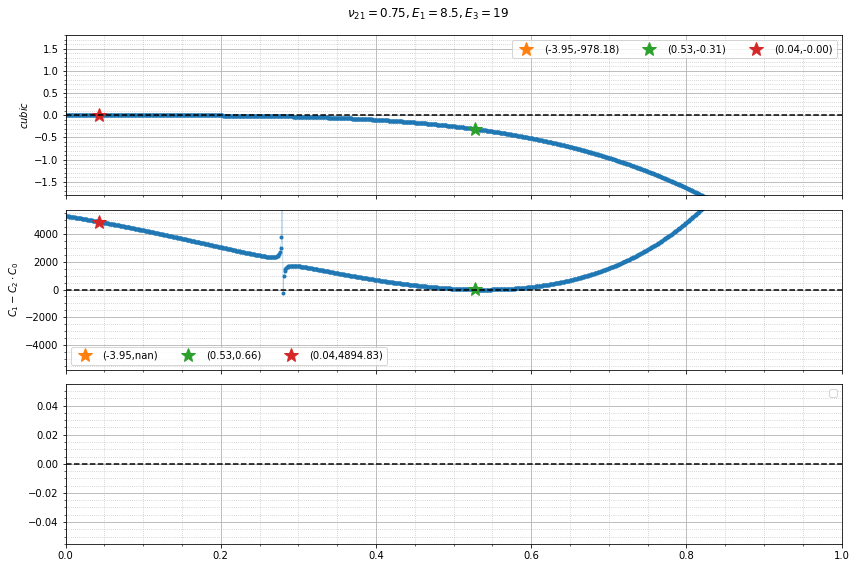

In [ ]:
import scipy.optimize

v31_vals = np.linspace(0,1,num=1000,endpoint=True)





fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex=True)
outputs = [(get_cubic,"cubic"), (get_C1_C2C0,r"C_1-C_2\cdot C_0")
           ]
for ind in range(len(outputs)):
    output_calculated = outputs[ind][0](v31_vals)
    axes.flat[ind].plot(v31_vals, output_calculated,".-",lw=0.25,label=None);
    search_range = v31_vals[np.array([np.argmin(output_calculated), np.argmax(output_calculated)])]

    #zero_inputs = scipy.optimize.fsolve(outputs[ind][0],0.6)
    #zero_inputs = v31_vals[np.argmin( np.abs(outputs[ind][0](v31_vals)) )]

    #zero_inputs = scipy.optimize.brentq(get_cubic, *search_range)

    zero_inputs =     np.roots(cubic_formula())

    zero_vals = outputs[ind][0](zero_inputs)


    
    for ind2 in range(len(zero_inputs)):
        z = zero_inputs[ind2]
        axes.flat[ind].plot(zero_inputs[ind2],zero_vals[ind2],"*",label=f"({zero_inputs[ind2]:.2f},{zero_vals[ind2]:.2f})",ms=15)
        if ind==1:
            print( (z,zero_vals[ind2]), constraints(v31=z) )


for ind,ax in enumerate(axes.flat):
    #ax.set_yscale("symlog",linthresh=200)
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.set_xlim([np.min(v31_vals),np.max(v31_vals)])
    ax.legend(ncol=3) #framealpha=0.5,
    if ind<len(outputs):
        #ax.set_ylim( np.percentile( outputs[ind][0](v31_vals), [1,99] ) )
        ax.set_ylim( np.percentile( np.abs(outputs[ind][0](v31_vals)), 80 ) * np.array([-1.1,1.1]) )
        ax.set_ylabel(f"${outputs[ind][1]}$")
    ax.plot(v31_vals, np.zeros_like(v31_vals), "k--")
    


#for lower_ax in axes[-1,:]:
#    lower_ax.set_xlabel(r"$\nu_{31}$",fontsize=16,fontweight="bold")
plt.suptitle(r"$\nu_{21}"+f"={v21}, E_1={E1}, E_3={E3}$")
# rect=[left, bottom, right, top] in normalized [0, 1] figure coordinates,
# default rect via fig.tight_layout() is (0, 0, 1, 1)
fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.95])

## Finding the effect of parameters on K, the correction factor (aka derivative ratio)

In [ ]:
if param_name_latex is None:
    param_name_latex = param_name
VPEs = [(getCohenModelModified(**{param_name:param_val}), f"Cohen, ${param_name_latex}={np.round(param_val,2)}$") for param_val in param_vals]

plot_times_tg = np.linspace(0.001, 0.5, num=11, endpoint=True)

inverted_values_analy = np.full((len(len(VPEs),plot_times_tg)),np.nan)  #[None] * len(VPEs)
inverted_values_numer = np.full((len(len(VPEs),plot_times_tg)),np.nan)
discrepancy_ratios    = np.full((len(len(VPEs),plot_times_tg)),np.nan)
for ind, (vpe, name) in enumerate(VPEs):
        t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
        A = E3 * strain_rate * tg
        clipped_time = np.clip(plot_times_tg, 0, t0_tg)
        inverted_values_analy[ind] = vpe.inverted_value(plot_times_tg*tg) 
        inverted_values_numer[ind] = inverting.euler_inversion(vpe.laplace_value, plot_times_tg)
        discrepancy_ratios[ind]    = (inverted_values_analy[ind]-A*clipped_time) / (inverted_values_numer[ind]-A*clipped_time) 

zoomed_range = np.mean(discrepancy_ratios)+np.std(discrepancy_ratios)*np.array([-1,1])

discrepancy_ratios[ind].shape
len(VPEs)

<IPython.core.display.Javascript object>

100

In [ ]:
np.nanmedian(discrepancy_ratios)
np.nanquantile(discrepancy_ratios,[0.2,0.8])

<IPython.core.display.Javascript object>

array([3.23370619, 3.27219028])

In [ ]:
#@title def plot_cohen_effect(...)
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)

def plot_cohen_effect(param_name, param_vals, param_name_latex=None, show_legend=True):
    param_vals = np.array(param_vals)
    param_max = np.nanmax(param_vals)
    if param_name_latex is None:
        param_name_latex = param_name
    VPEs = [(getCohenModelModified(**{param_name:param_val}), f"Cohen, ${param_name_latex}={np.round(param_val,2)}$") for param_val in param_vals]

    plot_times_tg = np.linspace(0.001, 0.5, num=11, endpoint=True)

    inverted_values_analy = np.full((len(VPEs),len(plot_times_tg)),np.nan)  #[None] * len(VPEs)
    inverted_values_numer = np.full((len(VPEs),len(plot_times_tg)),np.nan)
    discrepancy_ratios    = np.full((len(VPEs),len(plot_times_tg)),np.nan)
    for ind, (vpe, name) in enumerate(VPEs):
            t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
            A = E3 * strain_rate * tg
            clipped_time = np.clip(plot_times_tg, 0, t0_tg)
            inverted_values_analy[ind] = vpe.inverted_value(plot_times_tg*tg) 
            inverted_values_numer[ind] = inverting.euler_inversion(vpe.laplace_value, plot_times_tg)
            discrepancy_ratios[ind]    = (inverted_values_analy[ind]-A*clipped_time) / (inverted_values_numer[ind]-A*clipped_time) 

    #zoomed_range = np.nanmean(discrepancy_ratios)+np.nanstd(discrepancy_ratios)*np.array([-1,1])
    zoomed_range = np.nanquantile(discrepancy_ratios,[0.05,0.95])

    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8*2,4))
    # show zoom in box window (the dims of right subplot) on the left subplot
    axes.flat[0].plot([0,param_max,param_max,0], 
                      zoomed_range[np.array([0,0,-1,-1])],"k--",
                      dashes=tuple(np.array([4,6])*param_max*0.04),  # (length, spacing)
                      )
    # Plot value of guess for correction equation
    if param_name != "v31" and np.isclose(VPEs[0][0].v31,VPEs[-1][0].v31):
        v31 = VPEs[0][0].v31
        K = (1-2*v31**2)/(1-2*v31)**2
        axes.flat[1].plot([0,param_max], 
                      [K,K],"kx-",markersize=12)
    
    for ax in axes.flat:  
        #for ind, time_tg in enumerate(plot_times_tg):
        lines = ax.plot(param_vals, discrepancy_ratios, ".", alpha=0.75)
        """for ind, (vpe, name) in enumerate(VPEs): 
            lines = ax.plot(np.full_like(discrepancy_ratios[ind].T, fill_value=param_vals[ind]),
                            discrepancy_ratios[ind],".", label=name)
            #lines = ax.plot(param_vals[ind]*np.ones_like(discrepancy_ratios[ind]),discrepancy_ratios[ind],".", label=name)
        """

    r"""text = axes.flat[0].text(0.98,0.05, 
                             "\n".join([ (f"${name_latex}={const:5.2f}$" if param_name != name else f"${name_latex}"+r"=\cdots $")
                                      for const, name, name_latex in
                                      zip(VPEs[0][0].get_predefined_constants(),
                                          VPEs[0][0].get_predefined_constant_names(),
                                          VPEs[0][0].get_predefined_constant_names_latex())
                                      
                                      ]),
                    ha="right", va="bottom", color="k", 
                    bbox=dict(facecolor='w', alpha=1.0),
                    transform=axes.flat[0].transAxes, fontsize=12
                    )"""
    if np.nanmedian(discrepancy_ratios)*2 < np.nanmax(discrepancy_ratios):
        ystart, va = 0.95, "top"
    else:
        ystart, va = 0.05, "bottom"
    text = axes.flat[0].text(0.98,ystart, 
                             ",   ".join([ (f"${name_latex}={const:6.2f}$" if param_name != name else f"${name_latex}"+r"=\cdots $")
                                      for const, name, name_latex in
                                      zip(VPEs[0][0].get_predefined_constants(),
                                          VPEs[0][0].get_predefined_constant_names(),
                                          VPEs[0][0].get_predefined_constant_names_latex())
                                      
                                      ]),
                    ha="right", va=va, color="k", 
                    bbox=dict(facecolor='w', alpha=0.8),
                    transform=axes.flat[0].transAxes, fontsize=10,
                    )
    
    axes.flat[0].set_ylim([0,None])
    axes.flat[1].set_ylim(zoomed_range)
    axes.flat[0].set_title("Full view (dashed line is zoom window of right plot)")
    axes.flat[1].set_title("Zoomed in"+
                           (", "+r"Note- value of $K=(1-2\nu_{31}^2)/(1-2\nu_{31})^22="+f"{K:0.3f}$" if param_name != "v31"
                           else "")
                           )
    
    for ax in axes:
        ax.grid(which="major")  # set major grid lines
        ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        #ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")
        ax.set_xlim([0,param_max])
        ax.set_xlabel(f"${param_name_latex}$",fontsize=16,fontweight="bold")
    
    axes.flat[0].set_ylabel(r"""$(f(t)-A\varepsilon(t)) \div (f_{est}(t)-A\varepsilon(t))$""",
                    fontsize=16,fontweight="bold")

    if show_legend:
        # Shrink current axis by 20%
        box = axes.flat[-1].get_position()
        axes.flat[-1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        # Put a legend to the right of the current axis
        axes.flat[-1].legend(lines, [f"{t_tg:0.3f}" for t_tg in plot_times_tg], 
                    title="$t/t_g$", loc='center left', bbox_to_anchor=(1, 0.5), edgecolor="k")


    itemindex = np.abs(plot_times_tg - t0_tg).argmin()
    for ind, (vpe, label) in enumerate(VPEs):
            pass
            #display(vpe.get_var_df())
            #display(vpe.alpha2_vals)
    df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
    #display(df_params)
    fig.tight_layout()
    return fig, df_params, inverted_values_analy, inverted_values_numer


<IPython.core.display.Javascript object>

In [ ]:
vpe.get_predefined_constant_names()

<IPython.core.display.Javascript object>

('t0_tg', 'tg', 'strain_rate', 'E1', 'E3', 'v21', 'v31')

<IPython.core.display.Javascript object>

t0_tg     tg  ...          C1          C2
CohenModelModified - Line #1   0.246184  40.62  ...  334.402026  347.781102
CohenModelModified - Line #21  0.246184  40.62  ...   17.940802   34.366193
CohenModelModified - Line #41  0.246184  40.62  ...   10.472423   31.116644
CohenModelModified - Line #61  0.246184  40.62  ...    8.139006   34.863654
CohenModelModified - Line #81  0.246184  40.62  ...    7.222673   43.170427

[5 rows x 17 columns]

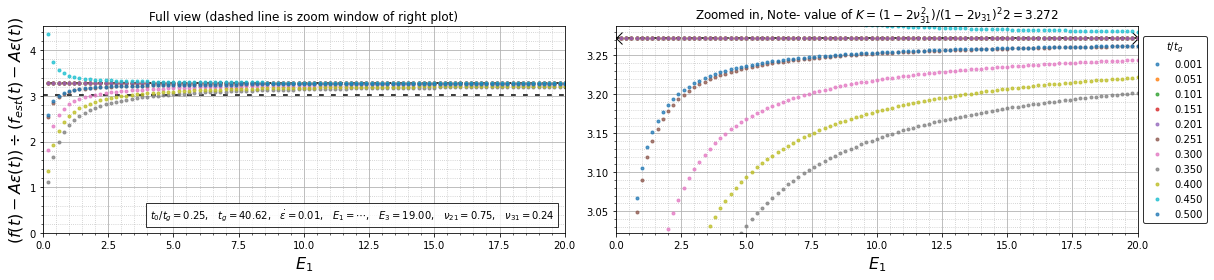

In [ ]:
#@title $E_1$
param_name, param_name_latex = "E1", "E_1"
param_vals = np.linspace(0.2,20,100,endpoint=True)
fig, df_params, inverted_values_analy, inverted_values_numer  \
    = plot_cohen_effect(param_name,param_vals, param_name_latex);
display(df_params.iloc[::20, :])  # show every xth row
plt.savefig(get_path_to_save(save_filename=f"K vs {param_name}", save_in_subfolder="Correction across varying params"), bbox_inches='tight')  # Include the bbox_inches='tight' is critical to ensure the saved images aren't cutoff while the colab images are normal

<IPython.core.display.Javascript object>

t0_tg     tg  ...         C1         C2
CohenModelModified - Line #1   0.246184  40.62  ...  -0.237166   1.320196
CohenModelModified - Line #26  0.246184  40.62  ...   7.158307  73.988888
CohenModelModified - Line #51  0.246184  40.62  ...   8.101105  35.026282
CohenModelModified - Line #76  0.246184  40.62  ...  10.276863  31.198114

[4 rows x 17 columns]

/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1289: RuntimeWarning: divide by zero encountered in true_divide
  for alpha2_N in alpha2_vals
/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1301: RuntimeWarning: invalid value encountered in true_divide
  for alpha2_N in alpha2_vals


t0_tg     tg  ...        C1        C2
CohenModelModified - Line #1   0.246184  40.62  ... -0.003887 -0.001671
CohenModelModified - Line #26  0.246184  40.62  ... -0.053658  0.133596
CohenModelModified - Line #51  0.246184  40.62  ... -0.150284  0.675079
CohenModelModified - Line #76  0.246184  40.62  ... -0.312356  1.968103

[4 rows x 17 columns]

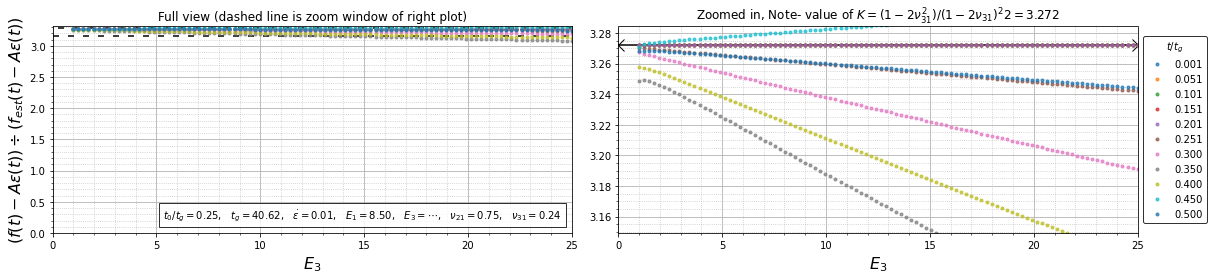

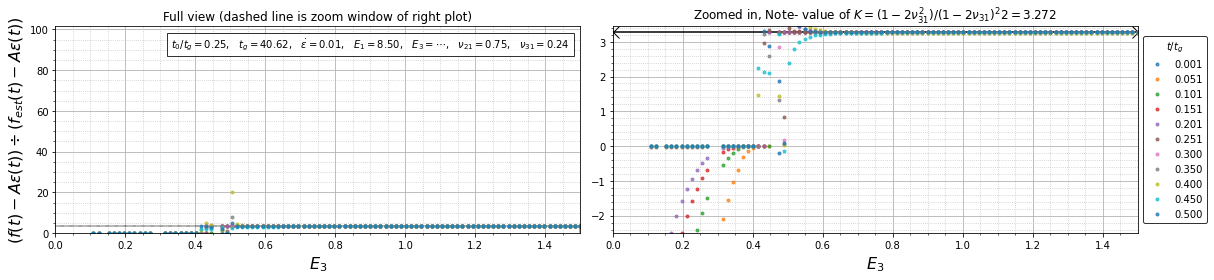

In [ ]:
#@title $E_3$
param_name, param_name_latex = "E3", "E_3"
param_vals = np.linspace(1,25,100,endpoint=True)
fig, df_params, inverted_values_analy, inverted_values_numer  \
    = plot_cohen_effect(param_name,param_vals, param_name_latex);
display(df_params.iloc[::25, :])  # show every xth row
plt.savefig(get_path_to_save(save_filename=f"K vs {param_name}, 1", save_in_subfolder="Correction across varying params"), bbox_inches='tight')  # Include the bbox_inches='tight' is critical to ensure the saved images aren't cutoff while the colab images are normal

#@title $E_3$
param_name, param_name_latex = "E3", "E_3"
param_vals = np.linspace(0.05,1.5,100,endpoint=True)
fig, df_params, inverted_values_analy, inverted_values_numer  \
    = plot_cohen_effect(param_name,param_vals, param_name_latex);
display(df_params.iloc[::25, :])  # show every xth row
plt.savefig(get_path_to_save(save_filename=f"K vs {param_name}, 1", save_in_subfolder="Correction across varying params"), bbox_inches='tight')  # Include the bbox_inches='tight' is critical to ensure the saved images aren't cutoff while the colab images are normal

<IPython.core.display.Javascript object>

t0_tg    tg  ...         C1         C2
CohenModelModified - Line #1   0.246184   1.0  ...  10.207851  31.232221
CohenModelModified - Line #21  0.246184  21.0  ...  10.207851  31.232221
CohenModelModified - Line #41  0.246184  41.0  ...  10.207851  31.232221
CohenModelModified - Line #61  0.246184  61.0  ...  10.207851  31.232221
CohenModelModified - Line #81  0.246184  81.0  ...  10.207851  31.232221

[5 rows x 17 columns]

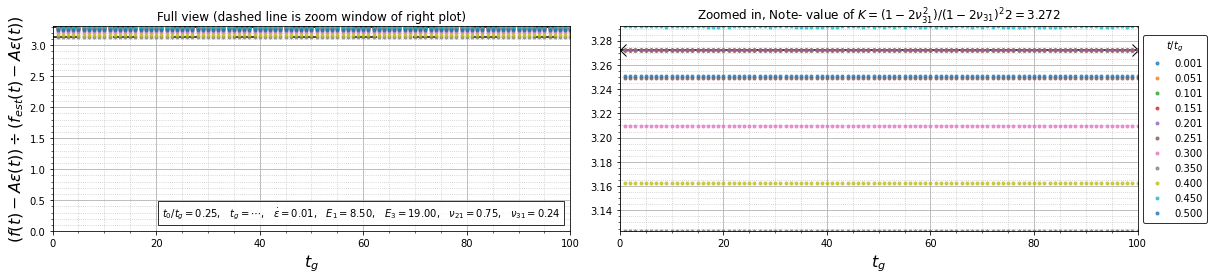

In [ ]:
#@title $t_g$
param_name, param_name_latex = "tg", "t_g"
param_vals = np.linspace(1,100,100,endpoint=True)
fig, df_params, inverted_values_analy, inverted_values_numer  \
    = plot_cohen_effect(param_name,param_vals, param_name_latex);
display(df_params.iloc[::20, :])  # show every xth row
plt.savefig(get_path_to_save(save_filename=f"K vs {param_name}", save_in_subfolder="Correction across varying params"), bbox_inches='tight')  # Include the bbox_inches='tight' is critical to ensure the saved images aren't cutoff while the colab images are normal

<IPython.core.display.Javascript object>

t0_tg     tg  ...         C1         C2
CohenModelModified - Line #1    0.020  40.62  ...  10.207851  31.232221
CohenModelModified - Line #21   0.416  40.62  ...  10.207851  31.232221
CohenModelModified - Line #41   0.812  40.62  ...  10.207851  31.232221
CohenModelModified - Line #61   1.208  40.62  ...  10.207851  31.232221
CohenModelModified - Line #81   1.604  40.62  ...  10.207851  31.232221
CohenModelModified - Line #101  2.000  40.62  ...  10.207851  31.232221

[6 rows x 17 columns]

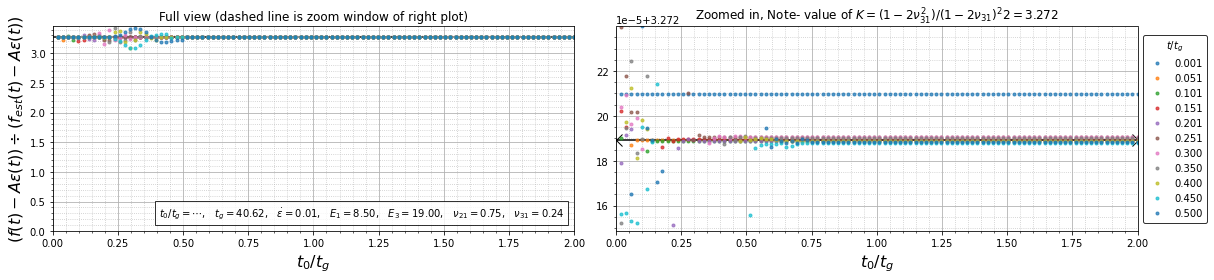

In [ ]:
#@title $t_0/t_g$
param_name, param_name_latex = "t0_tg", "t_0/t_g"
param_vals = np.linspace(0.02,2,101,endpoint=True)
fig, df_params, inverted_values_analy, inverted_values_numer  \
    = plot_cohen_effect(param_name,param_vals, param_name_latex);
display(df_params.iloc[::20, :])  # show every xth row
plt.savefig(get_path_to_save(save_filename=f"K vs {param_name}", save_in_subfolder="Correction across varying params"), bbox_inches='tight')  # Include the bbox_inches='tight' is critical to ensure the saved images aren't cutoff while the colab images are normal

<IPython.core.display.Javascript object>

t0_tg     tg  ...         C1         C2
CohenModelModified - Line #1    0.246184  40.62  ...  10.207851  31.232221
CohenModelModified - Line #21   0.246184  40.62  ...  10.207851  31.232221
CohenModelModified - Line #41   0.246184  40.62  ...  10.207851  31.232221
CohenModelModified - Line #61   0.246184  40.62  ...  10.207851  31.232221
CohenModelModified - Line #81   0.246184  40.62  ...  10.207851  31.232221
CohenModelModified - Line #101  0.246184  40.62  ...  10.207851  31.232221

[6 rows x 17 columns]

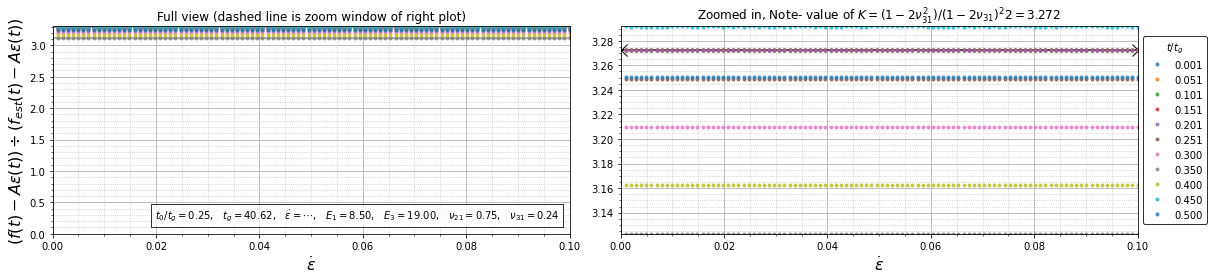

In [ ]:
#@title $\dot{\varepsilon}$, strain rate
param_name, param_name_latex = "strain_rate", r"\dot{\varepsilon}"
param_vals = np.linspace(0.001,0.1,101,endpoint=True)
fig, df_params, inverted_values_analy, inverted_values_numer  \
    = plot_cohen_effect(param_name,param_vals, param_name_latex);
display(df_params.iloc[::20, :])  # show every xth row
plt.savefig(get_path_to_save(save_filename=f"K vs {param_name}", save_in_subfolder="Correction across varying params"), bbox_inches='tight')  # Include the bbox_inches='tight' is critical to ensure the saved images aren't cutoff while the colab images are normal

<IPython.core.display.Javascript object>

t0_tg     tg  ...         C1         C2
CohenModelModified - Line #1   0.246184  40.62  ...   5.268210   5.722702
CohenModelModified - Line #11  0.246184  40.62  ...   6.260904   7.269105
CohenModelModified - Line #21  0.246184  40.62  ...   7.384592   9.899790
CohenModelModified - Line #31  0.246184  40.62  ...   8.881946  17.213093
CohenModelModified - Line #41  0.246184  40.62  ...  12.562751  82.883565

[5 rows x 17 columns]

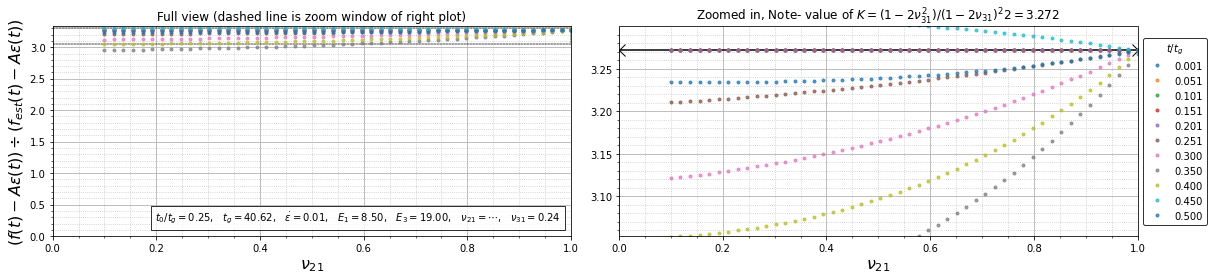

In [ ]:
#@title $\nu_{21}$
param_name, param_name_latex = "v21", r"\nu_{21}"
param_vals = np.linspace(0.1,1,50,endpoint=True)
fig, df_params, inverted_values_analy, inverted_values_numer  \
    = plot_cohen_effect(param_name,param_vals, param_name_latex);
display(df_params.iloc[::10, :])  # show every xth row
plt.savefig(get_path_to_save(save_filename=f"K vs {param_name}", save_in_subfolder="Correction across varying params"), bbox_inches='tight')  # Include the bbox_inches='tight' is critical to ensure the saved images aren't cutoff while the colab images are normal

<IPython.core.display.Javascript object>

t0_tg     tg  ...         C1         C2
CohenModelModified - Line #1   0.246184  40.62  ...  14.548736  61.642039
CohenModelModified - Line #11  0.246184  40.62  ...  12.275106  44.846663
CohenModelModified - Line #21  0.246184  40.62  ...  10.619645  33.860610
CohenModelModified - Line #31  0.246184  40.62  ...   9.364235  25.803105
CohenModelModified - Line #41  0.246184  40.62  ...   8.392837  18.396253
CohenModelModified - Line #51  0.246184  40.62  ...   7.864041  11.967041
CohenModelModified - Line #61  0.246184  40.62  ...   6.802206  28.353908
CohenModelModified - Line #71  0.246184  40.62  ...   6.287990  19.654664
CohenModelModified - Line #81  0.246184  40.62  ...   5.827605  16.191064
CohenModelModified - Line #91  0.246184  40.62  ...   5.426658  13.970670

[10 rows x 17 columns]

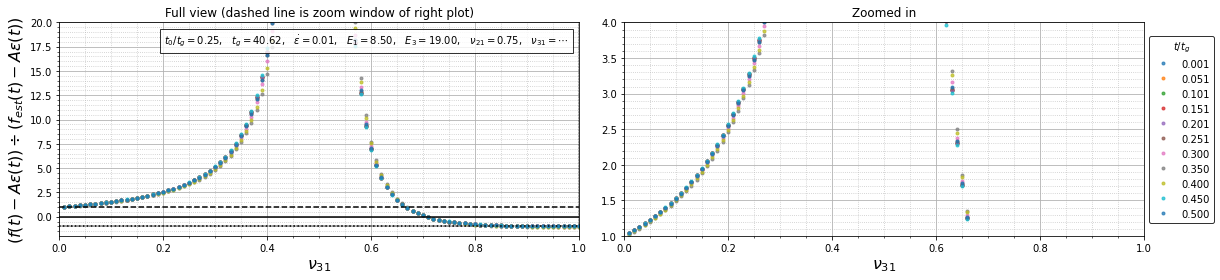

In [ ]:
#@title $\nu_{31}$
param_name, param_name_latex = "v31", r"\nu_{31}"
param_vals = np.linspace(0.01,1,100,endpoint=True)
fig, df_params, inverted_values_analy, inverted_values_numer  \
    = plot_cohen_effect(param_name,param_vals,param_name_latex);
fig.axes[0].set_ylim([-2,20])
fig.axes[0].plot([0,np.max(param_vals)],[0,0],"k")
fig.axes[0].plot([0,np.max(param_vals)],[1,1],"k--");
fig.axes[0].plot([0,np.max(param_vals)],[-1,-1],"k:");
fig.axes[1].set_ylim([1,4]);
display(df_params.iloc[::10, :])  # show every xth row
plt.savefig(get_path_to_save(save_filename=f"K vs {param_name}", save_in_subfolder="Correction across varying params"), bbox_inches='tight')  # Include the bbox_inches='tight' is critical to ensure the saved images aren't cutoff while the colab images are normal

In [ ]:
#inverted_values_numer
(1-param_vals**2*E1/E3)

<IPython.core.display.Javascript object>

array([0.99995526, 0.99982105, 0.99959737, 0.99928421, 0.99888158,
       0.99838947, 0.99780789, 0.99713684, 0.99637632, 0.99552632,
       0.99458684, 0.99355789, 0.99243947, 0.99123158, 0.98993421,
       0.98854737, 0.98707105, 0.98550526, 0.98385   , 0.98210526,
       0.98027105, 0.97834737, 0.97633421, 0.97423158, 0.97203947,
       0.96975789, 0.96738684, 0.96492632, 0.96237632, 0.95973684,
       0.95700789, 0.95418947, 0.95128158, 0.94828421, 0.94519737,
       0.94202105, 0.93875526, 0.9354    , 0.93195526, 0.92842105,
       0.92479737, 0.92108421, 0.91728158, 0.91338947, 0.90940789,
       0.90533684, 0.90117632, 0.89692632, 0.89258684, 0.88815789,
       0.88363947, 0.87903158, 0.87433421, 0.86954737, 0.86467105,
       0.85970526, 0.85465   , 0.84950526, 0.84427105, 0.83894737,
       0.83353421, 0.82803158, 0.82243947, 0.81675789, 0.81098684,
       0.80512632, 0.79917632, 0.79313684, 0.78700789, 0.78078947,
       0.77448158, 0.76808421, 0.76159737, 0.75502105, 0.74835

### Searching for a equation that describes K
Run this after running one of the above cells for a specific param

In [ ]:
(discrepancy_ratio.T/possible_fit).shape
param_vals.shape

<IPython.core.display.Javascript object>

(100,)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


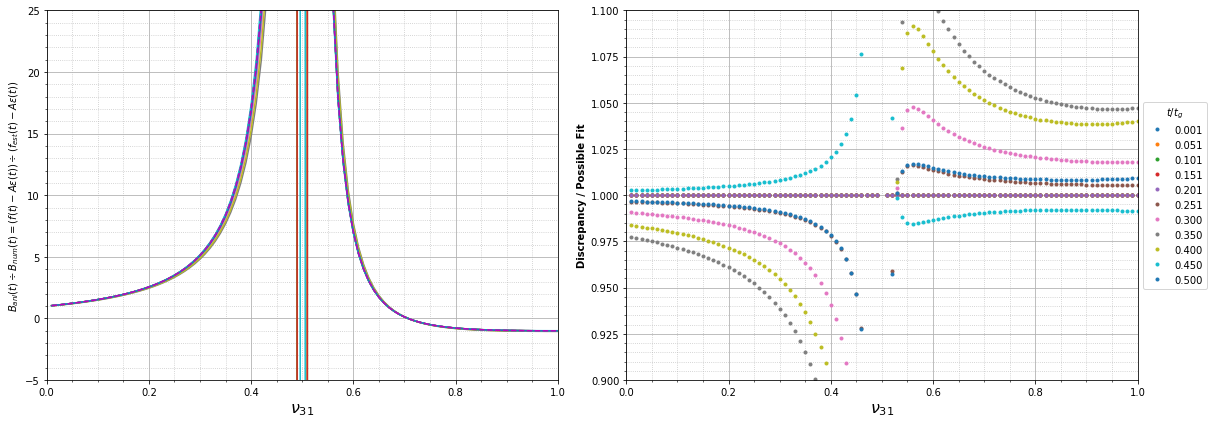

In [ ]:
#(1-2*v31)
#0.203713*10.207851/31.232221
#0.203713	10.207851	31.232221
#C0*C1/C2


VPEs = [(viscoporoelastic_model.CohenModel(), fr"$Cohen$") ]

t0_tg, tg, strain_rate, E1, E3, v21, v31 = VPEs[0][0].get_predefined_constants()
t0=t0_tg*tg
delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = VPEs[0][0].get_calculable_constants()

inverted_values_analy_np=np.vstack(inverted_values_analy)
inverted_values_numer_np=np.vstack(inverted_values_numer)
A = E3 * strain_rate * tg
plot_times_tg = np.linspace(0.001, 0.5, num=11, endpoint=True)

discrepancy_ratio = (inverted_values_analy_np-A*np.clip(plot_times_tg, 0, t0_tg))/(inverted_values_numer_np-A*np.clip(plot_times_tg, 0, t0_tg))
#possible_fit_ratio= (1-2*param_vals) 
#possible_fit_ratio= (1-v21-2*param_vals**2*E1/E3)
#possible_fit_ratio= (1-param_vals**2*E1/E3)
#possible_fit_ratio=(1-2*param_vals**2)
possible_fit_ratio = (1-2*param_vals**2)/(1-2*param_vals)**2

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
axs.flat[0].plot(param_vals, discrepancy_ratio )
axs.flat[0].plot(param_vals, possible_fit, "m--")
axs.flat[0].set_ylim([-5,25])
#B_{\text{anl}}(t)/B_{\text{num}}(t)=
axs.flat[0].set_ylabel(r"$B_{{anl}}(t) \div B_{{num}}(t)=(f(t)-A\varepsilon(t)) \div (f_{est}(t)-A\varepsilon(t))$", weight="bold")

lines = axs.flat[1].plot(param_vals, (discrepancy_ratio.T/possible_fit_ratio).T, "." )
#axs.flat[1].set_ylim([0.5,1.5])
axs.flat[1].set_ylim([0.9,1.1])

axs.flat[1].set_ylabel("Discrepancy / Possible Fit", weight="bold")

# Shrink current axis by 20%
box = axs.flat[1].get_position()
axs.flat[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
#axs.flat[1].legend([f"$t/t_g={t_tg:0.3f}$" for t_tg in plot_times_tg])
axs.flat[1].legend(lines,[f"{t_tg:0.3f}" for t_tg in plot_times_tg], title="$t/t_g$", loc='center left', bbox_to_anchor=(1, 0.5))

for ax in fig.axes:
        ax.grid(which="major")  # set major grid lines
        ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        #ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")
        ax.set_xlim([0,np.max(param_vals)])
        ax.set_xlabel(f"${param_name_latex}$",fontsize=16)
        
fig.tight_layout()

In [ ]:
discrepancy_ratio[...,5].shape

<IPython.core.display.Javascript object>

(100,)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Figure 1 placed on the right t/tg=0.001 at position +0.005
Figure 2 placed on the right t/tg=0.001 at position +0.995

Figure 1 placed on the right t/tg=0.051 at position +0.005
Figure 2 placed on the right t/tg=0.051 at position +0.995

Figure 1 placed on the right t/tg=0.101 at position +0.005
Figure 2 placed on the right t/tg=0.101 at position +0.995

Figure 1 placed on the right t/tg=0.151 at position +0.005
Figure 2 placed on the right t/tg=0.151 at position +0.995

Figure 1 placed on the right t/tg=0.201 at position +0.005
Figure 2 placed on the right t/tg=0.201 at position +0.995

Figure 1 placed on the right t/tg=0.251 at position +0.000
Figure 2 placed on the right t/tg=0.251 at position +1.000

Figure 1 placed on the right t/tg=0.300 at position -0.013
Figure 2 placed on the right t/tg=0.300 at position +1.012

Figure 1 placed on the left  t/tg=0.350 at position -0.020
Figure 2 is *missing* label for t/tg=0.350 at position +0.981

Figure 1 placed on the left  t/tg=0.400 at po

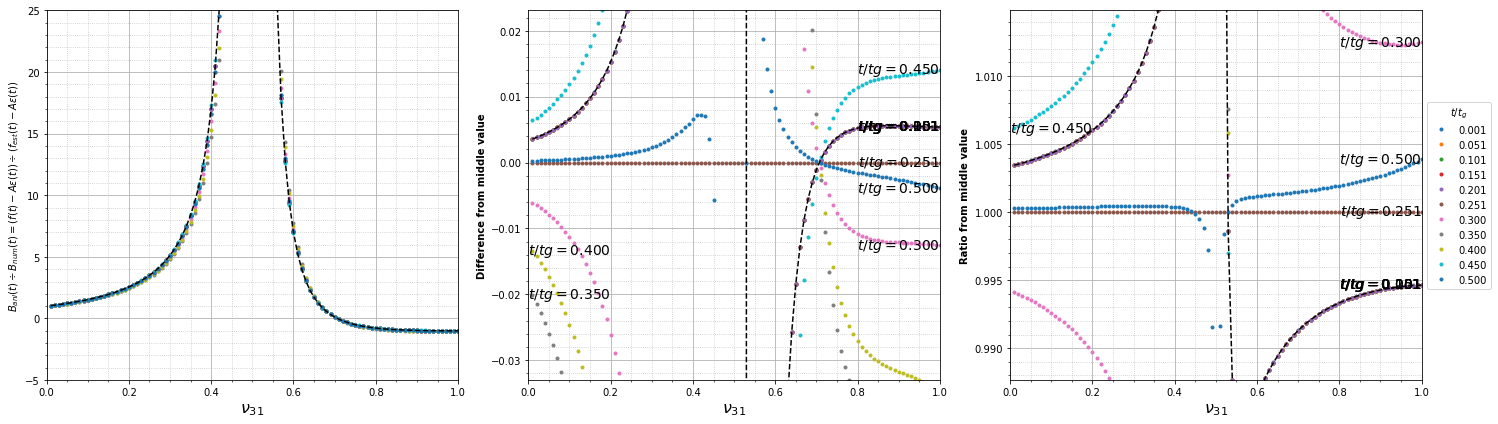

In [ ]:
inverted_values_analy_np=np.vstack(inverted_values_analy)
inverted_values_numer_np=np.vstack(inverted_values_numer)
A = E3 * strain_rate * tg
plot_times_tg = np.linspace(0.001, 0.5, num=11, endpoint=True)

discrepancy_ratio = (inverted_values_analy_np-A*np.clip(plot_times_tg, 0, t0_tg))/(inverted_values_numer_np-A*np.clip(plot_times_tg, 0, t0_tg))
#possible_fit_ratio= (1-2*param_vals) 
#possible_fit_ratio= (1-v21-2*param_vals**2*E1/E3)
#possible_fit_ratio= (1-param_vals**2*E1/E3)
#possible_fit_ratio=(1-2*param_vals**2)
possible_fit_ratio = (1-2*param_vals**2)/(1-2*param_vals)**2

fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
axs.flat[0].plot(param_vals, discrepancy_ratio, ".")
axs.flat[0].plot(param_vals, possible_fit, "k--")
axs.flat[0].set_ylim([-5,25])
#B_{\text{anl}}(t)/B_{\text{num}}(t)=
axs.flat[0].set_ylabel(r"$B_{{anl}}(t) \div B_{{num}}(t)=(f(t)-A\varepsilon(t)) \div (f_{est}(t)-A\varepsilon(t))$", weight="bold")

discrepancy_ratio_diff = (discrepancy_ratio.T-discrepancy_ratio[...,5]).T
lines = axs.flat[1].plot(param_vals, discrepancy_ratio_diff, "." )
axs.flat[1].plot(param_vals, possible_fit-discrepancy_ratio[...,5], "k--")
axs.flat[1].set_ylabel("Difference from middle value", weight="bold")
axs.flat[1].set_ylim( np.quantile( discrepancy_ratio_diff,[0.2,0.8] ))

discrepancy_ratio_ratio = (discrepancy_ratio.T/discrepancy_ratio[...,5]).T
axs.flat[2].plot(param_vals, discrepancy_ratio_ratio, "." )
axs.flat[2].plot(param_vals, possible_fit/discrepancy_ratio[...,5], "k--")
axs.flat[2].set_ylabel("Ratio from middle value", weight="bold")
axs.flat[2].set_ylim( np.quantile( discrepancy_ratio_ratio.T,[0.2,0.8]) )

# Shrink current axis by 20%
box = axs.flat[-1].get_position()
axs.flat[-1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
#axs.flat[-1].legend([f"$t/t_g={t_tg:0.3f}$" for t_tg in plot_times_tg])
axs.flat[-1].legend(lines,[f"{t_tg:0.3f}" for t_tg in plot_times_tg], title="$t/t_g$", loc='center left', bbox_to_anchor=(1, 0.5))

for ind, t_tg in enumerate(plot_times_tg):
    y_loc = discrepancy_ratio_diff[-1,ind]
    ax = axs.flat[1]
    if ax.get_ylim()[0] < y_loc < ax.get_ylim()[1]:
        text = ax.text(1.0, y_loc, f"$t/tg={t_tg:0.3f}$",
                    ha="right", va="center", color="k",  fontsize=14)
        print(f"Figure 1 placed on the right t/tg={t_tg:0.3f} at position {y_loc:+0.3f}")
    else:
        y_loc = discrepancy_ratio_diff[0,ind]
        if ax.get_ylim()[0] < y_loc < ax.get_ylim()[1]:
            text = ax.text(0, y_loc, f"$t/tg={t_tg:0.3f}$",
                    ha="left", va="center", color="k",  fontsize=14)
            print(f"Figure 1 placed on the left  t/tg={t_tg:0.3f} at position {y_loc:+0.3f}")
        else:
            print(f"Figure 1 is *missing label* for t/tg={t_tg:0.3f} at position {y_loc:+0.3f}")
        
    y_loc = discrepancy_ratio_ratio[-1,ind]
    ax = axs.flat[2]
    if ax.get_ylim()[0] < y_loc < ax.get_ylim()[1]:
        text = ax.text(1.0, y_loc, f"$t/tg={t_tg:0.3f}$",
                    ha="right", va="center", color="k",  fontsize=14)
        print(f"Figure 2 placed on the right t/tg={t_tg:0.3f} at position {y_loc:+0.3f}")
    else:
        y_loc = discrepancy_ratio_ratio[0,ind]
        if ax.get_ylim()[0] < y_loc < ax.get_ylim()[1]:
            text = ax.text(0, y_loc, f"$t/tg={t_tg:0.3f}$",
                    ha="left", va="center", color="k",  fontsize=14)
            print(f"Figure 2 placed on the left  t/tg={t_tg:0.3f} at position {y_loc:+0.3f}")
        else:
            print(f"Figure 2 is *missing* label for t/tg={t_tg:0.3f} at position {y_loc:+0.3f}")
    print()

for ax in fig.axes:
        ax.grid(which="major")  # set major grid lines
        ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        #ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")
        ax.set_xlim([0,np.max(param_vals)])
        ax.set_xlabel(f"${param_name_latex}$",fontsize=16)
        
fig.tight_layout()

## Generalized Definition of correction factor, $K=\frac{1-2\nu_{31}^2}{(1-2\nu_{31})^2} $

Inversion (Time) Solution

$$
\large{
\begin{align}
f(t) =
\begin{cases}   
E_3 \dot{\varepsilon}_0 t   &+& K E_1 \dot{\varepsilon}_0 t_g \Delta_3 & \left( {\frac{1}{8} - \sum\limits_{\alpha_n^2}^{\infty} } \frac{\exp \left(-\frac{\alpha_n^2 t}{t_{g}}\right)}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)}\right), & t \lt t_0 \\ 
E_3 \dot{\varepsilon}_0 t_0 &-& K E_1 \dot{\varepsilon}_0 t_g \Delta_3 & \left( \sum\limits_{\alpha_n^2}^{\infty} \frac{\exp{\left( -\frac{\alpha_n^2 t}{t_g} \right) } - \exp{\left(-\frac{\alpha_n^2\left(t-t_0\right)}{t_{g}} \right)}}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)} \right), & t \geq t_0
\end{cases}
\end{align}}
$$




 $$ \text{Where } K=\frac{1-2\nu_{31}^2}{(1-2\nu_{31})^2} $$

Note that the correction factor K is not a simple function of $\Delta_1$, $\Delta_2$, or $\Delta_3$.

\begin{aligned}
\Delta_{1}&=1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}} \\
\Delta_{2}&=\left(1-v_{31}^{2} \frac{E_{1}}{E_{3}}\right) /\left(1+v_{21}\right) \\
\Delta_{3}&=\left(1-2 v_{31}^{2}\right) \frac{\Delta_{2}}{\Delta_{1}} \\
&= \left(1-2 v_{31}^{2}\right) \frac{\left(1-v_{31}^{2} \frac{E_{1}}{E_{3}}\right) /\left(1+v_{21}\right)}{1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}}}
=  \frac{\left(1-2 v_{31}^{2}\right) \left(1-v_{31}^{2} \frac{E_{1}}{E_{3}}\right) }{ \left( 1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}} \right) \left(1+v_{21}\right)}
\end{aligned}

### Find $\nu_{31}$ values to create key K values

 
$$
\begin{align}
\\
\text{Solve} \quad
 K=\frac{1-2\nu_{31}^2}{(1-2\nu_{31})^2} &= 1   \\
 \frac{1-2\nu_{31}^2}{1-4\nu_{31}+4\nu_{31}^2} &= 1 \\
1-4\nu_{31}+4\nu_{31}^2 &= 1-2\nu_{31}^2  \\
4\nu_{31}+6\nu_{31}^2 &= 0\\
2\nu_{31}\left(2+3\nu_{31}\right) &= 0\\
\text{Thus,} \quad 
 \nu_{31} &\in \left\{ 0, -\frac{2}{3} \right\} &&\xrightarrow{}& K&=1 \\
& &&\xrightarrow{}&  f_{\text{anl}}(t) & = f_{\text{est}}(t) & \\
\rule{5cm}{1pt} & \rule{3cm}{1pt} &&& \rule{1cm}{1pt} & \rule{1cm}{1pt}\\
 \\
\text{Solve} \quad
K=\frac{1-2\nu_{31}^2}{(1-2\nu_{31})^2} &= 0  \\
1-2\nu_{31}^2 &= 0\\
\nu_{31}^2&=1/2 \\
\nu_{31} &= \pm \sqrt{\frac{1}{2}} = \frac{\sqrt{2}}{2} \\
\text{Thus,} \quad 
 \nu_{31} &\approx \pm 0.707\dots & &\xrightarrow{}& K&= 0 \\
& &&\xrightarrow{}& f_{\text{anl}}(t) & \propto \dot{\varepsilon}(t) & \\
\rule{5cm}{1pt} & \rule{3cm}{1pt} &&& \rule{1cm}{1pt} & \rule{1cm}{1pt}\\
\\
\text{Solve} \quad
K=\frac{1-2\nu_{31}^2}{(1-2\nu_{31})^2} &= \text{undefined}   \\
(1-2\nu_{31})^2 &= 0 \\
\text{Thus,} \quad 
 \nu_{31} &= \frac{1}{2} & &\xrightarrow{}& K&= \text{undefined}& \\
& &&\xrightarrow{}& f_{\text{est}}(t) & \propto \dot{\varepsilon}(t) \text{ ?} & \\
\rule{5cm}{1pt} & \rule{3cm}{1pt} &&& \rule{1cm}{1pt} & \rule{1cm}{1pt}\\
\end{align}
$$
 
 

## Confirm K

In [ ]:
importlib.reload(viscoporoelastic_model)

param_name, param_name_latex = "t0_tg", "t_{0}/t_{g}"   # Don't include the $ 
param_vals = np.linspace(0.1,1,5,endpoint=True)/2

#VPEs = [(CohenModel(), fr"$Cohen$"), (getCohenModelModified(E1=3), f"$Cohen, E1={3}$") ]
VPEs = [(getCohenModelModified(**{param_name:param_val}), f"For ${param_name_latex}={np.round(param_val,2)}$") for param_val in param_vals]

plot_times_tg, t_step = np.linspace(0.001, 0.5, num=1001, endpoint=True, retstep=True)
# plot_times and strain can't be defined until the loop values of t0_tg, tg, etc may be needed
inverted_values_analy_vals = [None] * len(VPEs)
inverted_values_numer_vals = [None] * len(VPEs)
inverted_values_numer_val_corrs = [None] * len(VPEs)
corrections = [None] * len(VPEs)

for ind, (vpe, name) in enumerate(VPEs):
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = vpe.get_calculable_constants()
    corrections[ind] = (1-2*v31**2)/(1-2*v31)**2
    A = E3 * strain_rate * tg
    strain_eps0 = np.clip(plot_times_tg,0,t0_tg)  # defined as eps(t)/eps0

    inverted_values_analy_vals[ind] = vpe.inverted_value(plot_times_tg*tg)  /(A*t0_tg)
    inverted_values_numer_vals[ind] = inverting.euler_inversion(vpe.laplace_value, plot_times_tg) /(A*t0_tg)
    inverted_values_numer_val_corrs[ind] = (strain_eps0/t0_tg + (inverted_values_numer_vals[ind] - strain_eps0/t0_tg) * corrections[ind]) 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

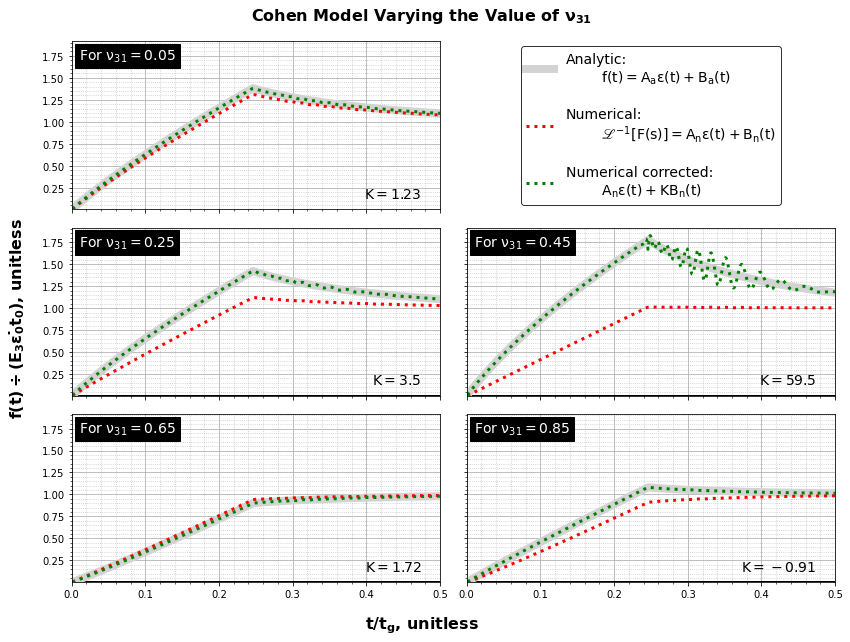

In [ ]:
param_name, param_name_latex = "t0_tg", r"t_{0}/t_{g}"   # Don't include the $ 
param_vals = np.linspace(0.05,0.5,5,endpoint=True)

param_name, param_name_latex = "v31", r"\nu_{31}"   # Don't include the $ 
param_vals = np.linspace(0.05,0.85,5,endpoint=True)
#param_vals = np.array([0.25, 0.5, np.sqrt(0.5)]) #np.linspace(0.05,0.85,5,endpoint=True)
"""
param_name, param_name_latex = "v21", r"\nu_{21}"   # Don't include the $ 
param_vals = np.linspace(0.05,0.85,5,endpoint=True)

param_name, param_name_latex = "E1", r"E_{1}"   # Don't include the $ 
param_vals = np.linspace(5,25,5,endpoint=True)

param_name, param_name_latex = "E3", r"E_{3}"   # Don't include the $ 
param_vals = np.linspace(5,25,5,endpoint=True)
"""

#VPEs = [(CohenModel(), fr"$Cohen$"), (getCohenModelModified(E1=3), f"$Cohen, E1={3}$") ]
VPEs = [(getCohenModelModified(**{param_name:param_val}), f"For ${param_name_latex}={np.round(param_val,2)}$") for param_val in param_vals]

plot_times_tg, t_step = np.linspace(0.001, 0.5, num=1001, endpoint=True, retstep=True)
# plot_times and strain can't be defined until the loop values of t0_tg, tg, etc may be needed
inverted_values_analy_vals = [None] * len(VPEs)
inverted_values_numer_vals = [None] * len(VPEs)
inverted_values_numer_val_corrs = [None] * len(VPEs)
corrections = [None] * len(VPEs)

for ind, (vpe, name) in enumerate(VPEs):
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = vpe.get_calculable_constants()
    corrections[ind] = (1-2*v31**2)/(1-2*v31)**2
    A = E3 * strain_rate * tg
    strain_eps0 = np.clip(plot_times_tg,0,t0_tg)  # defined as eps(t)/eps0

    inverted_values_analy_vals[ind] = vpe.inverted_value(plot_times_tg*tg)  /(A*t0_tg)
    inverted_values_numer_vals[ind] = inverting.euler_inversion(vpe.laplace_value, plot_times_tg) /(A*t0_tg)
    inverted_values_numer_val_corrs[ind] = (strain_eps0/t0_tg + (inverted_values_numer_vals[ind] - strain_eps0/t0_tg) * corrections[ind]) 


plt.rcParams['mathtext.default'] = 'regular'

ncols = np.floor(np.sqrt(len(VPEs))).astype(int)
nrows = np.ceil(len(VPEs)/ncols).astype(int)
nremainder = ncols*nrows-len(VPEs)
fig, axs = plt.subplots(nrows=nrows,ncols=ncols, figsize=(ncols*6,nrows*3), sharex=True, sharey=True)

#for ind, (vpe, name) in enumerate(VPEs):
nremainders_used = []
for ind2, ax in enumerate(axs.flat):
    if nremainder > len(nremainders_used):
        # Make extra blank subplots in the top/right so that there aren't any 
        # missing axes for the shared axes (since only one axes per column/row is 
        # shown, so there should definitely be a presented subplot in the left 
        # column and bottom row)
        if (ind2+1) % ncols == 0:
            nremainders_used.append(ind2)
            continue
    ind = ind2 - len(nremainders_used)
    vpe, name = VPEs[ind]
    axs.flat[ind2].plot(plot_times_tg, np.zeros_like(plot_times_tg),"k-",lw=2)
    axs.flat[ind2].plot(plot_times_tg, inverted_values_analy_vals[ind], "-", color="lightgray", lw=8, label=r"analy $f(t)=A_a\varepsilon(t)+B_a(t)$" )
    axs.flat[ind2].plot(plot_times_tg, inverted_values_numer_vals[ind], "r:", lw=3, label=r"numer $\mathscr{L}^{-1}(F(s))=A_n\varepsilon(t)+B_n(t)$" )
    axs.flat[ind2].plot(plot_times_tg, inverted_values_numer_val_corrs[ind], "g:", lw=3, label=r"Numerical corrected, $A_n\varepsilon(t)+KB_n(t)$" )
    #axs.flat[ind2].set_title(name)
    text = ax.text(0.02,0.96, name,
                    ha="left", va="top", color="w", 
                    bbox=dict(facecolor='k', alpha=1.0),
                    transform=ax.transAxes, fontsize=14
                    )
    """text = ax.text(0.01,0.96, name,
                    ha="left", va="top", color="k", 
                    #bbox=dict(facecolor='w', edgecolor="w", alpha=1.0),
                    transform=ax.transAxes, fontsize=14
                    )"""
    text = ax.text( np.max(plot_times_tg)*0.95, 0.1,f"$K={np.round(corrections[ind],2)}$",
                    ha="right", va="bottom", color="k", 
                    #bbox=dict(facecolor='w', alpha=1.0),
                    #transform=ax.transAxes, 
                    fontsize=14
                    )
    #axs.flat[ind2].set_title(name + f",\t $K={np.round(corrections[ind],2)}$")


handles, labels = axs.flat[0].get_legend_handles_labels()
labels = [r"Analytic, $f(t)=A_a\varepsilon(t)+B_a(t)$", r"Numerical, $\mathscr{L}^{-1}\left[F(s)\right]=A_n\varepsilon(t)+B_n(t)$", r"Numerical corrected, $A_n\varepsilon(t)+KB_n(t)$" ]
labels = [ 
          #("\n" if ind>0 else "")+
          ":\n\t".join(label.split(", ")) for ind, label in enumerate(labels)]

for ind2, ax in enumerate(axs.flat):

    if ind2 in nremainders_used:
        ax.set_axis_off()
        if ind2 == nremainders_used[0]:
            # put single legend in empty subplot
            ax.legend(handles, labels, loc="center", edgecolor="k", labelspacing=1.5, 
                      prop={
                          #'weight':'bold',
                          "size":14,
                          })  # 

    else:
        ax.grid(which="major")  # set major grid lines
        ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.set_xlim([0,np.max(plot_times_tg)])
        min_val = np.min(np.array(inverted_values_analy_vals))
        ax.set_ylim([min_val, None])
        #ax.set_xlabel("$t/t_g$, unitless")
        #ax.set_ylabel(r"$f(t) \div (E_3\dot{\varepsilon_0}t_0)$, unitless")
        #ax.legend()
        
if nremainder == 0:
    # put single legend attached to the overall figure
    fig.legend(handles, labels, weight="bold")
fig.supxlabel("$t/t_g$, unitless", fontsize=16, weight="bold")
fig.supylabel(r"$f(t) \div (E_3\dot{\varepsilon_0}t_0)$,"+" unitless\n", fontsize=16, weight="bold")
#fig.supylabel(r"$\frac{  f(t) }{E_3\dot{\varepsilon_0}t_0}$, unitless", fontsize=16)
fig.suptitle(f"Cohen Model Varying the Value of ${param_name_latex}$", fontsize=16, weight="bold")

plt.tight_layout()
plt.savefig(get_path_to_save(save_filename=f"Varying {param_name}", save_in_subfolder="Correction across varying params"), bbox_inches='tight')  # Include the bbox_inches='tight' is critical to ensure the saved images aren't cutoff while the colab images are normal

In [ ]:
def cohen_inverted_corrected(self, t, bessel_len=20):
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = self.get_predefined_constants()

    delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = self.get_calculable_constants()
    K = (1-2*v31*v31)/(1-2*v31)**2
    if bessel_len > self.saved_bessel_len:
        self.setup_constants(bessel_len=bessel_len)
    alpha2_vals = self.alpha2_vals
    F = np.piecewise(t,
                    [t/tg < 0, 
                    (t/tg >= 0) & (t/tg < t0_tg),
                    t/tg >= t0_tg],
                    [0,
                    (
                        lambda t:
                        E3 * strain_rate * t
                        + 1/K * E1 * strain_rate * tg * delta3
                        * (1/8 - sum(
                            exp(-alpha2_N * t/tg)
                            / (alpha2_N*(delta2*delta2*alpha2_N - delta1/(1+v21)))
                            for alpha2_N in alpha2_vals
                            )
                        )
                        ),
                    (
                        lambda t:
                        E3 * strain_rate * t0_tg*tg
                        - 1/K * E1 * strain_rate * tg * delta3
                        * sum(
                            (exp(-alpha2_N * t/tg)
                            - exp(-alpha2_N * (t/tg - t0_tg)))
                            / (alpha2_N*(delta2*delta2*alpha2_N - delta1/(1+v21)))
                            for alpha2_N in alpha2_vals
                            )
                        )]
                    )

    return F

<IPython.core.display.Javascript object>

In [ ]:
[type(F_s_recalc) for F_s_recalc in F_s_recalcs]

<IPython.core.display.Javascript object>

[numpy.ndarray, numpy.ndarray, numpy.ndarray, list]

<IPython.core.display.Javascript object>

[nan 0.8]
[13.08  0.06]
[15.79  0.09]
[22.38  0.12]


/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1195: RuntimeWarning: invalid value encountered in sqrt
  I1rts_s = I1(sqrt(s)) / sqrt(s)
/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1196: RuntimeWarning: invalid value encountered in sqrt
  I0rts = I0(sqrt(s))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/py

(-30.0, 50.0)

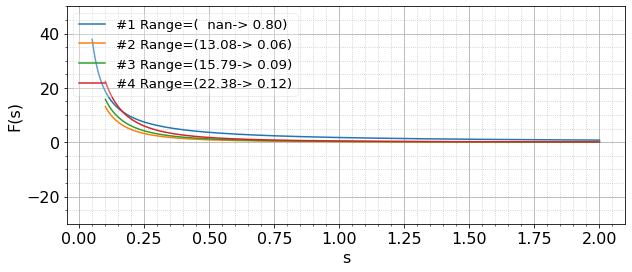

In [ ]:

importlib.reload(inverting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

VPEs = [(CohenModel(),"Cohen")]


plot_s = np.linspace(0.05, 2, num=1000, endpoint=True)
plot_s = np.concatenate( [-plot_s, plot_s])
#plot_s = np.linspace(-50+0j, 50+0j, num=666, endpoint=True)

t_new_anal = np.linspace(0.05, 100, num=1001, endpoint=True) 
min_s = 0.1

#-strain_eps0/t0_tg
strain_eps0 = np.clip(t_new_anal/VPEs[0][0].tg,0,t0_tg)  # defined as eps(t)/eps0

t_clipped = np.clip(t_new_anal, 0, VPEs[0][0].t0_tg*VPEs[0][0].tg)
v31 = VPEs[0][0].v31
E1_E3 = VPEs[0][0].E1/VPEs[0][0].E3
K = (1-2*v31*v31)/(1-2*v31)**2
K = (1-2*v31*v31)/(1-2*v31*E1_E3)**2


F_s_recalcs = [
               *[VPEs[ind][0].laplace_value(plot_s) for ind, _ in enumerate(VPEs) ],
               *[inverting.forward_laplace_transform( (lambda t: cohen_inverted_corrected(VPEs[ind][0],t)), plot_s[plot_s>min_s], times=np.linspace(0, 100, num=1001, endpoint=True) ) for ind, _ in enumerate(VPEs)],
               *[inverting.forward_laplace_transform(VPEs[ind][0].inverted_value, plot_s[plot_s>min_s], times=np.linspace(0, 100, num=1001, endpoint=True) ) for ind, _ in enumerate(VPEs)],
               *[inverting.forward_laplace_transform( (lambda t: (VPEs[ind][0].inverted_value(t)- E3*strain_rate*t_clipped)*K +E3*strain_rate*t_clipped),
                                                     plot_s[plot_s>min_s], times=np.linspace(0, 100, num=1001, endpoint=True) ) for ind, _ in enumerate(VPEs)],
               #*[inverting.forward_laplace_transform(inverting.euler_inversion(VPEs[ind][0].laplace_value, t_new_anal), plot_s[plot_s>min_s], times=t_new_anal ) for ind, _ in enumerate(VPEs) ],
               #*[laplace_vals_all[ind][0:len(plot_s)] for ind, _ in enumerate(VPEs) ],
               #*[inverting.forward_laplace_transform(inverted_vals_numerical_all[ind], plot_s, times=plot_times ) for ind, _ in enumerate(VPEs) ]
 
 ]


#F_s_recalcs.append(*[ E3*strain_rate*t_clipped + K*(F_s_recalc- E3*strain_rate*t_clipped) for F_s_recalc, (vpe, label) in zip(F_s_recalcs[2], VPEs)] )
#F_s_recalcs.append(*[ strain_eps0/VPEs[0][0].t0_tg + K*(F_s_recalc- strain_eps0/VPEs[0][0].t0_tg) for F_s_recalc, (vpe, label) in zip(F_s_recalcs[2], VPEs)] )

fig = plt.figure()
fig.set_figwidth(7.5)
fig.set_figwidth(10)
for ind, F_s_recalc in enumerate(F_s_recalcs):
    #bounds = F_s_recalc[np.array([0,-1])]
    bounds = np.array([F_s_recalc[0], F_s_recalc[-1]])
    plt.plot(plot_s[-len(F_s_recalc):], F_s_recalc, label=f"#{ind+1} Range=({bounds[0]:5.2f}->{bounds[1]:5.2f})")
    print(bounds.round(2))
plt.xlabel("s")
plt.ylabel("F(s)")
plt.legend(framealpha=0.3, fontsize='small', loc="upper left")
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#plt.xlim([-0.5,None])
plt.ylim([-30, 50])

## Test if the analytic and numerical solutions are displaced in terms of parameters
Hypothesis: the two curves are the same, but at different v31

In [ ]:
param_name, param_name_latex = "v31", r"\nu_{31}"   # Don't include the $ 
param_vals = np.linspace(-3,3,150+1,endpoint=True)

#VPEs = [(CohenModel(), fr"$Cohen$"), (getCohenModelModified(E1=3), f"$Cohen, E1={3}$") ]
VPEs = [(getCohenModelModified(**{param_name:param_val}), f"For ${param_name_latex}={np.round(param_val,2)}$") for param_val in param_vals]

plot_times_tg = np.array([0.1, 0.7,1,2,5])*VPEs[0][0].t0_tg
# plot_times and strain can't be defined until the loop values of t0_tg, tg, etc may be needed
inverted_values_analy_vals = [None] * len(VPEs)
inverted_values_numer_vals = [None] * len(VPEs)
inverted_values_numer_val_corrs = [None] * len(VPEs)
corrections = [None] * len(VPEs)

for ind, (vpe, name) in enumerate(VPEs):
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = vpe.get_calculable_constants()
    corrections[ind] = (1-2*v31**2)/(1-2*v31)**2
    A = E3 * strain_rate * tg    
    strain_eps0 = np.clip(plot_times_tg,0,t0_tg)  # defined as eps(t)/eps0

    inverted_values_analy_vals[ind] = vpe.inverted_value(plot_times_tg*tg)  /(A*t0_tg)
    inverted_values_numer_vals[ind] = inverting.euler_inversion(vpe.laplace_value, plot_times_tg) /(A*t0_tg)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1363: RuntimeWarning: divide by zero encountered in true_divide
  for alpha2_N in alpha2_vals
/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1375: RuntimeWarning: invalid value encountered in true_divide
  for alpha2_N in alpha2_vals


In [ ]:
np.flipud(df.iloc[:,1:3])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[-8.65799064e-02,  9.95465317e-01],
       [-1.00142746e-01,  9.95300962e-01],
       [-1.15047467e-01,  9.95126813e-01],
       [-1.31474943e-01,  9.95431699e-01],
       [-1.49638597e-01,  9.94745696e-01],
       [-1.69791918e-01,             nan],
       [-1.92238009e-01,  9.90646216e-01],
       [-2.17342148e-01,  9.94649482e-01],
       [-2.45548049e-01,  9.94434119e-01],
       [-2.77399624e-01,  9.94173800e-01],
       [-3.13570131e-01,  9.93871390e-01],
       [-3.54901824e-01,  9.93642227e-01],
       [-4.02460955e-01,             nan],
       [-4.57614917e-01,  9.93020503e-01],
       [-5.22142922e-01,  9.91842698e-01],
       [-5.98397583e-01,             nan],
       [-6.89546506e-01,  9.91771852e-01],
       [-7.99942737e-01,             nan],
       [-9.35708603e-01,             nan],
       [-1.10568674e+00,             nan],
       [-1.32304632e+00,  9.88600726e-01],
       [-1.60811291e+00,  9.88767925e-01],
       [-1.99360441e+00,             nan],
       [-2.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError


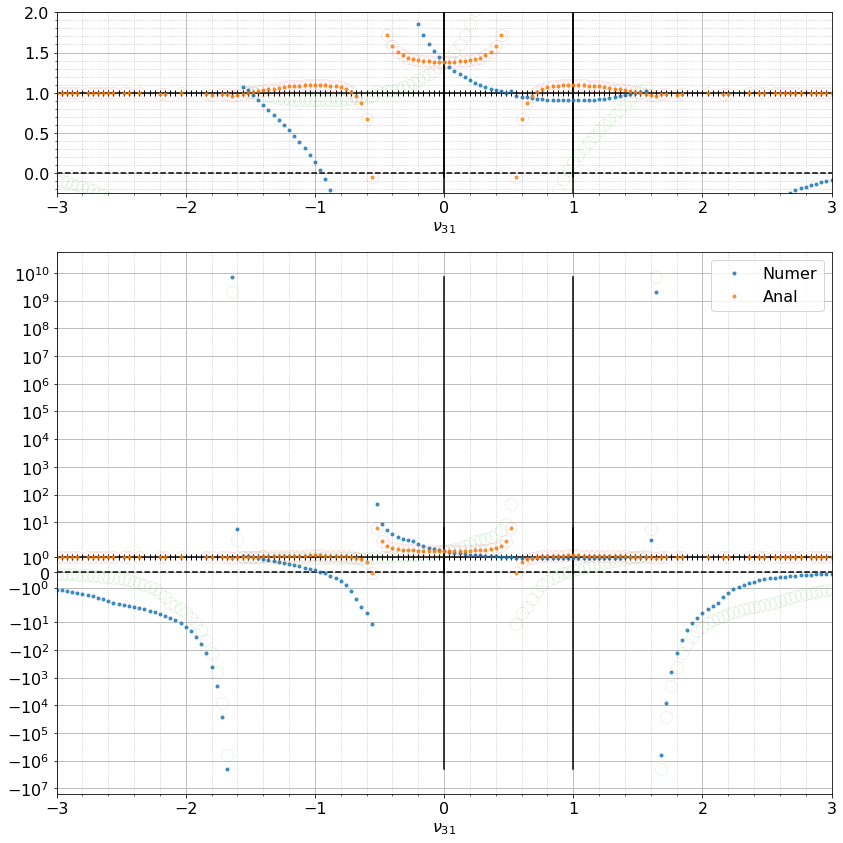

In [ ]:
ind_t0 = 2
inverted_values_analy_vals = np.array(inverted_values_analy_vals)
inverted_values_numer_vals = np.array(inverted_values_numer_vals)

df = pd.DataFrame(np.array([param_vals, inverted_values_numer_vals[:,ind_t0], inverted_values_analy_vals[:,ind_t0]]).T, columns=["v31","Numer","Anal"])

ncols=1
nrows=2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols, figsize=(ncols*12,nrows*6), gridspec_kw={"height_ratios":[1,3]})
for ind in range(nrows):
    axs.flat[ind].plot(df.iloc[:,0], np.zeros_like(df.iloc[:,0]), "k--")
    axs.flat[ind].plot(df.iloc[:,0], np.ones_like(df.iloc[:,0]), "k|-")
    axs.flat[ind].plot([0, 0], [np.min(df.iloc[:,1:3]), np.max(df.iloc[:,1:3])], "k-")
    axs.flat[ind].plot([1, 1], [np.min(df.iloc[:,1:3]), np.max(df.iloc[:,1:3])], "k-")
    lines = axs.flat[ind].plot(df.iloc[:,0], df.iloc[:,1:3], ".", alpha=0.8)
    linesflipped = axs.flat[ind].plot(df.iloc[:,0], np.flipud(df.iloc[:,1:3]), "o", mfc='none', ms=12, alpha=0.1)

for ax in axs.flat:
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.set_xlim([np.min(df.iloc[:,0]), np.max(df.iloc[:,0])])
    ax.set_xlabel(f"${param_name_latex}$")
    min_val = np.min(np.array(inverted_values_analy_vals))

axs.flat[0].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
axs.flat[0].set_ylim([-0.25, 2])
#axs.flat[1].set_ylim([0, None])
axs.flat[1].legend(lines, ["Numer","Anal"])
axs.flat[1].set_yscale("SymLog", linthresh=5.0, linscale=5.0)
plt.tight_layout()

The analytic solution is symmetric in the peak  vs $\nu_{31}$ graph over $\nu_{31}$. In other words, the sign of $\pm\nu_{31}$ does not seem to affect the value at $t=t_0$.

## Plot Cohen model with other strain input - TBD

In [ ]:
VPEs = [(viscoporoelastic_model.CohenModel(), fr"$Cohen$") ]

VPEs

fig = plt.figure()
plt.plot(param_vals, ((inverted_values_analy_np-A*np.clip(plot_times_tg, 0, t0_tg))/(inverted_values_numer_np-A*np.clip(plot_times_tg, 0, t0_tg))) )
#plt.plot(param_vals, (1-2*param_vals) )
#plt.plot(param_vals, (1-v21-2*param_vals**2*E1/E3), "m")
#plt.plot(param_vals, (1-param_vals**2*E1/E3), "m")
#plt.plot(param_vals, (1-2*param_vals**2), "m")
plt.plot(param_vals, ((1-2*param_vals**2)/(1-2*param_vals)**2), "m")

#plt.ylim([-2,2])
plt.ylim([-5,25])
plt.xlim([0,1])

for ax in fig.axes:
        ax.grid(which="major")  # set major grid lines
        ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        #ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")
        ax.set_xlim([0,np.max(param_vals)])
        ax.set_xlabel(param_name)
        ax.set_ylabel(r"""$(f(t)-A\varepsilon(t)) \div (f_{est}(t)-A\varepsilon(t))$""")

<IPython.core.display.Javascript object>

[1]

In [ ]:
#@markdown Simple Laplace - Numerical Inversion

importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
times=np.arange(0.1,100,0.1)/10000.0*10
times=np.arange(0.1,100,0.1)/100.0*10

input_times = times
plot_times  = times
input_times_anal = input_times
plot_times_anal = plot_times/1  #tg=1


# \rm gives roman style letters, which is indicative of a constant
#@markdown $$ F(s)=\frac{1}{s-a} $$
#@markdown $$ f(t)={\mathrm{e}}^{a t}=\exp{\left(a t\right)} $$.
a = -3.03 #@param {type:"number"}
funcs = lambda s: 1/(s-a)
inv_funcs_anal = lambda t: np.exp(a*t)
plot_props = {
    "t":        {"y":{"name":r"f(t)"}, "x":{"name":r"t, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}, 
                 "eqn":{"text":r"$F(s)=\frac{1}{s-a}$, $a="+str(a)+r"$"}},
    "t_anal":   {"eqn":{"text":r"$f(t)={\mathrm{e}}^{a t}$, $a="+str(a)+r"$"}},
}
input_s = np.arange(0.05, 5.05, 0.05)


_=plotting.plot_laplace_analysis(funcs=funcs, plot_props=plot_props, input_s=input_s, 
                                 input_times=input_times, plot_times=plot_times, time_const=1, 
                                 input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
                                 plot_mode="simple")


# Viscoporoelastic Models Inversions

## $\Delta_1$, $\Delta_2$, $\Delta_3$ definition equations
\begin{aligned}
\Delta_{1}&=1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}} \\
\Delta_{2}&=\left(1-v_{31}^{2} \frac{E_{1}}{E_{3}}\right) /\left(1+v_{21}\right) \\
\Delta_{3}&=\left(1-2 v_{31}^{2}\right) \frac{\Delta_{2}}{\Delta_{1}} \\
&= \left(1-2 v_{31}^{2}\right) \frac{\left(1-v_{31}^{2} \frac{E_{1}}{E_{3}}\right) /\left(1+v_{21}\right)}{1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}}}
=  \frac{\left(1-2 v_{31}^{2}\right) \left(1-v_{31}^{2} \frac{E_{1}}{E_{3}}\right) }{ \left( 1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}} \right) \left(1+v_{21}\right)}
\end{aligned}

<IPython.core.display.Javascript object>

It took 0.0259 sec to evaluate the Laplace space func for 1097 input s vals.
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
It took 1.2219 sec to numerically invert Laplace the func for 1001 input times.


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Value     Category
t0/tg         0.100     Constant
strain_rate   0.010     Constant
Vrz           0.240     Constant
Ezz          19.190     Constant
c             1.000  FittedParam
tau1          0.100  FittedParam
tau2         10.000  FittedParam
tg           40.620  FittedParam
Vrtheta       0.700  FittedParam
Err           8.490  FittedParam
t0            4.062   Calculated

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Value     Category
t0/tg         0.100     Constant
strain_rate   0.010     Constant
Vrz           0.240     Constant
Ezz          19.190     Constant
c             1.000  FittedParam
tau1          0.100  FittedParam
tau2         10.000  FittedParam
tg           40.620  FittedParam
Vrtheta       0.725  FittedParam
Err           8.490  FittedParam
t0            4.062   Calculated

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Value     Category
t0/tg         0.100     Constant
strain_rate   0.010     Constant
Vrz           0.240     Constant
Ezz          19.190     Constant
c             1.000  FittedParam
tau1          0.100  FittedParam
tau2         10.000  FittedParam
tg           40.620  FittedParam
Vrtheta       0.750  FittedParam
Err           8.490  FittedParam
t0            4.062   Calculated

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Value     Category
t0/tg         0.100     Constant
strain_rate   0.010     Constant
Vrz           0.240     Constant
Ezz          19.190     Constant
c             1.000  FittedParam
tau1          0.100  FittedParam
tau2         10.000  FittedParam
tg           40.620  FittedParam
Vrtheta       0.775  FittedParam
Err           8.490  FittedParam
t0            4.062   Calculated

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Value     Category
t0/tg         0.100     Constant
strain_rate   0.010     Constant
Vrz           0.240     Constant
Ezz          19.190     Constant
c             1.000  FittedParam
tau1          0.100  FittedParam
tau2         10.000  FittedParam
tg           40.620  FittedParam
Vrtheta       0.800  FittedParam
Err           8.490  FittedParam
t0            4.062   Calculated

t0/tg  strain_rate  ...   Err     t0
ViscoporoelasticModel1 - Line #1    0.1         0.01  ...  8.49  4.062
ViscoporoelasticModel1 - Line #2    0.1         0.01  ...  8.49  4.062
ViscoporoelasticModel1 - Line #3    0.1         0.01  ...  8.49  4.062
ViscoporoelasticModel1 - Line #4    0.1         0.01  ...  8.49  4.062
ViscoporoelasticModel1 - Line #5    0.1         0.01  ...  8.49  4.062

[5 rows x 11 columns]

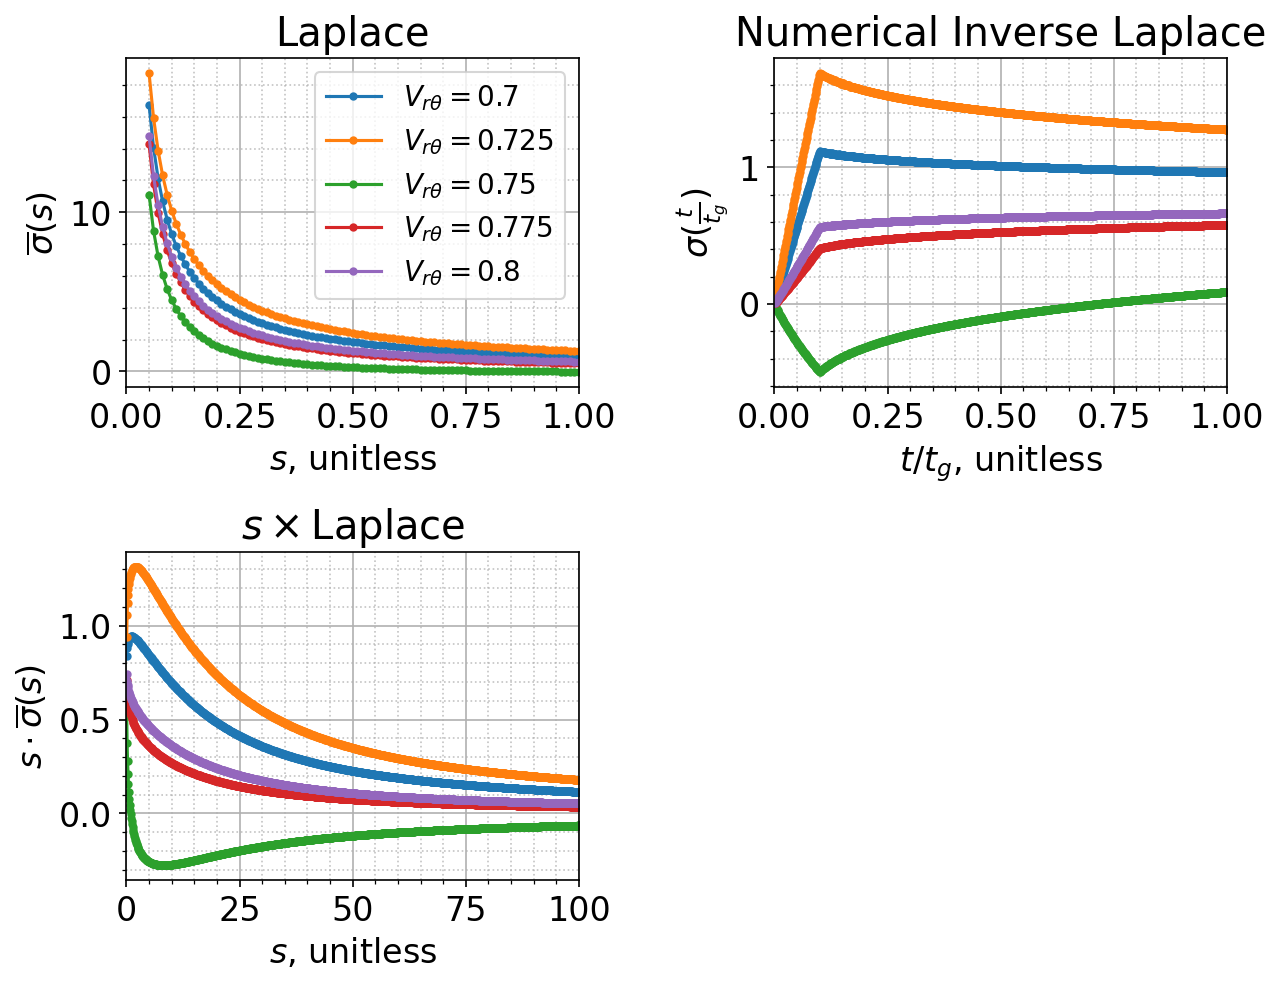

In [ ]:
#@title # ViscoporoelasticModel1


importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel1

#warnings.simplefilter('error') # throws all warnings as errors
#%pdb off

#@markdown Predefined constants
ViscoporoelasticModel1.t0_tg = 0.1 #@param {type:"number"} ; # 10 percent
ViscoporoelasticModel1.strain_rate = 0.01 #@param {type:"number"} ; # 1 percent per s (normally 1#/s)
## Below are directly determined by the mesh deformation part of the
## experiment (see our paper with Daniel).  -Dr. Spector
ViscoporoelasticModel1.Vrz = 0.24 #@param {type:"number"} ; # Not actually v, but greek nu (represents Poisson's ratio)
ViscoporoelasticModel1.Ezz =   19.19 #@param {type:"number"} ; # Note- don't mix up Ezz with epszz

#@markdown Fitted parameters (to be determined by experimental fitting to the unknown material)
## Fitted parameters (to be determined by experimental fitting to
# the unknown material)
c =   1 #@param {type:"number"} ;
tau1 =  0.1 #@param {type:"number"} ;  # units = sec
tau2 =  10 #@param {type:"number"} ;  # units = sec
#tau = [tau1, tau2];
#tau = [1 1];
tg=40.62 #@param {type:"number"}; #in units of s   # for porosity_sp == 0.5
Vrtheta =  0.75 #@param {type:"number"}; # Not actually v, but greek nu (represents Poisson's ratio)
Err =  8.49 #@param {type:"number"};

VPEs = [(ViscoporoelasticModel1(c=c,
                               tau1=tau1,
                               tau2=tau2, 
                               tg=tg, 
                               Vrtheta=Vrtheta, 
                               Err=Err), fr"$V_{{r\theta}}={Vrtheta}$") 
                              for Vrtheta in [0.7, 0.725, 0.75, 0.775, 0.8]]

t0_tg = VPEs[0][0].t0_tg

"""
func = []
import copy
func.append(vpe.laplace_value)
vpeB = copy.deepcopy(vpe)
vpeB.Vrtheta =  0.7
func.append(vpeB.laplace_value)
"""

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 1, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
#func = vpe.laplace_value
func = [vpe.laplace_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
x_names   = {"t":r"$t/t_g$, unitless", "s":r"$s$, unitless"}
plot_props = {
    "t":{"y":{"name":r"$\sigma(\frac{t}{t_g})$"}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":{"y":{"name":r"$\overline{\sigma}(s)$"},  "x":{"name":r"$s$, unitless"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)
plot_s_s = np.linspace(0.05, 100, num=1000, endpoint=True) # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    #model_name = VPEs[0][0].get_model_name(), 
    func_labels = func_labels)

itemindex = np.abs(input_times/tg - t0_tg).argmin()
for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{func_name['s'].replace('$','')}={laplace_vals[0]*input_s[0]:0.3f}"))
    display(vpe.get_var_df())

#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)


In [ ]:
#@title # ViscoporoelasticModel2
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel2

VPEs = [(ViscoporoelasticModel2(t0_tg=t0_tg), fr"$t_0/t_g={t0_tg}$") 
                              for t0_tg in [1, 10]]
tg = VPEs[0][0].tg
t0_tg = VPEs[0][0].t0_tg

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
plot_times = np.linspace(0.01, 25, num=10001, endpoint=True)*tg
#plot_times = np.logspace(-3, 4, num=10001, endpoint=True)*tg
#input_times = plot_times
plot_times_log = np.logspace(-3, 3, num=10001, endpoint=True)*tg
input_times = np.concatenate((plot_times, plot_times_log))
func = [vpe.laplace_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$T(\frac{t}{t_g})$", "s":r"$\overline{T}(s)$"}
x_names   = {"t":"$t/t_g$, unitless", "s":"$s$, unitless"}
plot_props = {
    "t":{"y":{"name":r"$T(\frac{t}{t_g})$"}, "x":{"name":"$t/t_g$, unitless", "scale":"linear"}},
    "s":{"y":{"name":r"$\overline{T}(s)$"},  "x":{"name":"$s$, unitless"}},
  }
plot_s = np.linspace(0.01, 0.4, num=1001, endpoint=True)
plot_s_s = np.linspace(1, 1000, num=1000, endpoint=True) # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))

plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s, 
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    #model_name = VPEs[0][0].get_model_name(), 
    func_labels = func_labels)
ax01 = axs[0,1] if isinstance(axs[1], collections.abc.Container) else axs[1]
ax11 = axs[1,1] if isinstance(axs[1], collections.abc.Container) else axs[1]


ax_curr=ax11
ax_curr.axis("on")
for inverted_vals_numerical, func_label in zip(inverted_vals_numerical_all, func_labels):
    ax_curr.plot(plot_times_log/tg, inverted_vals_numerical[-len(plot_times_log):], ".-", label=func_label)
ax_curr.set_xlabel(plot_props.get("t").get("x").get("name"))   # plot_props["t"]["x"]["name"] 
#ax_curr.set_xscale(plot_props.get("t").get("x").get("scale") or "linear")
ax_curr.set_xscale("log")
ax_curr.set_xlim( [min(plot_times_log/tg), max(plot_times_log/tg)]) 
ax_curr.set_ylabel(plot_props.get("t").get("y").get("name"))  # plot_props["t"]["y"]["name"]
ax_curr.set_yscale(plot_props.get("t").get("y").get("scale") or "linear")
ax_curr.title.set_text("Numerical Inverse Laplace")
ax_curr.grid(which="major")
ax_curr.grid(which="minor", alpha=0.75, linestyle=":")
ax_curr.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10,subs=np.arange(2,10),numticks=10*ax01.xaxis.get_tick_space()))
ax_curr.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())


df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() for vpe, label in VPEs])
display(df_params)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

It took 0.0089 sec to evaluate the Laplace space func for 1097 input s vals.
Warning the function could not be inverted at some (168/2002) values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are 0-4,1001-1163. The values are [0.001      0.002999   0.004998   0.006997   0.008996   0.001
 0.00101391 0.00102802 0.00104232 0.00105682 0.00107152 0.00108643
 0.00110154 0.00111686 0.0011324  0.00114815 0.00116413 0.00118032
 0.00119674 0.00121339 0.00123027 0.00124738 0.00126474 0.00128233
 0.00130017 0.00131826 0.0013366  0.00135519 0.00137404 0.00139316
 0.00141254 0.00143219 0.00145211 0.00147231 0.00149279 0.00151356
 0.00153462 0.00155597 0.00157761 0.00159956 0.00162181 0.00164437
 0.00166725 0.00169044 0.00171396 0.0017378  0.00176198 0.00178649
 0.00181134 0.00183654 0.00186209 0.00188799 0.00191426 0.00194089
 0.00196789 0.00199526 0.00202302 0.00205116 0.0020797  0.00210863
 0.00213796 0.0021677  0.00219786 0.00222844 0.00225944 0.00229087


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

t0/tg  strain_rate  ...   Err    t0
ViscoporoelasticModel3 - Line #1  0.246184         0.01  ...  8.49  10.0
ViscoporoelasticModel3 - Line #2  0.246184         0.01  ...  8.49  10.0
ViscoporoelasticModel3 - Line #3  0.246184         0.01  ...  8.49  10.0
ViscoporoelasticModel3 - Line #4  0.246184         0.01  ...  8.49  10.0

[4 rows x 11 columns]

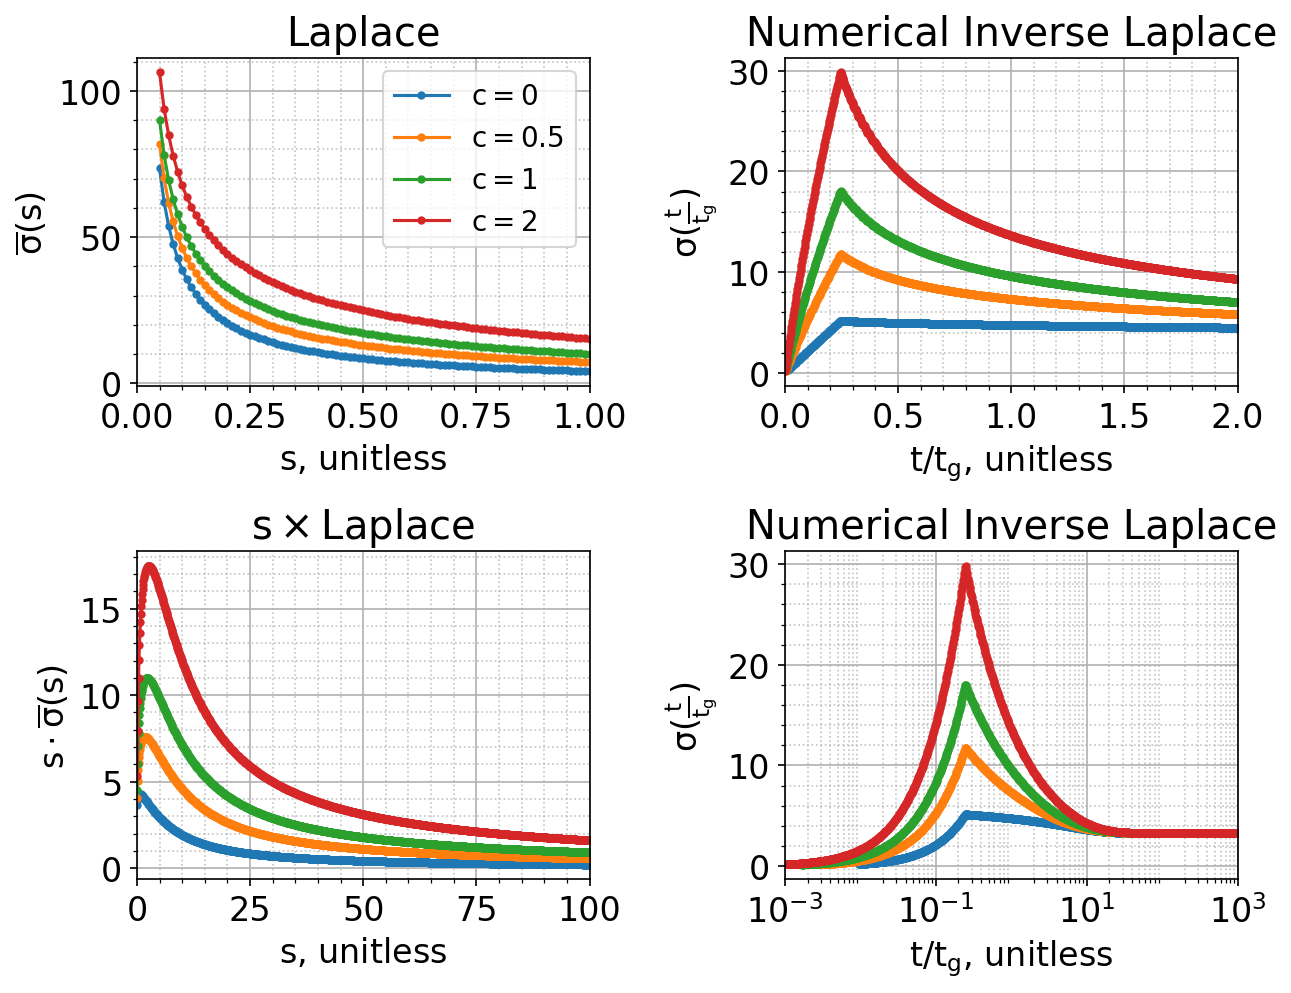

In [ ]:
#@title # ViscoporoelasticModel3
importlib.reload(plotting)
plotting.reload_imports()
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel3

ViscoporoelasticModel3.Ezz = 19  # kPa
ViscoporoelasticModel3.Vrz = 0.24  #unitless
ViscoporoelasticModel3.strain_rate = 0.01  # sec^-1

#@markdown Fitted parameters (to be determined by experimental fitting to the unknown material)
## Fitted parameters (to be determined by experimental fitting to
# the unknown material)
c =   1 #@param {type:"number"} ;
tau1 =  0.1 #@param {type:"number"} ;  # units = sec
tau2 =  10 #@param {type:"number"} ;  # units = sec
#tau = [tau1, tau2];
#tau = [1 1];
tg=40.62 #@param {type:"number"}; #in units of s   # for porosity_sp == 0.5
Vrtheta =  0.75 #@param {type:"number"}; # Not actually v, but greek nu (represents Poisson's ratio)
Err =  8.49 #@param {type:"number"};

VPEs = [(ViscoporoelasticModel3(c=c,
                               tau1=tau1,
                               tau2=tau2, 
                               tg=tg, 
                               Vrtheta=Vrtheta, 
                               Err=Err), fr"$c={c}$") 
                              for c in [0, 0.5, 1, 2]]

t0_tg = VPEs[0][0].t0_tg

"""
func = []
import copy
func.append(vpe.laplace_value)
vpeB = copy.deepcopy(vpe)
vpeB.Vrtheta =  0.7
func.append(vpeB.laplace_value)
"""

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
plot_times_log = np.logspace(-3, 3, num=1001, endpoint=True)*tg
input_times = np.concatenate((plot_times, plot_times_log))
#func = vpe.laplace_value
func = [vpe.laplace_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
x_names   = {"t":r"$t/t_g$, unitless", "s":r"$s$, unitless"}
plot_props = {
    "t":{"y":{"name":r"$\sigma(\frac{t}{t_g})$"}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":{"y":{"name":r"$\overline{\sigma}(s)$"},  "x":{"name":r"$s$, unitless"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)
plot_s_s = np.linspace(0.05, 100, num=1000, endpoint=True) # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    #model_name = VPEs[0][0].get_model_name(), 
    func_labels = func_labels)

ax01 = axs[0,1] if isinstance(axs[1], collections.abc.Container) else axs[1]
ax11 = axs[1,1] if isinstance(axs[1], collections.abc.Container) else axs[1]


ax_curr=ax11
ax_curr.axis("on")
for inverted_vals_numerical, func_label in zip(inverted_vals_numerical_all, func_labels):
    ax_curr.plot(plot_times_log/tg, inverted_vals_numerical[-len(plot_times_log):], ".-", label=func_label)
ax_curr.set_xlabel(plot_props.get("t").get("x").get("name"))   # plot_props["t"]["x"]["name"] 
#ax_curr.set_xscale(plot_props.get("t").get("x").get("scale") or "linear")
ax_curr.set_xscale("log")
ax_curr.set_xlim( [min(plot_times_log/tg), max(plot_times_log/tg)]) 
ax_curr.set_ylabel(plot_props.get("t").get("y").get("name"))  # plot_props["t"]["y"]["name"]
ax_curr.set_yscale(plot_props.get("t").get("y").get("scale") or "linear")
ax_curr.title.set_text("Numerical Inverse Laplace")
ax_curr.grid(which="major")
ax_curr.grid(which="minor", alpha=0.75, linestyle=":")
ax_curr.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10,subs=np.arange(2,10),numticks=10*ax01.xaxis.get_tick_space()))
ax_curr.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())


itemindex = np.abs(input_times/tg - t0_tg).argmin()
for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{func_name['s'].replace('$','')}={laplace_vals[0]*input_s[0]:0.3f}"))
    #display(vpe.get_var_df())


#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

# Laplace function relevant properties - for diagnosing errors
## Sources:
*   https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/LaplaceProps.html
*   https://lpsa.swarthmore.edu/LaplaceZTable/Common%20Laplace%20Transform%20Pairs.pdf

## Properties:  
1. Initial Value Theorem   
image.png

1. Final Value Theorem   
image.png

1. Time scaling.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgB1.gif)

1. Multiplication by time.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgAF.gif)

$f'(t)$ represents the derivative of $f(t)$
$$
\begin{align}
\L{f'(t)}&=sF(s)-f(0^-) \\
\L{f''(t)}&=s^2F(s)-sf(0^-)-f'(0^-) \\ 
\L{f'''(t)}&=s^3F(s)-s^2f(0^-)-sf'(0^-)-f''(0^-) \\ 
\L{f^{(m)}(t)}&=s^mF(s)-\sum_{n=m-1}^{0} s^nf^{(m-n-1)}(0^-) \\ 
\end{align}
$$

$f'(t)$ represents the derivative of $f(t)$
$$
\begin{align}
\L{f'(t)}&=sF(s)-f(0^-) \\
\L{f''(t)}&=s^2F(s)-sf(0^-)-f'(0^-) \\ 
\L{f'''(t)}&=s^3F(s)-s^2f(0^-)-sf'(0^-)-f''(0^-) \\ 
\L{f^{(m)}(t)}&=s^mF(s)-\sum_{n=m-1}^{0} s^nf^{(m-n-1)}(0^-) \\ 
\end{align}
$$

#Bessel info
Source: wolfram alpha

image.png

image.png

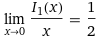

Source: https://www.mathworks.com/help/matlab/ref/besseli.html
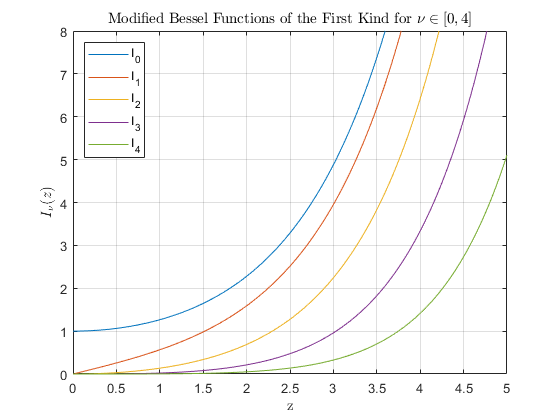

Misra, D.K. (2006). Appendix C: Bessel Functions. In Practical Electromagnetics, D.K. Misra (Ed.). https://doi-org.proxy2.library.illinois.edu/10.1002/9780470054208.app3

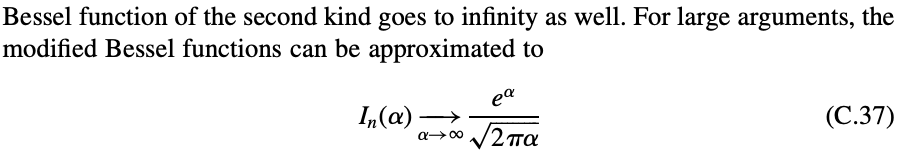


Zeros of Bessel’s Functions of the First Kind   

| # of Zeros |    J0(x) 	| J1(x)    	| J2(x)    	| J3(x)    	| J4(x)    	| J5(x)    	|
|-------------	|-----------------	|----------	|----------	|----------	|----------	|----------	|
|           1 	| 2.40483         	| 3.83171  	| 5.13562  	| 6.38016  	| 7.58834  	| 8.77148  	|
| 2           	| 5.52008         	| 7.01559  	| 8.41724  	| 9.76102  	| 11.06471 	| 12.3386  	|
| 3           	| 8.65373         	| 10.17347 	| 11.61984 	| 13.0152  	| 14.37254 	| 15.70017 	|
| 4           	| 11.79153        	| 13.32369 	| 14.79595 	| 16.22347 	| 17.61597 	| 18.98013 	|
| 5           	| 14.93092        	| 16.47063 	| 17.95982 	| 19.40941 	| 20.82693 	| 22.2178  	|

TABLE C.2 Zeros of the Derivatives of Bessel’s Functions of the First Kind

| Number of Zeros 	| J0'(x)   	| J1'(x)   	| J2'(x)   	| J3'(x)   	| J4'(x)   	| J5'(x)   	|
|-----------------	|----------	|----------	|----------	|----------	|----------	|----------	|
| 1               	| 3.83171  	| 1.84118  	| 3.05424  	| 4.20119  	| 5.31755  	| 6.41562  	|
| 2               	| 7.01559  	| 5.33144  	| 6.70613  	| 8.01524  	| 9.2824   	| 10.51986 	|
| 3               	| 10.17347 	| 8.53632  	| 9.96947  	| 11.34592 	| 12.68191 	| 13.98719 	|
| 4               	| 13.32369 	| 11.706   	| 13.17037 	| 14.58585 	| 15.96411 	| 17.31284 	|
| 5               	| 16.4706  	| 14.86359 	| 16.34752 	| 17.78875 	| 19.19603 	| 20.57551 	|

https://functions.wolfram.com/Bessel-TypeFunctions/BesselI/introductions/Bessels/ShowAll.html

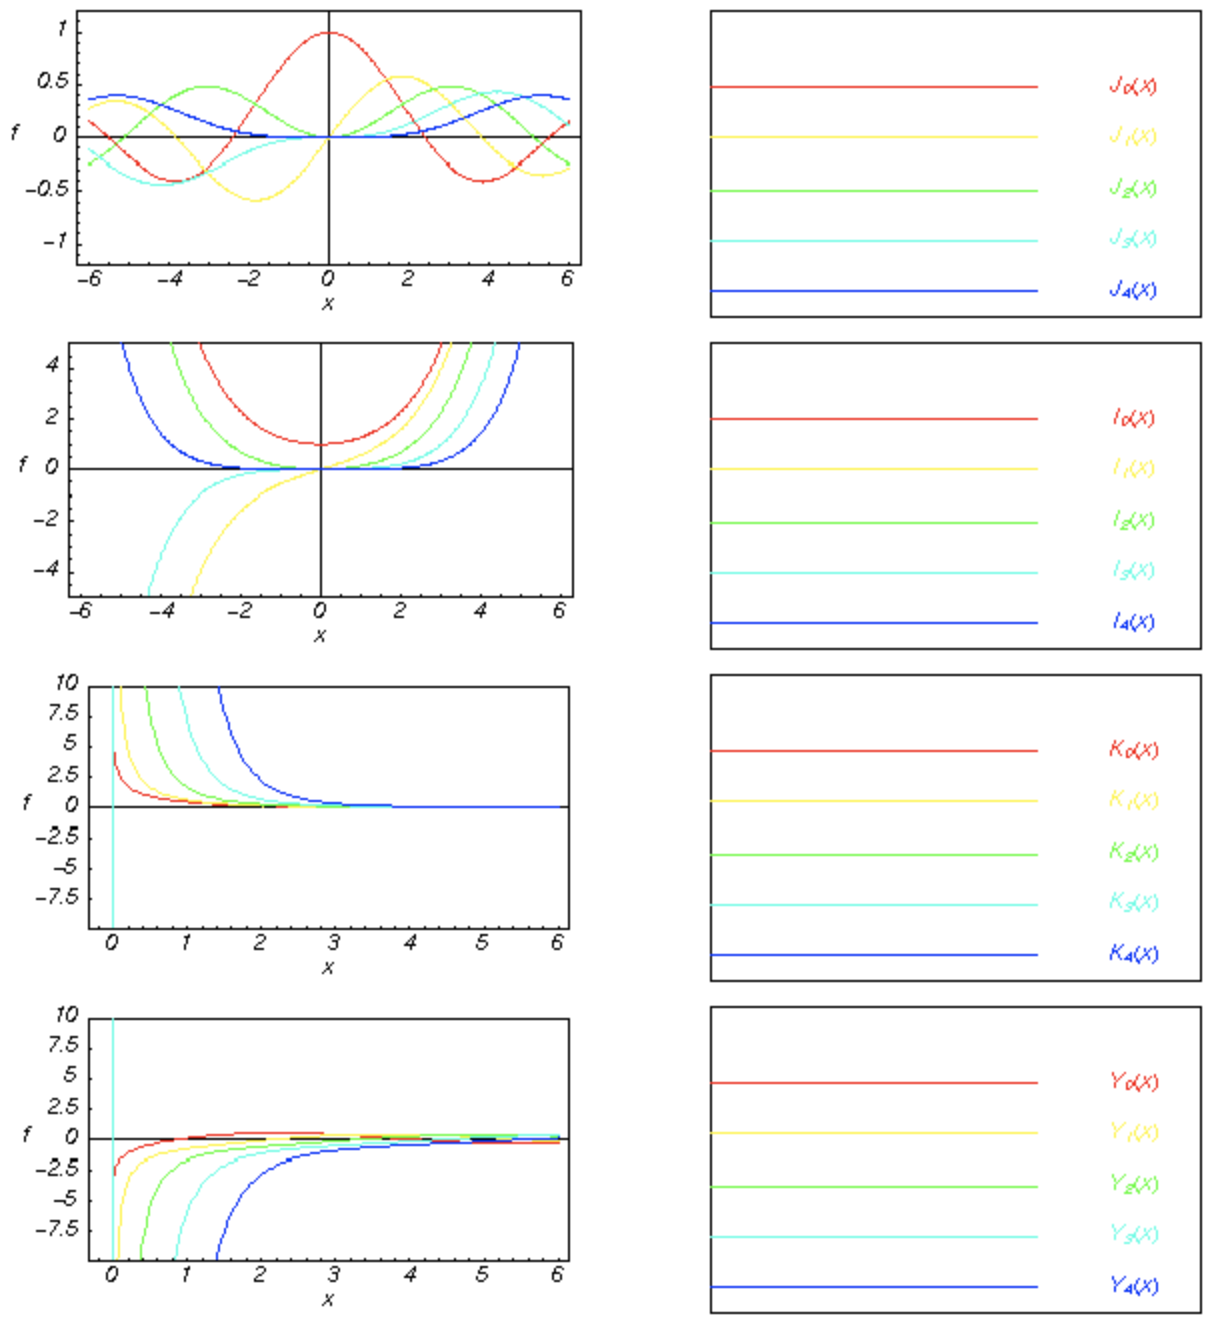

Source: http://www.mhtlab.uwaterloo.ca/courses/me755/web_chap4.pdf
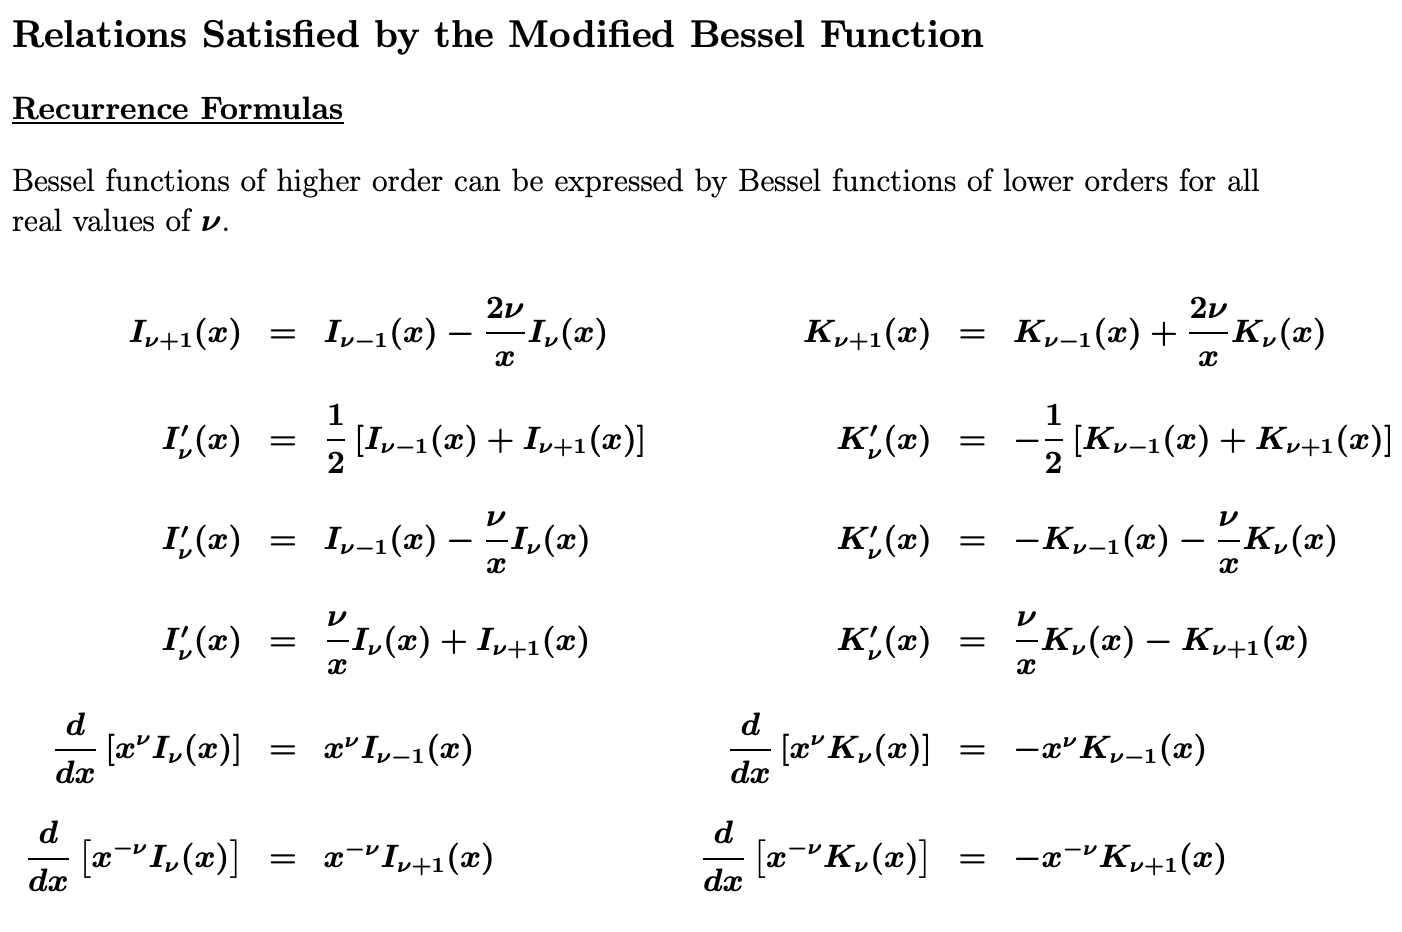

## Definitions .....................................................................

### 1. Bessel Equation

The second order differential equation given as

x^2 y'' + x y' + (x^2 - v^2)y=0

$x^2
d^2 y
dx^2
+x
dy
dx
−(x^2 +ν^2 )y=0$
```
$x^2 d^2 ydx^2 +x dy dx +(x^2 −ν^2 )y=0$
```
is known as Bessel’s equation. Where the solution to Bessel’s equation yields Bessel functions
of the first and second kind as follows:

$y=AJν(x)+BYν(x)$
```
y=AJν(x)+BYν(x)
```
whereAandBare arbitrary constants. While Bessel functions are often presented in text
books and tables in the form of integer order, i.e. ν=0, 1 , 2 ,...,infact they are defined
for all real values of−∞<ν<∞.

### 2. Bessel Functions

```
a) First Kind: Jν(x)in the solution to Bessel’s equation is referred to as a Bessel
function of the first kind.
b) Second Kind: Yν(x) in the solution to Bessel’s equation is referred to as a
Bessel function of the second kind or sometimes the Weber function or the
Neumann function.
b) Third Kind: The Hankel function or Bessel function of the third kind can be
written as
```
```
Hν(1)(x)=Jν(x)+iYν(x) x> 0
Hν(2)(x)=Jν(x)−iYν(x) x> 0
```
```
Because of the linear independence of the Bessel function of the first and second
kind, the Hankel functions provide an alternative pair of solutions to the Bessel
differential equation.
```

### 3. Modified Bessel Equation

By lettingx= ix(wherei=

#### √

− 1 )inthe Bessel equation we can obtain the modified
Bessel equation of orderν,given as

```
x^2
d^2 y
dx^2
+x
dy
dx
−(x^2 +ν^2 )y=
```
The solution to the modified Bessel equation yields modified Bessel functions of the first and
second kind as follows:

```
y=CIν(x)+DKν(x) x> 0
```
### 4. Modified Bessel Functions

```
a) First Kind: Iν(x)in the solution to the modified Bessel’s equation is referred
to as a modified Bessel function of the first kind.
b) Second Kind: Kν(x)in the solution to the modified Bessel’s equation is re-
ferred to as a modified Bessel function of the second kind or sometimes the
Weberfunction or the Neumann function.
```

# Hyperbolic Trig Definitions
Source: https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions on 2021_07_13

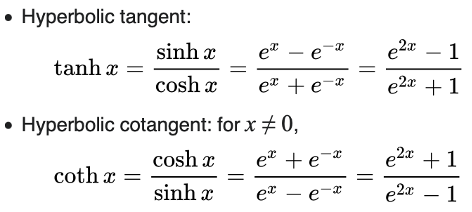